In [1]:
import praw
import json



Don't forget that the `reddit_producer.py` should be running and listening.

In [2]:
with open("config.json", "r") as jsonfile:
    data = json.load(jsonfile)  # Reading the config file
    print("Config data read successful", data)


Config data read successful {'client_id': 'p7Q7MtjnEl9tSKYSS_X4tw', 'client_secret': 'xqWl0rnvF6GQFMMD8tIPW3nDQu298A'}


In [3]:
from collections import namedtuple  # Each element will be assigned a field
import sys
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession,SQLContext
# Allow us to order things in decscending order
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt
from IPython.display import display, clear_output



# create spark configuration
conf = SparkConf()
conf.setAppName("RedditStreamApp")
# create spark context with the above configuration
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
# create the Streaming Context from the above spark context with interval size 10 seconds
ssc = StreamingContext(sc,10)
# setting a checkpoint to allow RDD recovery
#ssc.checkpoint("checkpoint_RedditApp")
# read data from port 5590
# socket_stream = ssc.socketTextStream("localhost", 5590)


# sc = SparkContext() # Establish an entry point of Apache Spark functionality.
# ssc = StreamingContext(sc, 10) # Create streaming context with intervals of 10 seconds.
sqlContext = SQLContext(sc) # Initialising Spark SQL functionalities.

socket_stream = ssc.socketTextStream("127.0.0.1", 5590)


/usr/local/spark/python/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(
/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
### Modify the code here to match your logic in reddit_producer.py
lines = socket_stream.window(20)
fields = ("author", "id", "submission", "body", "subreddit", "created_utc", "collected_utc")
RedditComment = namedtuple('RedditComment', fields)

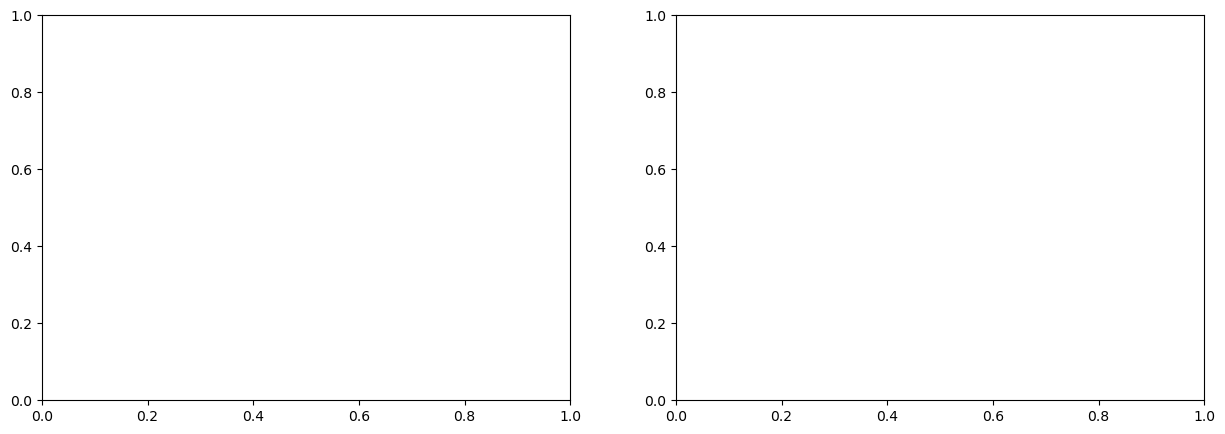

In [5]:
from collections import defaultdict
import numpy as np
from river import linear_model
from river import metrics
from river import preprocessing

plot_data = {
    'timestamp': [],
    'avg_unique_words': []
}

cumulative_counts = {
    'AskUK': defaultdict(lambda: 0),
    'AskAnAmerican': defaultdict(lambda: 0)
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']

def test_content(string):
    print(string)
    return eval(string)

def process_rdd(time, rdd):
    print("----------- %s -----------" % str(time))
    try:
        sql_context = get_sql_context_instance(rdd.context)
        row_rdd = rdd.map(lambda rec: RedditComment(**rec))
        comments_df = sql_context.createDataFrame(row_rdd)
        comments_df.registerTempTable("comments")

        # SQL Query for average unique words per comment
        unique_words_query = """
        SELECT SIZE(ARRAY_DISTINCT(SPLIT(body, ' '))) AS unique_word_count
        FROM comments
        """
        unique_words_result = sql_context.sql(unique_words_query).collect()
        unique_word_counts = [row['unique_word_count'] for row in unique_words_result]
        avg_unique_words = np.mean(unique_word_counts) if unique_word_counts else 0

        # SQL Query for cumulative unique words per subreddit
        cum_query = """
        SELECT subreddit, SIZE(ARRAY_DISTINCT(FLATTEN(COLLECT_LIST(SPLIT(body, ' '))))) AS unique_word_count
        FROM comments
        GROUP BY subreddit
        """
        cum_results = sql_context.sql(cum_query).collect()

        # Update plot data for average unique words
        plot_data['timestamp'].append(time)
        plot_data['avg_unique_words'].append(avg_unique_words)

        # Update cumulative counts
        for result in cum_results:
            subreddit = result['subreddit']
            count = result['unique_word_count']
            cumulative_counts[subreddit][time] += count


        # Ensure times are sorted to maintain cumulative order
        times = sorted(list(set(cumulative_counts['AskUK'].keys()).union(cumulative_counts['AskAnAmerican'].keys())))

        # Calculate the running total for cumulative counts
        askUK_cumulative = np.cumsum([cumulative_counts['AskUK'][time] for time in times])
        askAnAmerican_cumulative = np.cumsum([cumulative_counts['AskAnAmerican'][time] for time in times])

        # Plotting for average unique words
        ax1.clear()
        ax1.plot(plot_data['timestamp'], plot_data['avg_unique_words'], label='Average Unique Words per Comment')
        ax1.set_xlabel('Timestamp')
        ax1.set_ylabel('Average Unique Words')
        ax1.legend()
        ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees


        # Plotting for cumulative unique words
        ax2.clear()
        ax2.plot(times, askUK_cumulative, label='AskUK')
        ax2.plot(times, askAnAmerican_cumulative, label='AskAnAmerican')
        ax2.set_xlabel('Timestamp')
        ax2.set_ylabel('Cumulative Unique Words')
        ax2.legend()
        ax2.tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees

        
        comments_df_sql = sql_context.sql("select * from comments limit 10")
        comments_df_sql.show()
        display(fig)


        # SQL Query to get unique word count and comment length
        query = """
        SELECT body, SIZE(ARRAY_DISTINCT(SPLIT(body, ' '))) AS unique_word_count, LENGTH(body) as comment_length
        FROM comments
        """
        results = sql_context.sql(query).collect()

        # Initialize a scaler along with the linear regression model
        scaler = preprocessing.StandardScaler()
        model = linear_model.LinearRegression()
        metric = metrics.MAE()

        for row in results:
            comment_length = row['comment_length']
            unique_word_count = row['unique_word_count']
        
            # Update the scaler
            scaler.learn_one({'comment_length': comment_length})
        
            # Transform the feature
            scaled_length = scaler.transform_one({'comment_length': comment_length})
        
            # Update the model
            model.learn_one(scaled_length, unique_word_count)
        
            # Update the metric
            prediction = model.predict_one(scaled_length)
            metric.update(unique_word_count, prediction)
        
        print(f"Current MAE: {metric.get()}")


    except Exception as e:
        print("Error: %s" % e)


(lines.map(lambda text: test_content(text))
    .foreachRDD(process_rdd)
    )

----------- 2023-12-08 23:16:30 -----------
Error: RDD is empty


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


----------- 2023-12-08 23:16:40 -----------


/usr/local/spark/python/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+--------------------+-------+----------+--------------------+-------------+-------------+-------------+
|              author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------------+-------+----------+--------------------+-------------+-------------+-------------+
|         Staydenwick|kckbfh4|   18dz25h|And a merry Chris...|        AskUK|1.702076643E9|   1702077391|
|      spilledbeans44|kckbfmw|   18dtewi|Yes to the point ...|AskAnAmerican|1.702076645E9|   1702077391|
|    GeneralProof8620|kckbfrq|   18dl6a5|The drinking cult...|        AskUK|1.702076647E9|   1702077391|
|        Pippinsmom19|kckbfvc|   18dru1r|I am in my 50s an...|AskAnAmerican|1.702076648E9|   1702077391|
|                Cogz|kckbgse|   18dvkc3|Biscuits brown lo...|        AskUK|1.702076659E9|   1702077391|
|      StationFar6396|kckbhdr|   18dymwu|Because of the ba...|        AskUK|1.702076666E9|   1702077391|
|             mmcc120|kckbi0h|   18dvmk1|             C

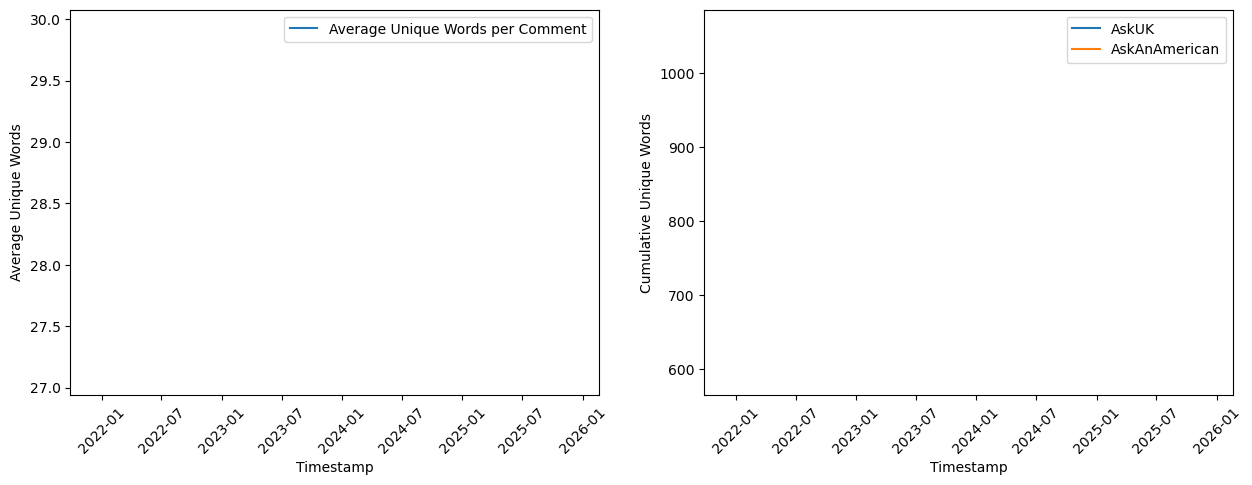

Current MAE: 12.132157950753253
----------- 2023-12-08 23:16:50 -----------
+--------------------+-------+----------+--------------------+-------------+-------------+-------------+
|              author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------------+-------+----------+--------------------+-------------+-------------+-------------+
|         Staydenwick|kckbfh4|   18dz25h|And a merry Chris...|        AskUK|1.702076643E9|   1702077391|
|      spilledbeans44|kckbfmw|   18dtewi|Yes to the point ...|AskAnAmerican|1.702076645E9|   1702077391|
|    GeneralProof8620|kckbfrq|   18dl6a5|The drinking cult...|        AskUK|1.702076647E9|   1702077391|
|        Pippinsmom19|kckbfvc|   18dru1r|I am in my 50s an...|AskAnAmerican|1.702076648E9|   1702077391|
|                Cogz|kckbgse|   18dvkc3|Biscuits brown lo...|        AskUK|1.702076659E9|   1702077391|
|      StationFar6396|kckbhdr|   18dymwu|Because of the ba...|        AskUK|1.702076

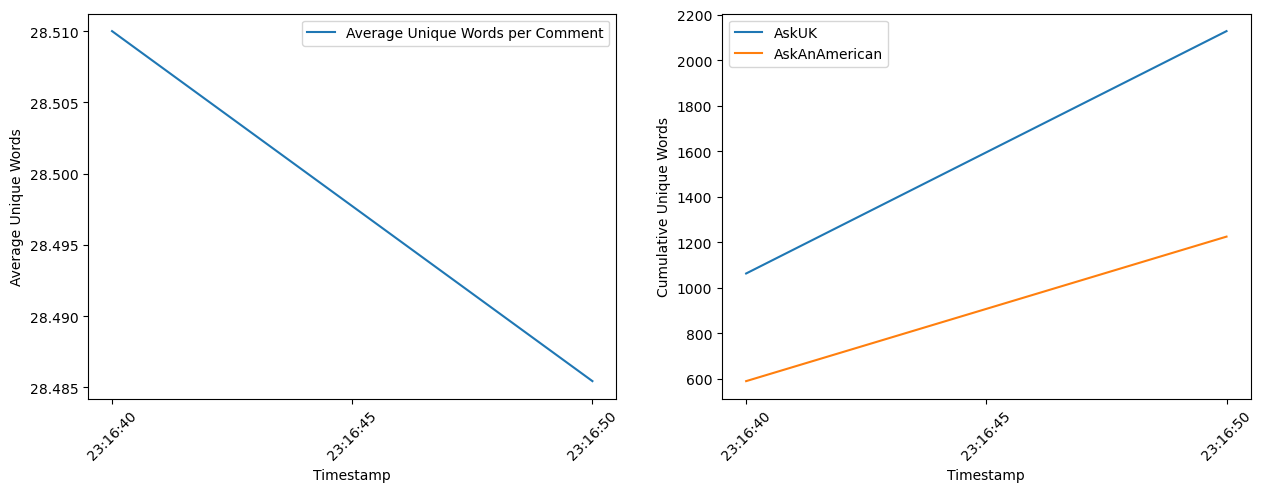

Current MAE: 11.945526928764762
----------- 2023-12-08 23:17:00 -----------
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|        author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|   adaminaudio|kckd56k|   18dymwu|I do love King Gi...|        AskUK|1.702077392E9|   1702077409|
|        Plumot|kckd5bn|    qm8oei|I have no idea, i...|        AskUK|1.702077394E9|   1702077409|
|ubiquitous-joe|kckd5mg|   18dwhrn|Parts of New York...|AskAnAmerican|1.702077397E9|   1702077409|
| Cupid_Stunt17|kckd5vo|   18dyvah|Anal beads shaped...|        AskUK|1.702077401E9|   1702077411|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+



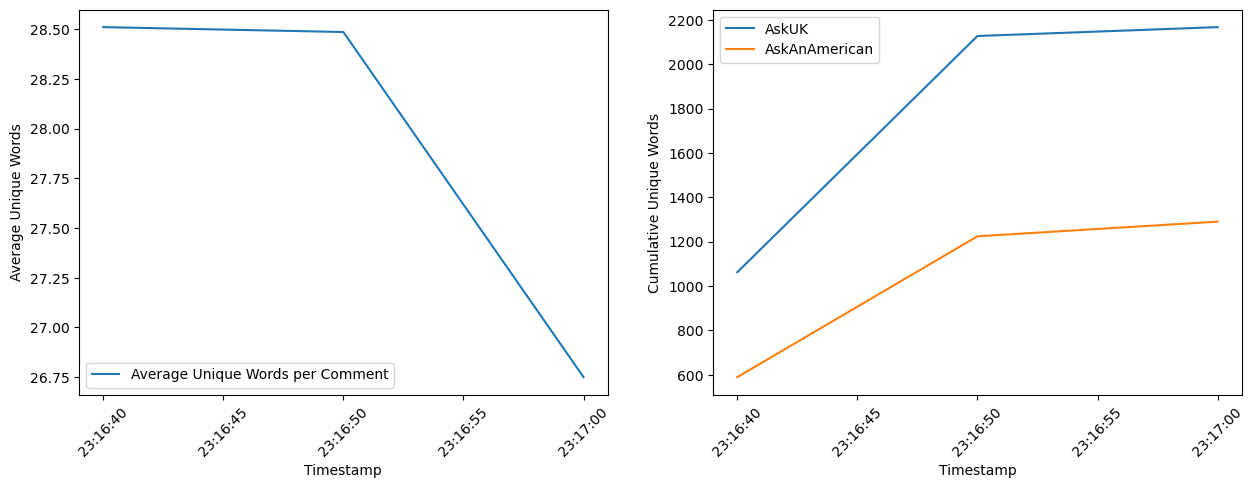

Current MAE: 25.112617908048698
----------- 2023-12-08 23:17:10 -----------
+-------------+-------+----------+--------------------+---------+-------------+-------------+
|       author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-------------+-------+----------+--------------------+---------+-------------+-------------+
|Cupid_Stunt17|kckd5vo|   18dyvah|Anal beads shaped...|    AskUK|1.702077401E9|   1702077411|
+-------------+-------+----------+--------------------+---------+-------------+-------------+



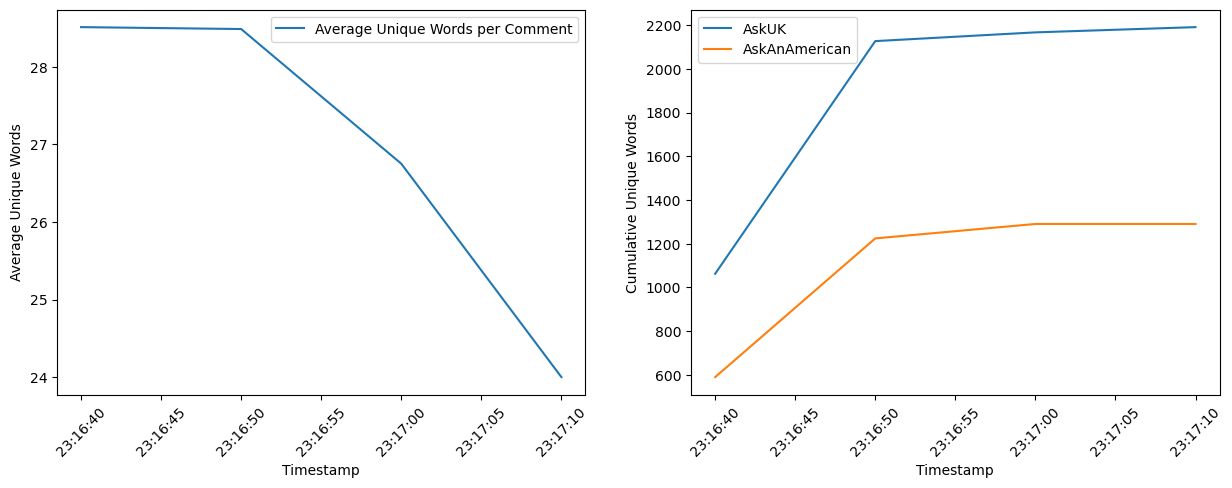

Current MAE: 23.52
----------- 2023-12-08 23:17:20 -----------
+------------------+-------+----------+--------------------+---------+-------------+-------------+
|            author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+------------------+-------+----------+--------------------+---------+-------------+-------------+
|    Typical_Ad_210|kckd6ph|   18dsn9d|Boarding school. ...|    AskUK|1.702077411E9|   1702077429|
|      scifisam2020|kckd6qe|   18d5ejx|Works out at £100...|    AskUK|1.702077411E9|   1702077429|
|Particular-Echo347|kckd7el|   18dymwu|They are so good ...|    AskUK|1.702077419E9|   1702077429|
+------------------+-------+----------+--------------------+---------+-------------+-------------+



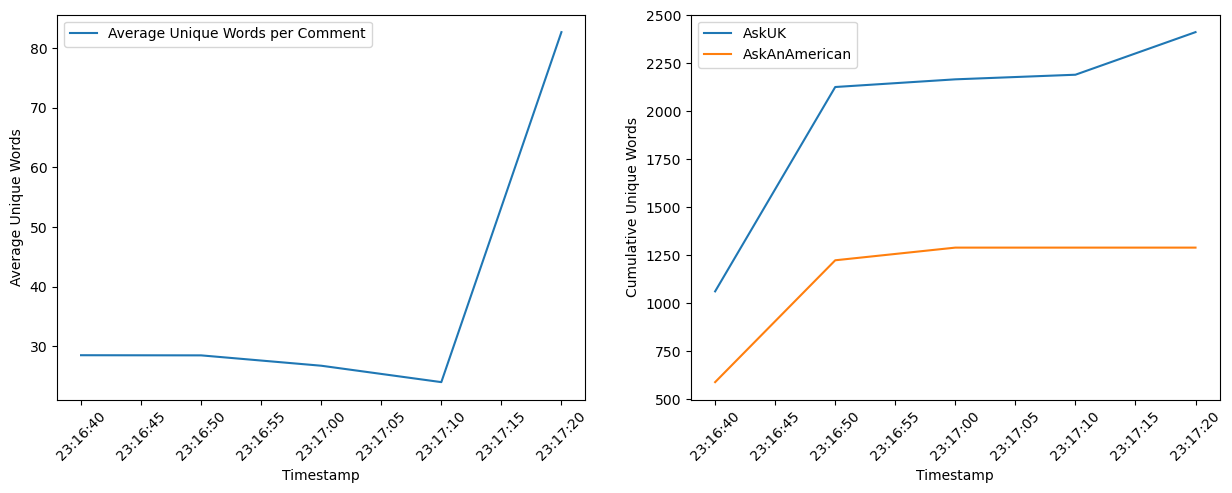

Current MAE: 78.6317936393815
----------- 2023-12-08 23:17:30 -----------
+--------------------+-------+----------+--------------------+---------+-------------+-------------+
|              author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------------+-------+----------+--------------------+---------+-------------+-------------+
|      Typical_Ad_210|kckd6ph|   18dsn9d|Boarding school. ...|    AskUK|1.702077411E9|   1702077429|
|        scifisam2020|kckd6qe|   18d5ejx|Works out at £100...|    AskUK|1.702077411E9|   1702077429|
|  Particular-Echo347|kckd7el|   18dymwu|They are so good ...|    AskUK|1.702077419E9|   1702077429|
|            JimDixon|kckd8e0|   18dw6tg|My dad, when he w...|    AskUK|1.702077431E9|   1702077448|
|        OldGrumpyHag|kckd8fb|   18dl6a5|Yep exactly, at l...|    AskUK|1.702077432E9|   1702077448|
|Admirable_Picture568|kckd8tn|   18dsn9d|Even after ration...|    AskUK|1.702077436E9|   1702077448|
+----------------

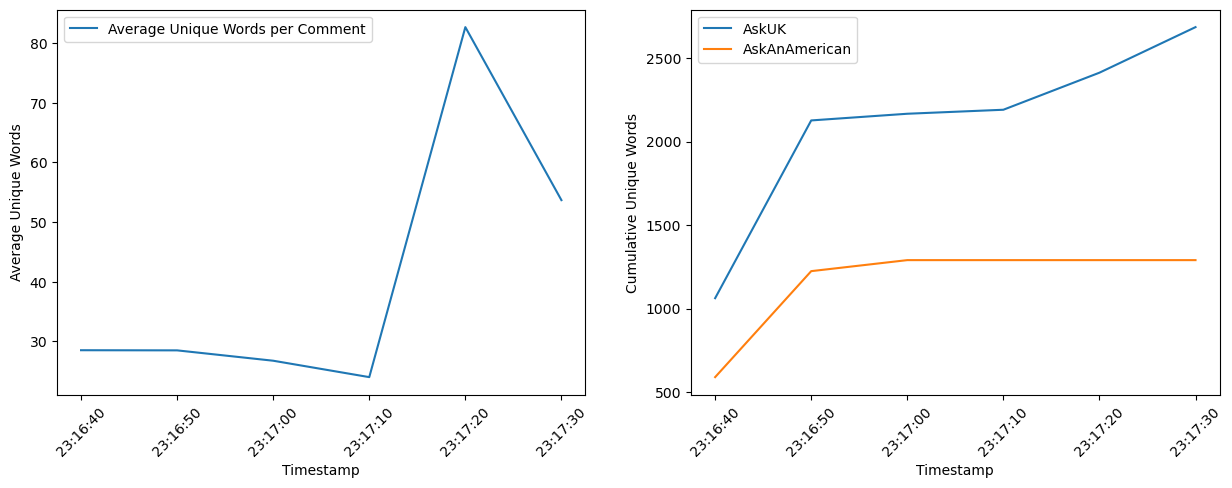

Current MAE: 47.88799153616483
----------- 2023-12-08 23:17:40 -----------
+--------------------+-------+----------+--------------------+---------+-------------+-------------+
|              author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------------+-------+----------+--------------------+---------+-------------+-------------+
|            JimDixon|kckd8e0|   18dw6tg|My dad, when he w...|    AskUK|1.702077431E9|   1702077448|
|        OldGrumpyHag|kckd8fb|   18dl6a5|Yep exactly, at l...|    AskUK|1.702077432E9|   1702077448|
|Admirable_Picture568|kckd8tn|   18dsn9d|Even after ration...|    AskUK|1.702077436E9|   1702077448|
+--------------------+-------+----------+--------------------+---------+-------------+-------------+



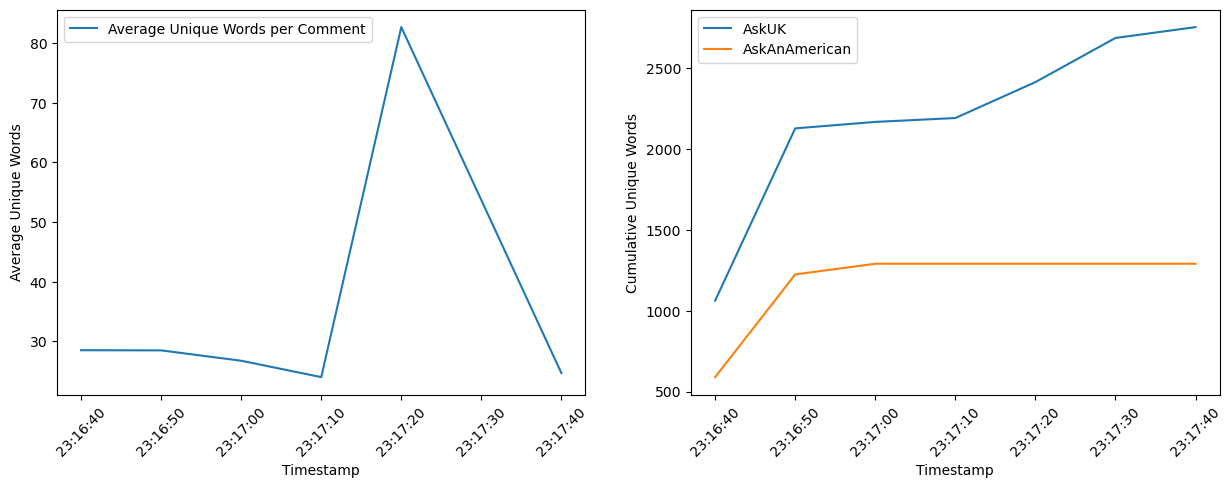

Current MAE: 23.518263422366054
----------- 2023-12-08 23:17:50 -----------
+------+-------+----------+--------------------+---------+-------------+-------------+
|author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+------+-------+----------+--------------------+---------+-------------+-------------+
| KX321|kckda7b|   18dyyid|If you're overpai...|    AskUK|1.702077453E9|   1702077465|
+------+-------+----------+--------------------+---------+-------------+-------------+



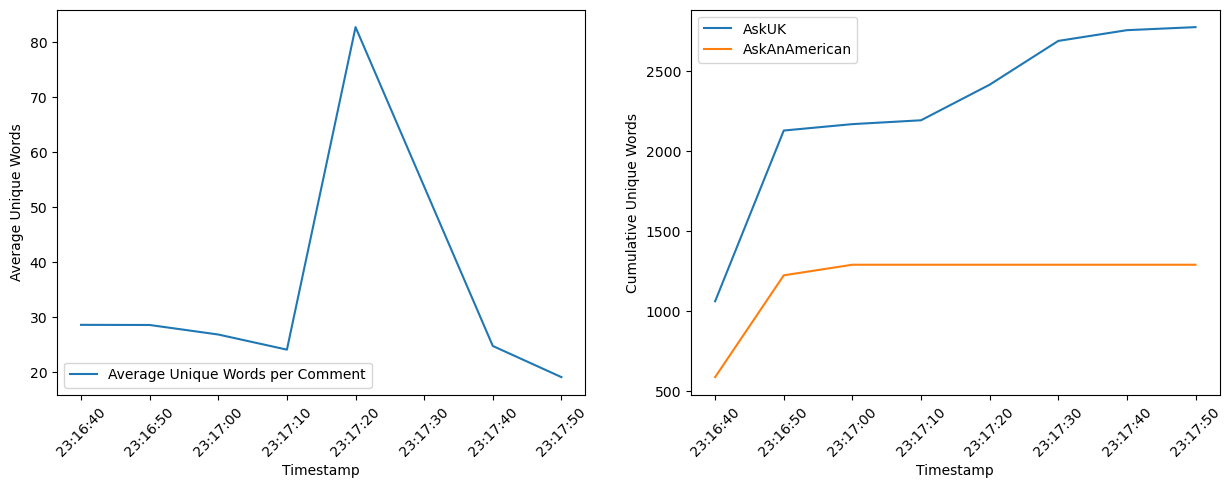

Current MAE: 18.62
----------- 2023-12-08 23:18:00 -----------
+-----------+-------+----------+--------------------+---------+-------------+-------------+
|     author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-----------+-------+----------+--------------------+---------+-------------+-------------+
|      KX321|kckda7b|   18dyyid|If you're overpai...|    AskUK|1.702077453E9|   1702077465|
|SpaceGirl34|kckdaro|   18dsn9d|Yep, think it was...|    AskUK| 1.70207746E9|   1702077470|
+-----------+-------+----------+--------------------+---------+-------------+-------------+



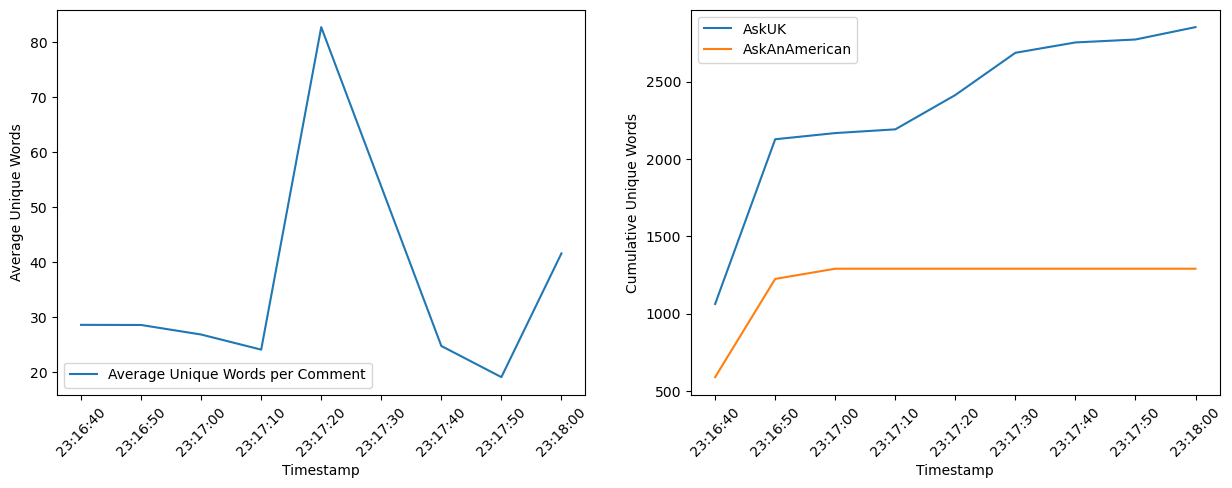

Current MAE: 39.8476
----------- 2023-12-08 23:18:10 -----------
+-------------+-------+----------+--------------------+-------------+-------------+-------------+
|       author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-------------+-------+----------+--------------------+-------------+-------------+-------------+
|  SpaceGirl34|kckdaro|   18dsn9d|Yep, think it was...|        AskUK| 1.70207746E9|   1702077470|
|spleenboggler|kckdbqh|   18dc7u4|*forehead slap*\n...|AskAnAmerican|1.702077471E9|   1702077487|
|    _shagger_|kckdbtp|   18dlx5a|Sometimes it does...|        AskUK|1.702077473E9|   1702077487|
+-------------+-------+----------+--------------------+-------------+-------------+-------------+



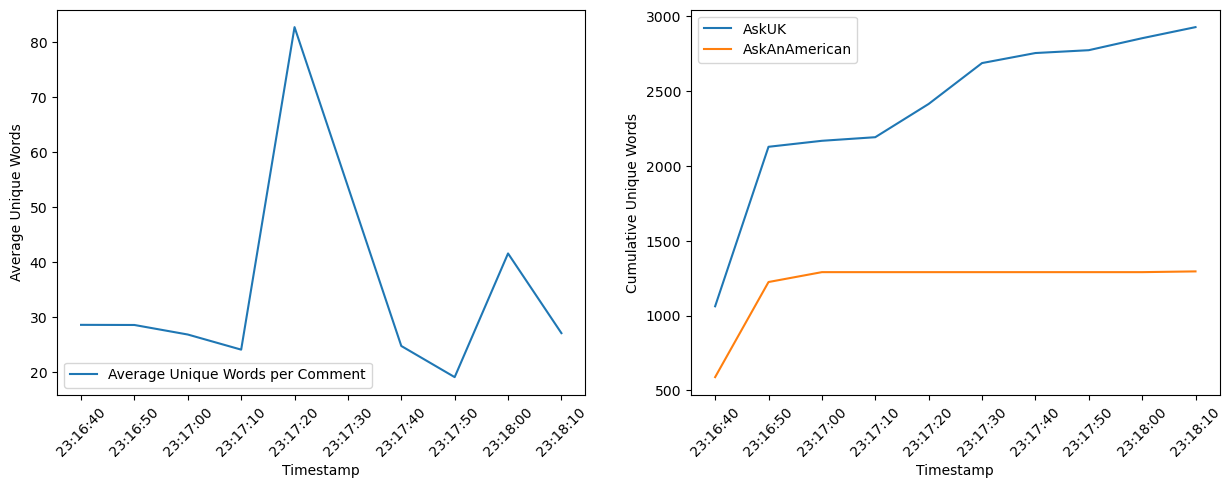

Current MAE: 25.535539620943197
----------- 2023-12-08 23:18:20 -----------
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|        author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
| spleenboggler|kckdbqh|   18dc7u4|*forehead slap*\n...|AskAnAmerican|1.702077471E9|   1702077487|
|     _shagger_|kckdbtp|   18dlx5a|Sometimes it does...|        AskUK|1.702077473E9|   1702077487|
|      ATSOAS87|kckdcfn|   18dsn9d|Reading through t...|        AskUK| 1.70207748E9|   1702077492|
|Heavy_Messing1|kckdcij|   18dw6tg|" It 'ave 'ad the...|        AskUK|1.702077481E9|   1702077492|
|  TheFalconKid|kckdcw5|   18dqkjh|Anywhere that has...|AskAnAmerican|1.702077486E9|   1702077496|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+



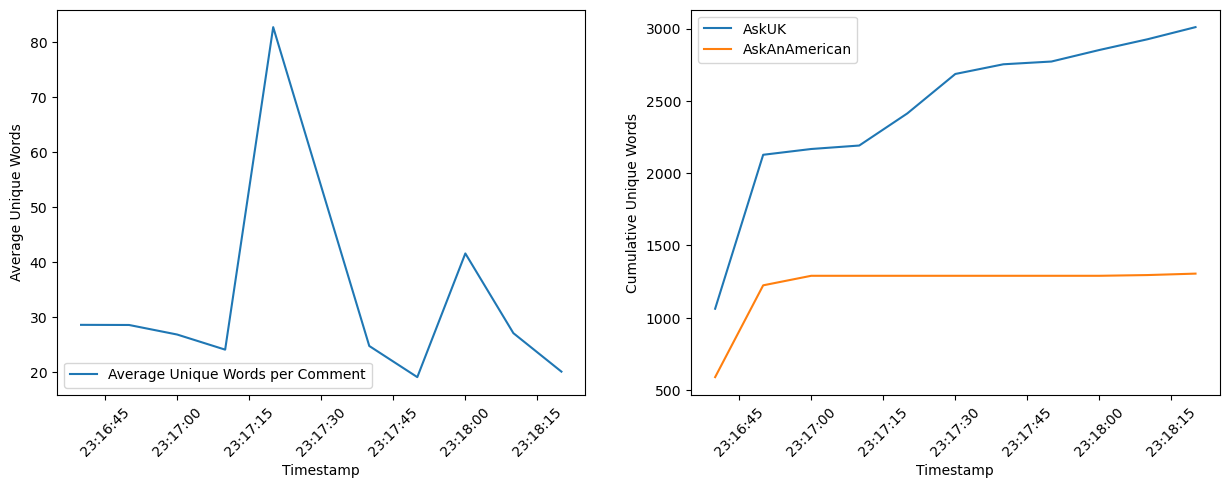

Current MAE: 18.34698639324984
----------- 2023-12-08 23:18:30 -----------
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|        author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|      ATSOAS87|kckdcfn|   18dsn9d|Reading through t...|        AskUK| 1.70207748E9|   1702077492|
|Heavy_Messing1|kckdcij|   18dw6tg|" It 'ave 'ad the...|        AskUK|1.702077481E9|   1702077492|
|  TheFalconKid|kckdcw5|   18dqkjh|Anywhere that has...|AskAnAmerican|1.702077486E9|   1702077496|
|   Agamemnon66|kckddh0|   18dvuvc|That is true. Unf...|AskAnAmerican|1.702077493E9|   1702077505|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+



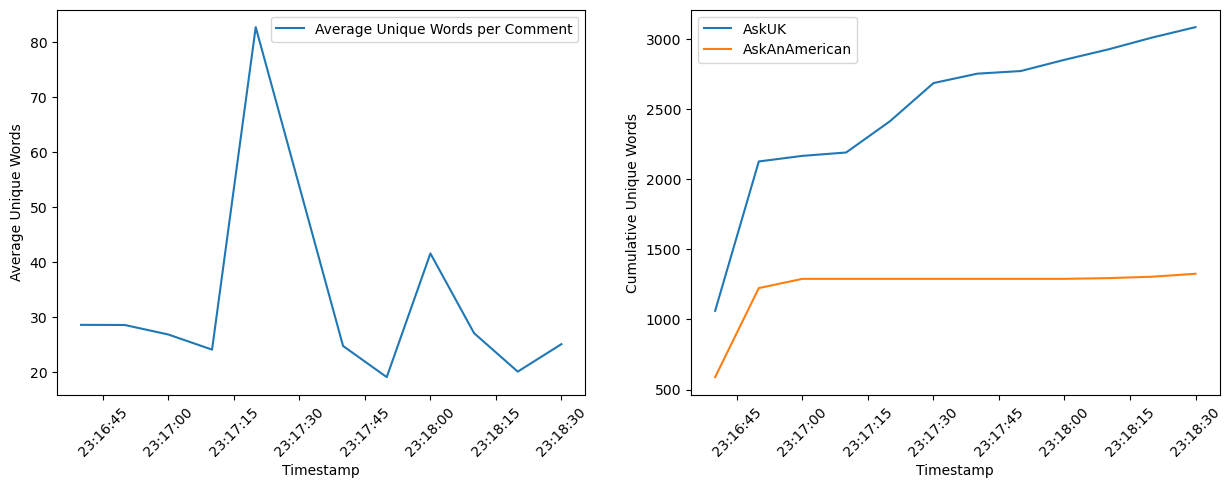

Current MAE: 23.661485408800896
----------- 2023-12-08 23:18:40 -----------
+-----------+-------+----------+--------------------+-------------+-------------+-------------+
|     author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-----------+-------+----------+--------------------+-------------+-------------+-------------+
|Agamemnon66|kckddh0|   18dvuvc|That is true. Unf...|AskAnAmerican|1.702077493E9|   1702077505|
|adaminaudio|kckddvb|   18dymwu|John Peel did hel...|        AskUK|1.702077498E9|   1702077510|
+-----------+-------+----------+--------------------+-------------+-------------+-------------+



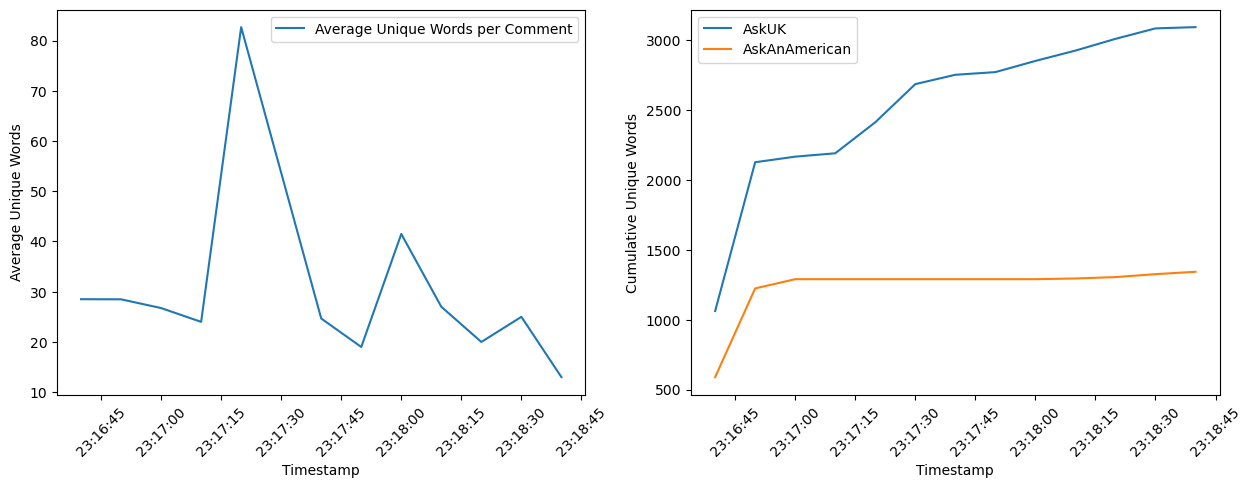

Current MAE: 12.486799999999999
----------- 2023-12-08 23:18:50 -----------
+-----------+-------+----------+--------------------+---------+-------------+-------------+
|     author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-----------+-------+----------+--------------------+---------+-------------+-------------+
|adaminaudio|kckddvb|   18dymwu|John Peel did hel...|    AskUK|1.702077498E9|   1702077510|
+-----------+-------+----------+--------------------+---------+-------------+-------------+



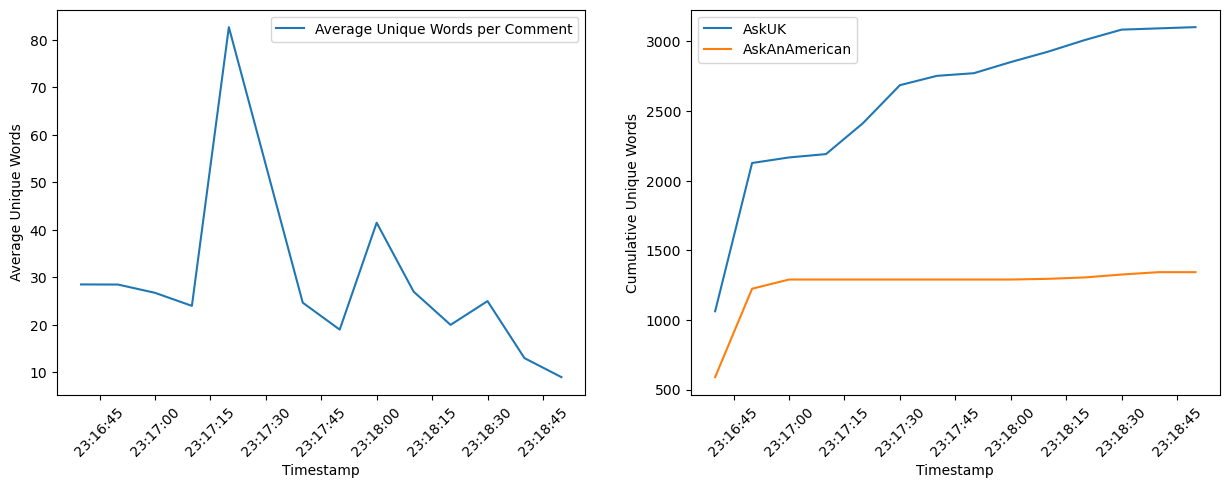

Current MAE: 8.82
----------- 2023-12-08 23:19:00 -----------
Error: RDD is empty
----------- 2023-12-08 23:19:10 -----------
+------+-------+----------+--------------------+---------+-------------+-------------+
|author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+------+-------+----------+--------------------+---------+-------------+-------------+
|zampyx|kckdg2n|   18dl6a5|Houses (and build...|    AskUK|1.702077524E9|   1702077545|
+------+-------+----------+--------------------+---------+-------------+-------------+



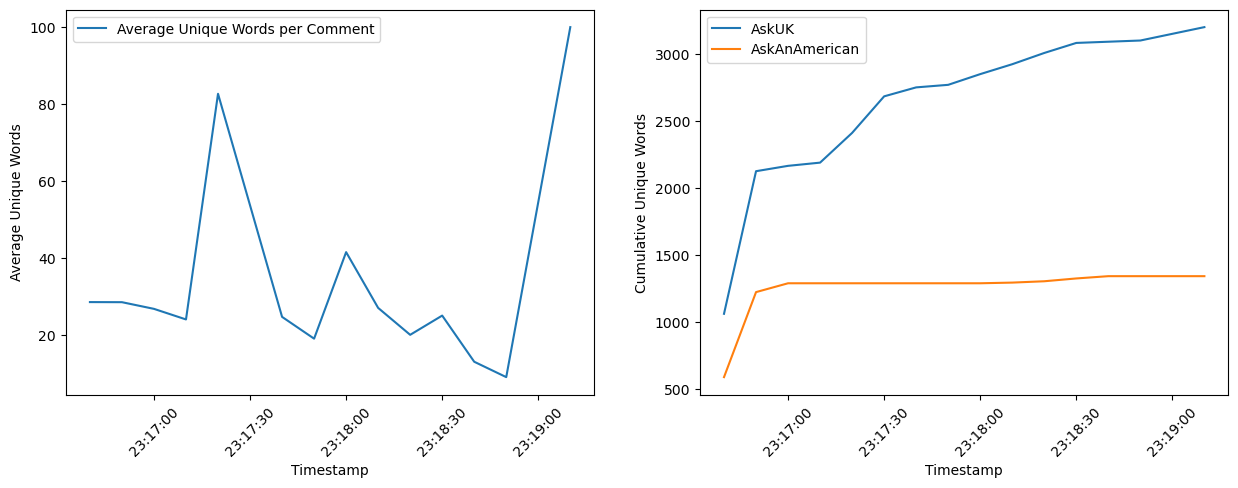

Current MAE: 98.0
----------- 2023-12-08 23:19:20 -----------
+------+-------+----------+--------------------+---------+-------------+-------------+
|author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+------+-------+----------+--------------------+---------+-------------+-------------+
|zampyx|kckdg2n|   18dl6a5|Houses (and build...|    AskUK|1.702077524E9|   1702077545|
+------+-------+----------+--------------------+---------+-------------+-------------+



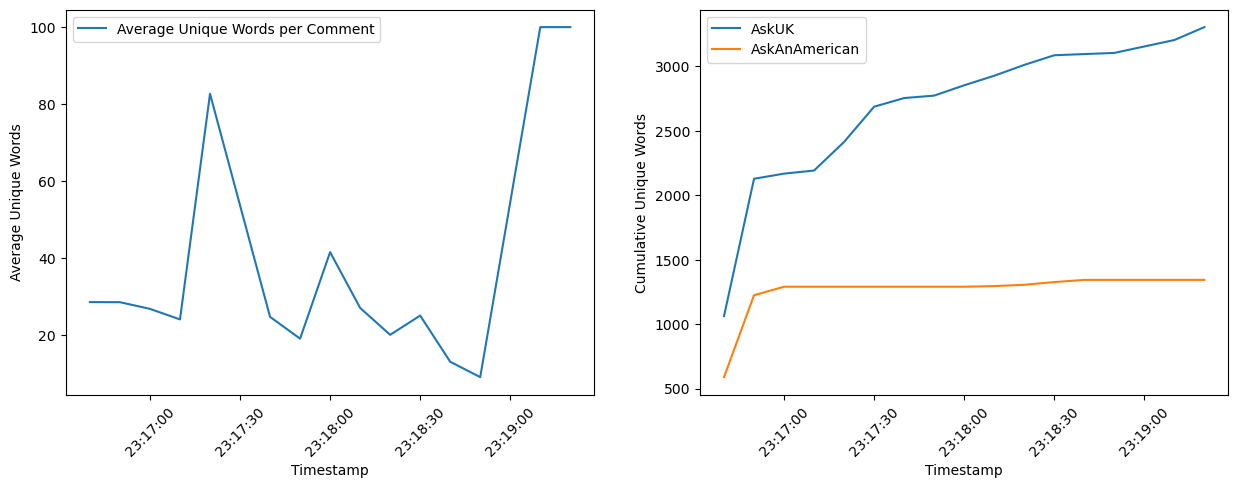

Current MAE: 98.0
----------- 2023-12-08 23:19:30 -----------
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+
|             author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+
|      nogeologyhere|kckdhy0|   18ds9gj|I despair. It fee...|        AskUK|1.702077547E9|   1702077563|
|ardcorewillneverdie|kckdi0l|   18dw6tg|If there was ever...|        AskUK|1.702077548E9|   1702077563|
|CrimpsShootsandRuns|kckdibp|   18dla4b|Lake District, to...|        AskUK|1.702077551E9|   1702077563|
|          blackhaz2|kckdikm|   18dl6a5|Two separate taps...|        AskUK|1.702077554E9|   1702077565|
|           CalDavid|kckdilb|   18dvmk1|No red states. Se...|AskAnAmerican|1.702077554E9|   1702077565|
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+



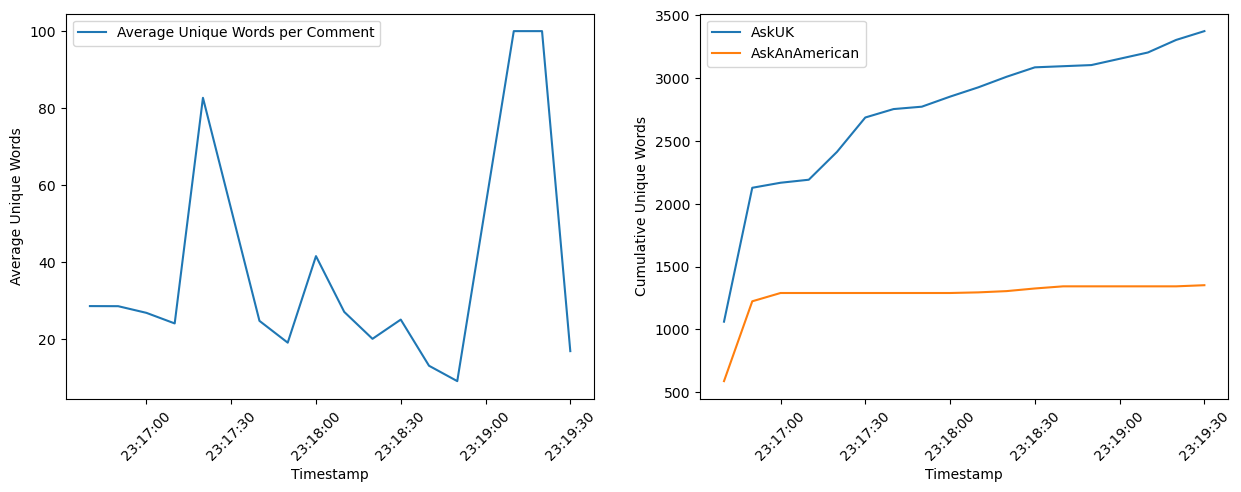

Current MAE: 15.64756347513317
----------- 2023-12-08 23:19:40 -----------
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+
|             author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+
|      nogeologyhere|kckdhy0|   18ds9gj|I despair. It fee...|        AskUK|1.702077547E9|   1702077563|
|ardcorewillneverdie|kckdi0l|   18dw6tg|If there was ever...|        AskUK|1.702077548E9|   1702077563|
|CrimpsShootsandRuns|kckdibp|   18dla4b|Lake District, to...|        AskUK|1.702077551E9|   1702077563|
|          blackhaz2|kckdikm|   18dl6a5|Two separate taps...|        AskUK|1.702077554E9|   1702077565|
|           CalDavid|kckdilb|   18dvmk1|No red states. Se...|AskAnAmerican|1.702077554E9|   1702077565|
+-------------------+-------+----------+--------------------+-------------+-------------+----

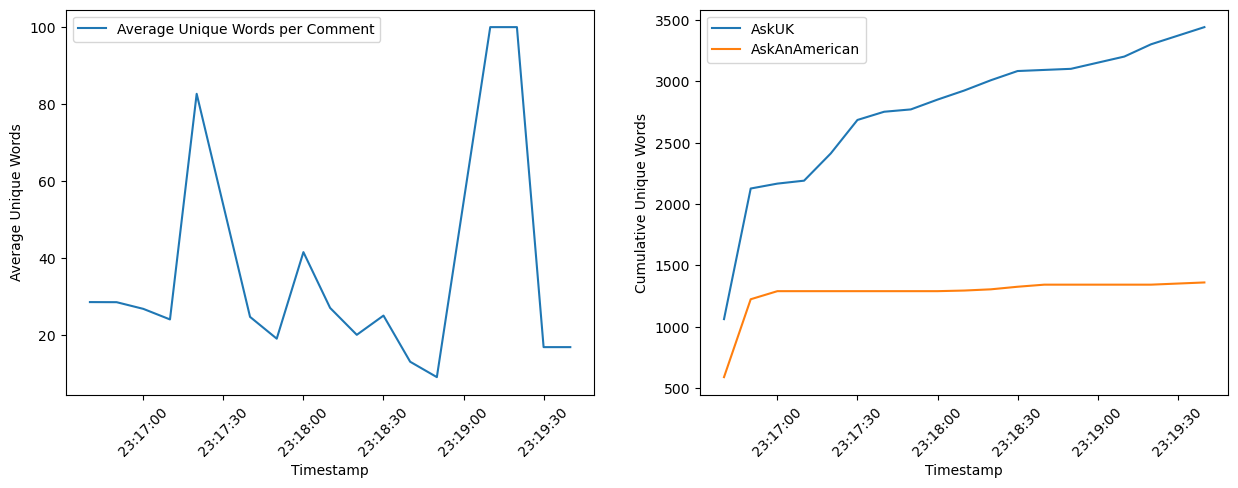

Current MAE: 15.64756347513317
----------- 2023-12-08 23:19:50 -----------
+------+-------+----------+--------------------+-------------+------------+-------------+
|author|     id|submission|                body|    subreddit| created_utc|collected_utc|
+------+-------+----------+--------------------+-------------+------------+-------------+
|Xhfdgb|kckdjvy|   18dvyqh|I'm from Ohio, vi...|AskAnAmerican|1.70207757E9|   1702077583|
+------+-------+----------+--------------------+-------------+------------+-------------+



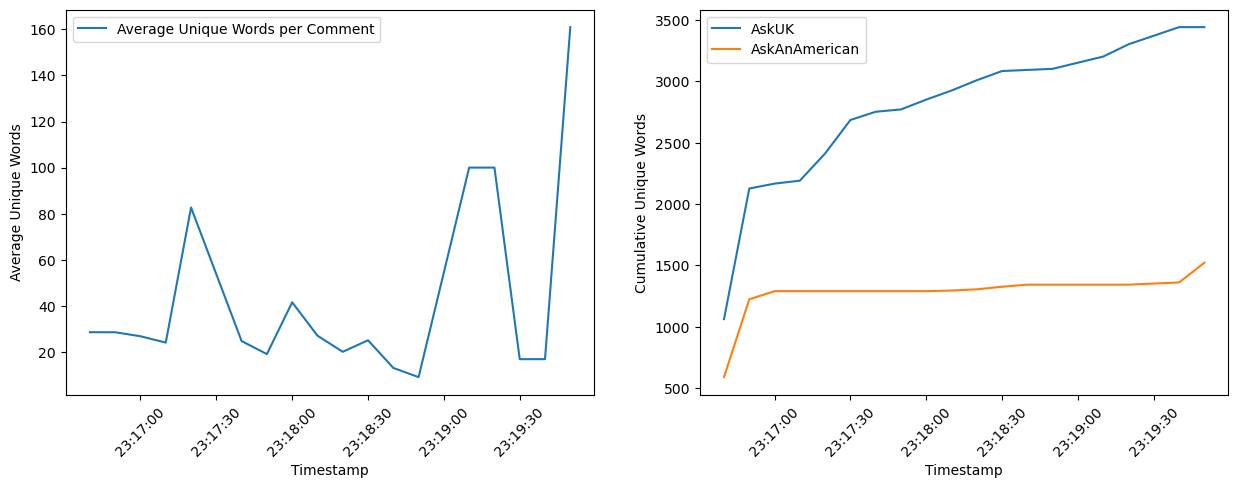

Current MAE: 157.78
----------- 2023-12-08 23:20:00 -----------
+------+-------+----------+--------------------+-------------+------------+-------------+
|author|     id|submission|                body|    subreddit| created_utc|collected_utc|
+------+-------+----------+--------------------+-------------+------------+-------------+
|Xhfdgb|kckdjvy|   18dvyqh|I'm from Ohio, vi...|AskAnAmerican|1.70207757E9|   1702077583|
+------+-------+----------+--------------------+-------------+------------+-------------+



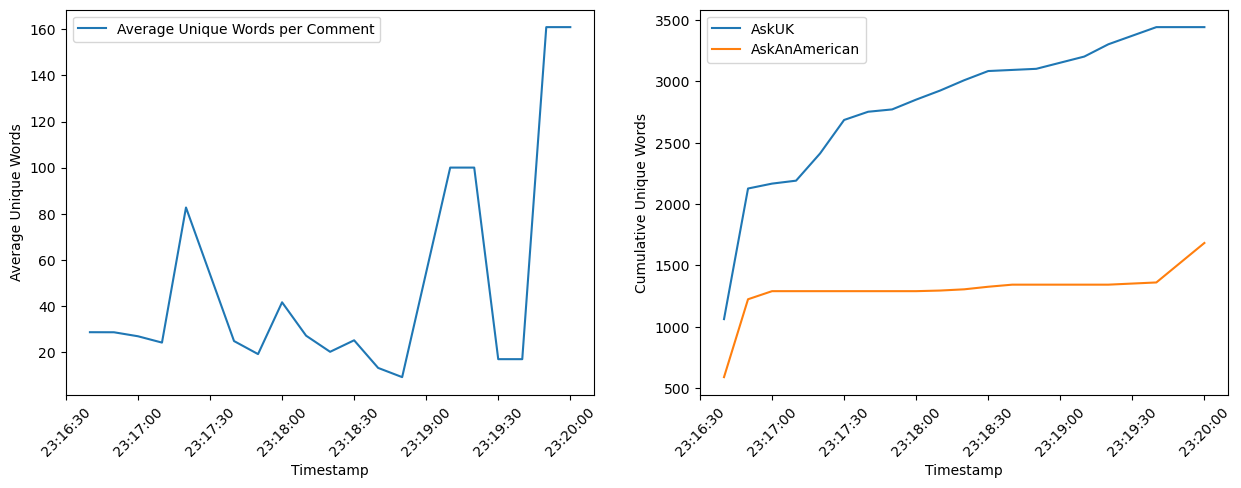

Current MAE: 157.78
----------- 2023-12-08 23:20:10 -----------
+------------------+-------+----------+--------------------+---------+-------------+-------------+
|            author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+------------------+-------+----------+--------------------+---------+-------------+-------------+
|     nogeologyhere|kckdlej|   18ds9gj|       You're a cunr|    AskUK|1.702077588E9|   1702077600|
|blankettripod32_v2|kckdly3|   18c37u9|For free I mean t...|    AskUK|1.702077595E9|   1702077606|
|     tinasnow-poty|kckdm16|   18dlx5a|Not Hungarian but...|    AskUK|1.702077596E9|   1702077606|
+------------------+-------+----------+--------------------+---------+-------------+-------------+



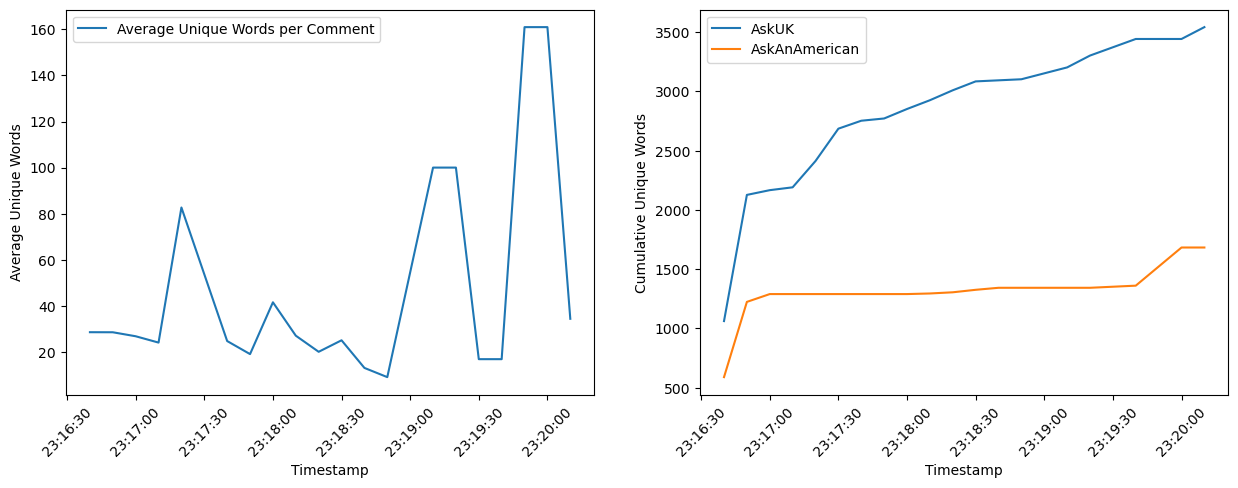

Current MAE: 32.182034292940145
----------- 2023-12-08 23:20:20 -----------
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+
|             author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+
|      nogeologyhere|kckdlej|   18ds9gj|       You're a cunr|        AskUK|1.702077588E9|   1702077600|
| blankettripod32_v2|kckdly3|   18c37u9|For free I mean t...|        AskUK|1.702077595E9|   1702077606|
|      tinasnow-poty|kckdm16|   18dlx5a|Not Hungarian but...|        AskUK|1.702077596E9|   1702077606|
|GeorgeWhorewell1894|kckdml3|   18dlw4o|I don't agree wit...|AskAnAmerican|1.702077602E9|   1702077615|
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+



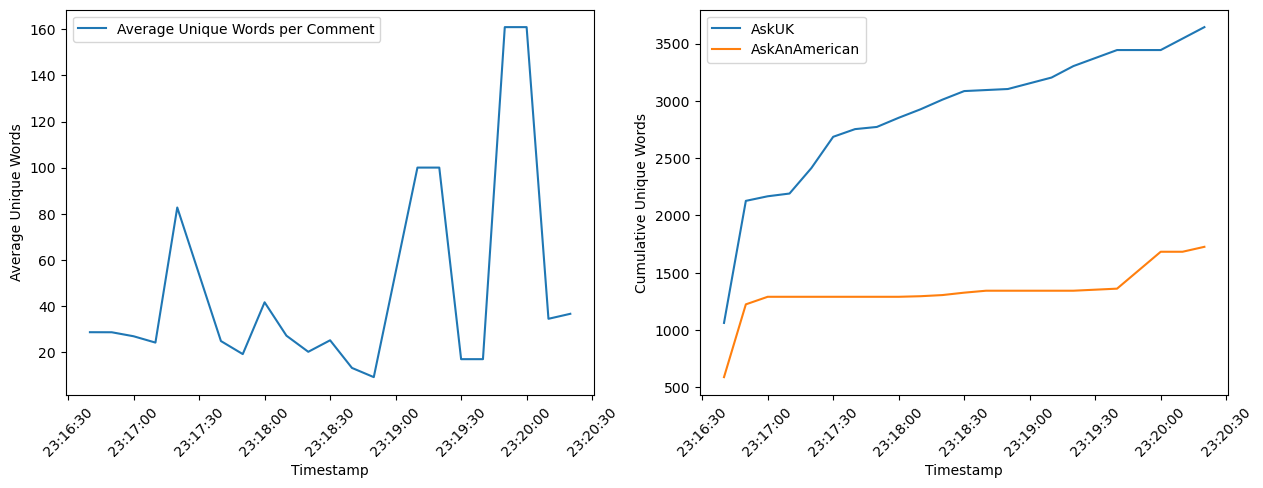

Current MAE: 33.99219283246225
----------- 2023-12-08 23:20:30 -----------
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+
|             author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+
|GeorgeWhorewell1894|kckdml3|   18dlw4o|I don't agree wit...|AskAnAmerican|1.702077602E9|   1702077615|
|          bosso_biz|kckdn71|   18dl6a5|Same! It was so a...|        AskUK|1.702077609E9|   1702077619|
+-------------------+-------+----------+--------------------+-------------+-------------+-------------+



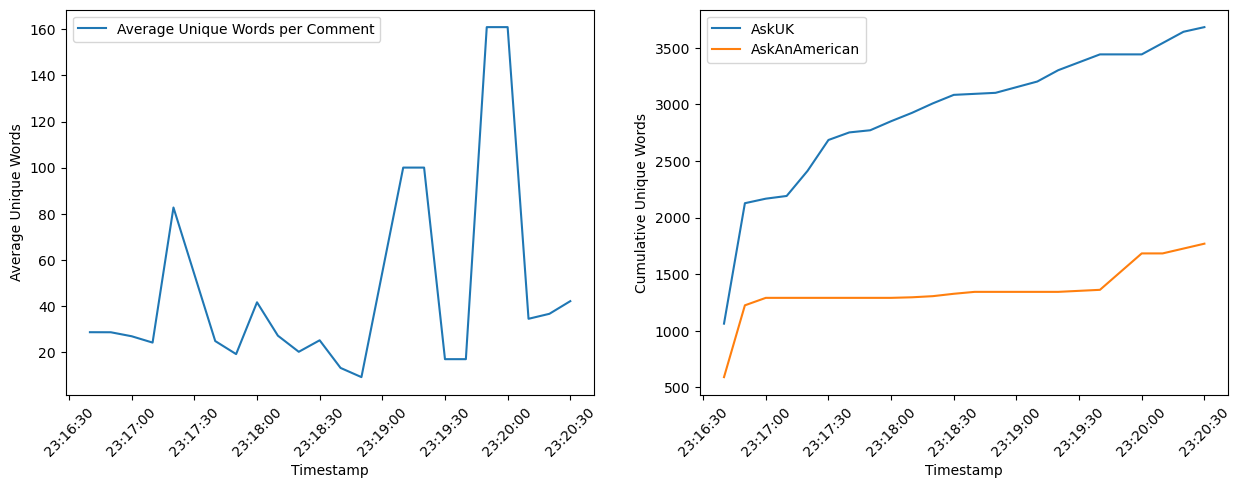

Current MAE: 40.337199999999996
----------- 2023-12-08 23:20:40 -----------
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|          author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|       bosso_biz|kckdn71|   18dl6a5|Same! It was so a...|    AskUK|1.702077609E9|   1702077619|
|Practice-Regular|kckdo1r|   18dtgek|Considering they’...|    AskUK|1.702077619E9|   1702077637|
| PedantOfGrammar|kckdohd|   18dai0o|~~hence why~~\n\n...|    AskUK|1.702077625E9|   1702077637|
|   GlobbyChipOil|kckdojo|   18dkld7|Same and for some...|    AskUK|1.702077625E9|   1702077637|
+----------------+-------+----------+--------------------+---------+-------------+-------------+



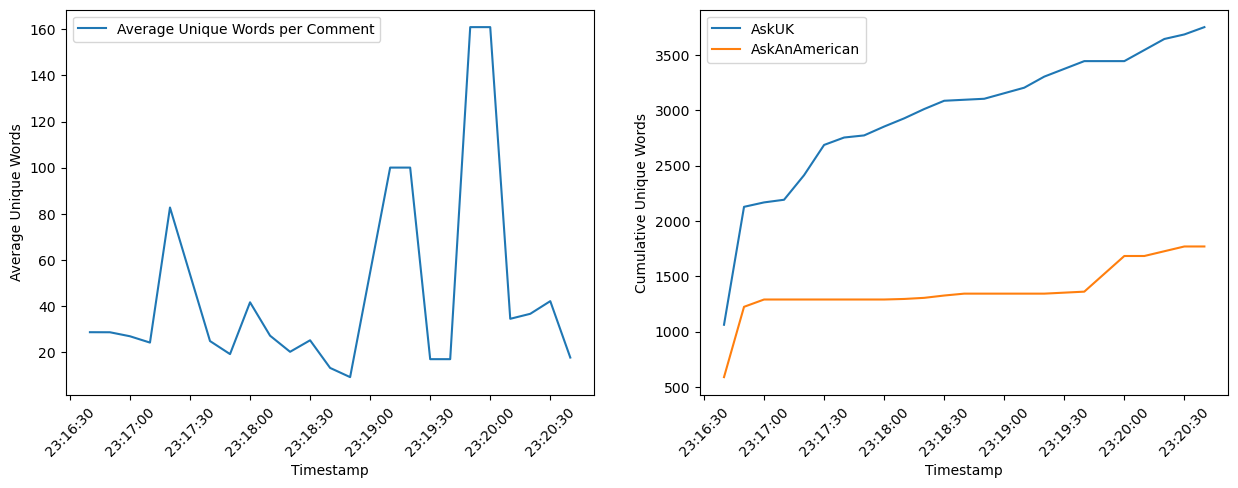

Current MAE: 16.150407832376608
----------- 2023-12-08 23:20:50 -----------
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|          author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|Practice-Regular|kckdo1r|   18dtgek|Considering they’...|    AskUK|1.702077619E9|   1702077637|
| PedantOfGrammar|kckdohd|   18dai0o|~~hence why~~\n\n...|    AskUK|1.702077625E9|   1702077637|
|   GlobbyChipOil|kckdojo|   18dkld7|Same and for some...|    AskUK|1.702077625E9|   1702077637|
+----------------+-------+----------+--------------------+---------+-------------+-------------+



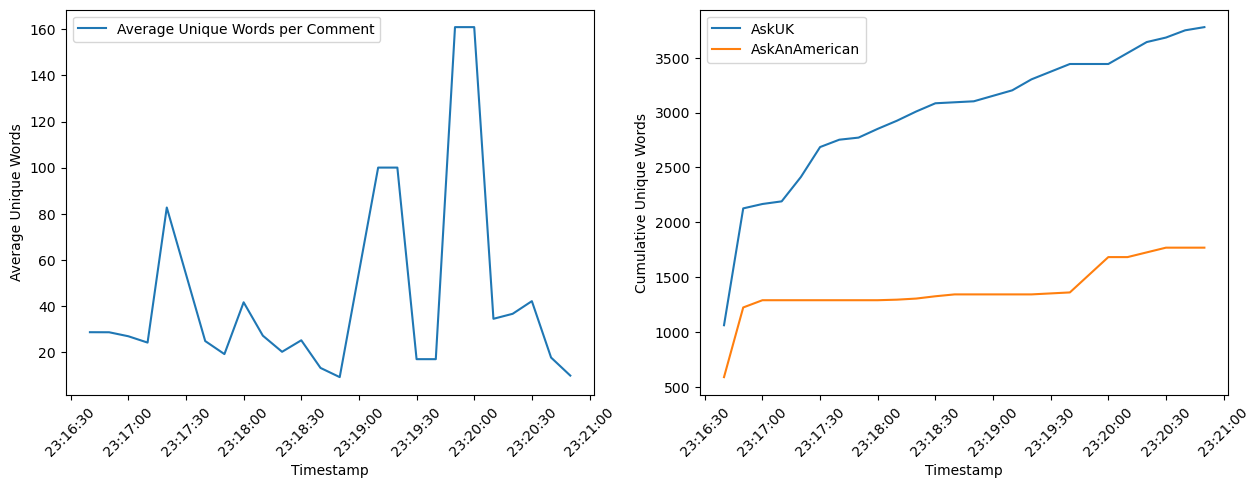

Current MAE: 9.106401381148757
----------- 2023-12-08 23:21:00 -----------
+-------+-------+----------+--------------------+---------+-------------+-------------+
| author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-------+-------+----------+--------------------+---------+-------------+-------------+
|Ttekerz|kckdq5g|   18dymwu|I really think th...|    AskUK|1.702077645E9|   1702077655|
+-------+-------+----------+--------------------+---------+-------------+-------------+



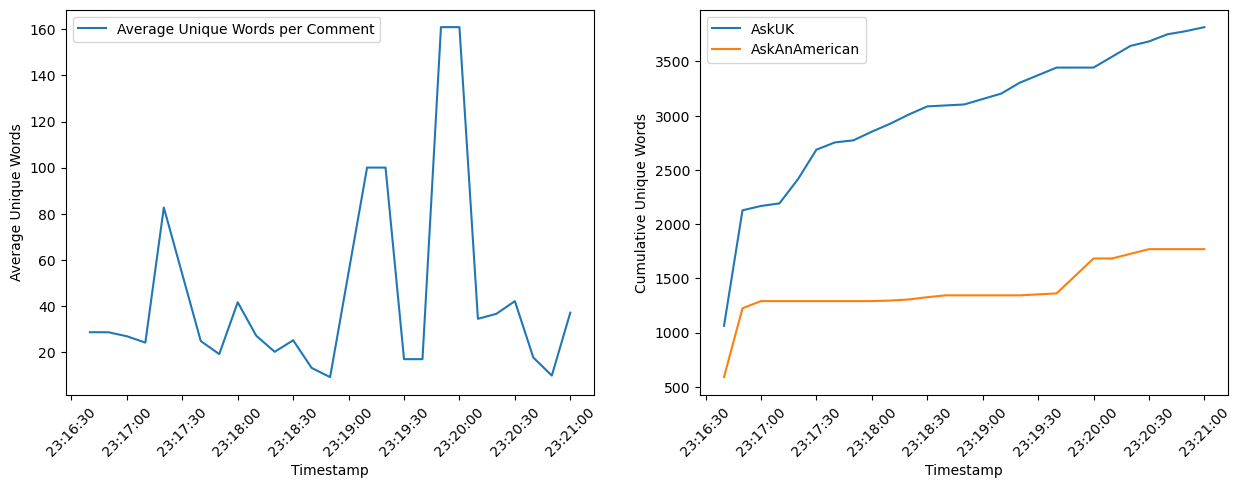

Current MAE: 36.26
----------- 2023-12-08 23:21:10 -----------
+-----------------+-------+----------+--------------------+-------------+-------------+-------------+
|           author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-----------------+-------+----------+--------------------+-------------+-------------+-------------+
|          Ttekerz|kckdq5g|   18dymwu|I really think th...|        AskUK|1.702077645E9|   1702077655|
|            eloco|kckdqwu|   18dxlv3|There’s a string ...|AskAnAmerican|1.702077654E9|   1702077665|
|PuzzleheadedAd822|kckdqxq|   18dl6a5|You may want to l...|        AskUK|1.702077654E9|   1702077665|
|     Wrong_Ad_736|kckdr1e|   18ds9gj|     It's disgusting|        AskUK|1.702077655E9|   1702077665|
+-----------------+-------+----------+--------------------+-------------+-------------+-------------+



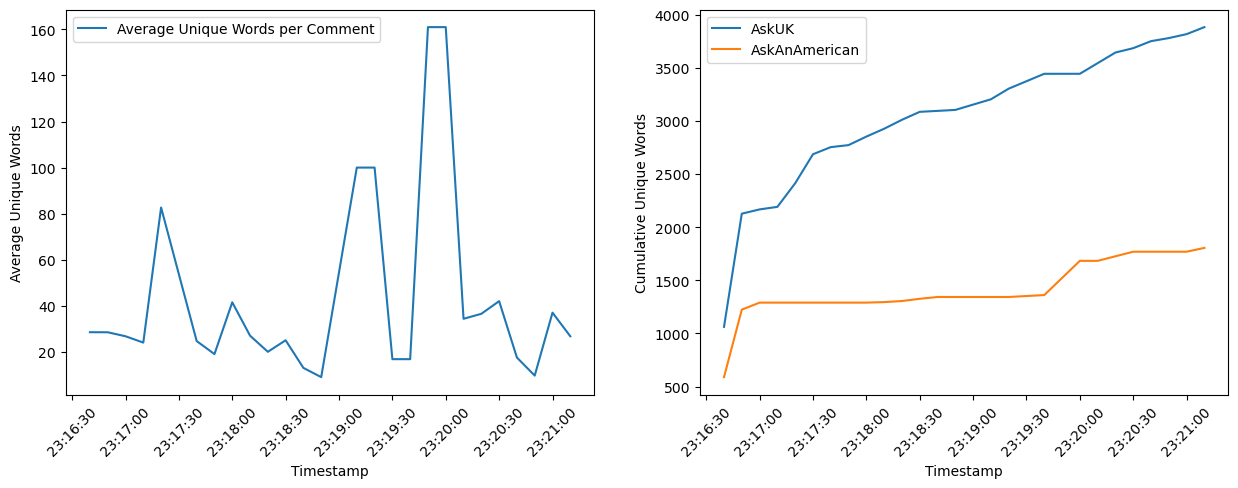

Current MAE: 25.171690088682634
----------- 2023-12-08 23:21:20 -----------
+-----------------+-------+----------+--------------------+-------------+-------------+-------------+
|           author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-----------------+-------+----------+--------------------+-------------+-------------+-------------+
|            eloco|kckdqwu|   18dxlv3|There’s a string ...|AskAnAmerican|1.702077654E9|   1702077665|
|PuzzleheadedAd822|kckdqxq|   18dl6a5|You may want to l...|        AskUK|1.702077654E9|   1702077665|
|     Wrong_Ad_736|kckdr1e|   18ds9gj|     It's disgusting|        AskUK|1.702077655E9|   1702077665|
|   islandhopper37|kckdrak|   18c4wgs|[https://youtu.be...|        AskUK|1.702077659E9|   1702077670|
| AverageCheap4990|kckdrsn|   18dyvah|Arsanel football ...|        AskUK|1.702077665E9|   1702077679|
+-----------------+-------+----------+--------------------+-------------+-------------+-------------+



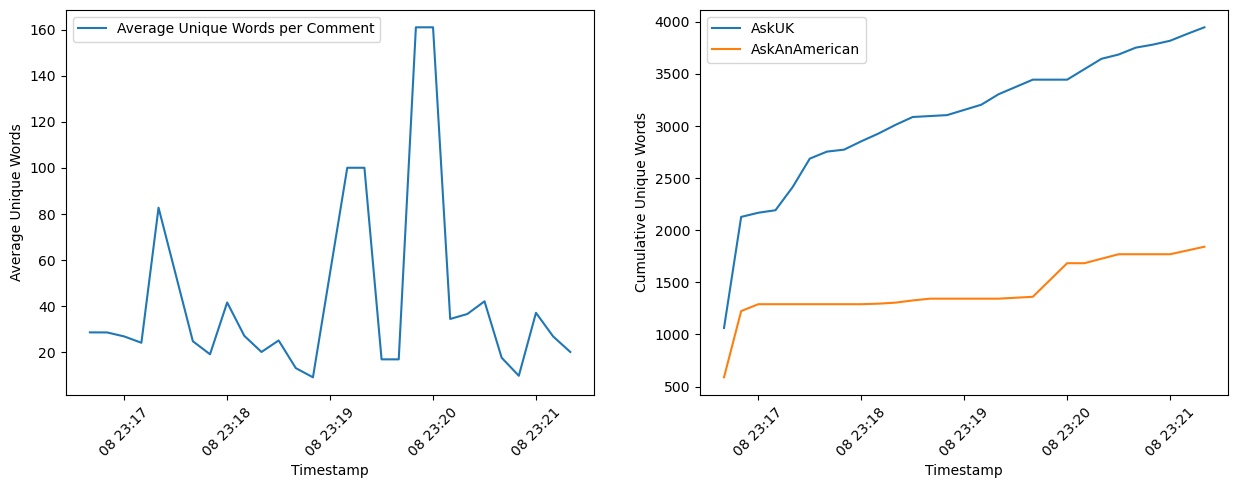

Current MAE: 18.67903218005374
----------- 2023-12-08 23:21:30 -----------
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|          author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|  islandhopper37|kckdrak|   18c4wgs|[https://youtu.be...|    AskUK|1.702077659E9|   1702077670|
|AverageCheap4990|kckdrsn|   18dyvah|Arsanel football ...|    AskUK|1.702077665E9|   1702077679|
| The_Forgemaster|kckdsgl|   18dvkc3|I need some soree...|    AskUK|1.702077673E9|   1702077688|
|    OldGrumpyHag|kckdsm2|   18dl6a5|One of the many r...|    AskUK|1.702077675E9|   1702077688|
|       _shagger_|kckdsnk|   18dvkc3|Is better with ch...|    AskUK|1.702077675E9|   1702077688|
+----------------+-------+----------+--------------------+---------+-------------+-------------+



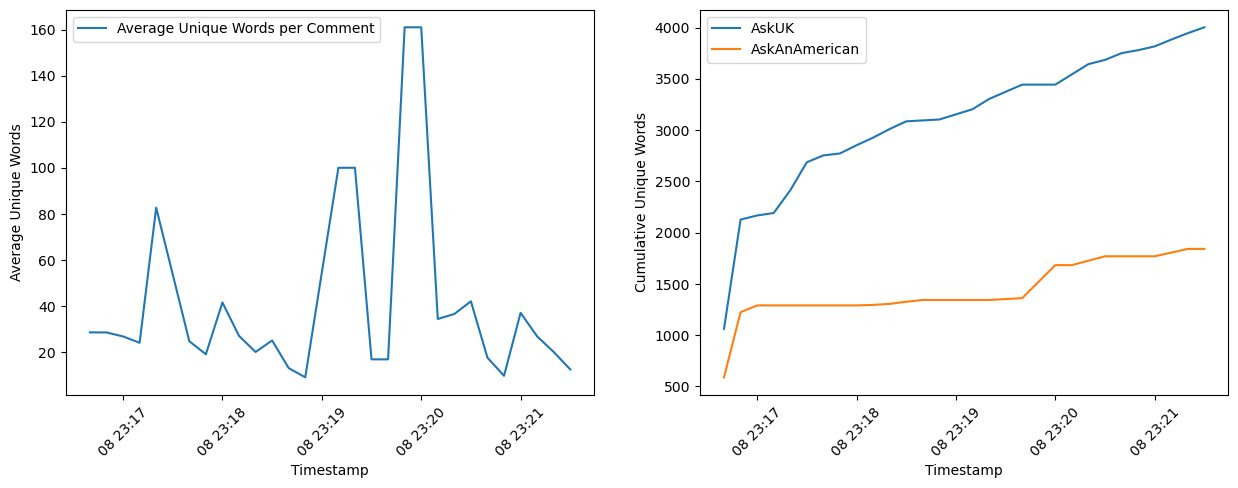

Current MAE: 11.702573613539116
----------- 2023-12-08 23:21:40 -----------
+-------------------+-------+----------+--------------------+---------+-------------+-------------+
|             author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-------------------+-------+----------+--------------------+---------+-------------+-------------+
|    The_Forgemaster|kckdsgl|   18dvkc3|I need some soree...|    AskUK|1.702077673E9|   1702077688|
|       OldGrumpyHag|kckdsm2|   18dl6a5|One of the many r...|    AskUK|1.702077675E9|   1702077688|
|          _shagger_|kckdsnk|   18dvkc3|Is better with ch...|    AskUK|1.702077675E9|   1702077688|
|Maleficent-Item4833|kckdt9n|   18d24bf|It’s a long game ...|    AskUK|1.702077683E9|   1702077697|
+-------------------+-------+----------+--------------------+---------+-------------+-------------+



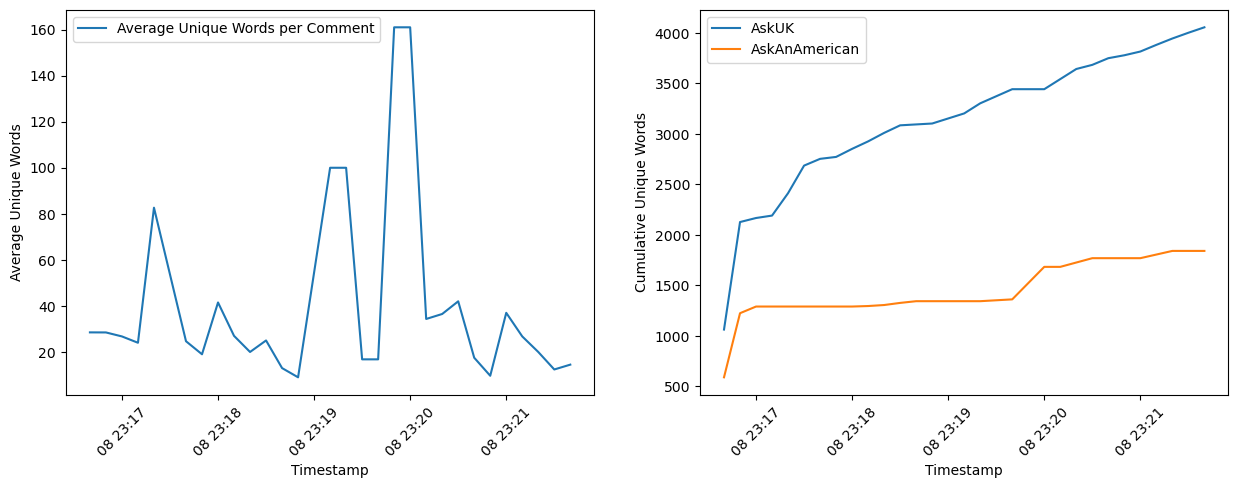

Current MAE: 13.522058088016053
----------- 2023-12-08 23:21:50 -----------
+-------------------+-------+----------+--------------------+---------+-------------+-------------+
|             author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-------------------+-------+----------+--------------------+---------+-------------+-------------+
|Maleficent-Item4833|kckdt9n|   18d24bf|It’s a long game ...|    AskUK|1.702077683E9|   1702077697|
|   On_The_Blindside|kckdu5i|   18dyyid|Similar thing has...|    AskUK|1.702077694E9|   1702077706|
+-------------------+-------+----------+--------------------+---------+-------------+-------------+



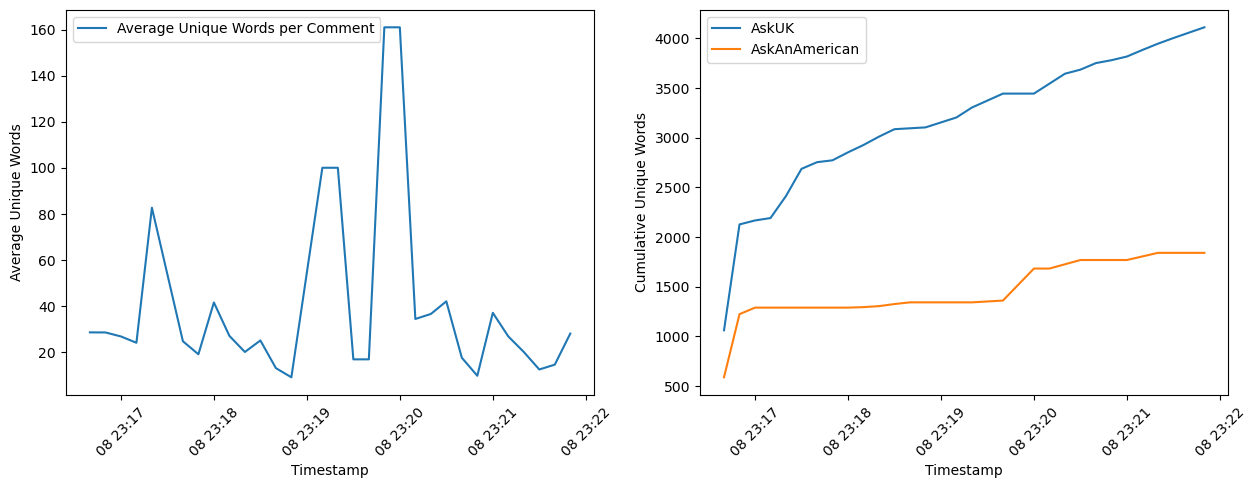

Current MAE: 26.8904
----------- 2023-12-08 23:22:00 -----------
+----------------+-------+----------+--------------------+-------------+-------------+-------------+
|          author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+-------------+-------------+-------------+
|On_The_Blindside|kckdu5i|   18dyyid|Similar thing has...|        AskUK|1.702077694E9|   1702077706|
|      majorlicks|kckdut6|   18dj6n9|   Yes, a britvic 55|        AskUK|1.702077701E9|   1702077715|
|    TortoiseSlap|kckdv0q|   18dw6tg|         Poop knife.|        AskUK|1.702077704E9|   1702077715|
|           01WS6|kckdv7x|   18dtewi|>I am in my early...|AskAnAmerican|1.702077707E9|   1702077716|
+----------------+-------+----------+--------------------+-------------+-------------+-------------+



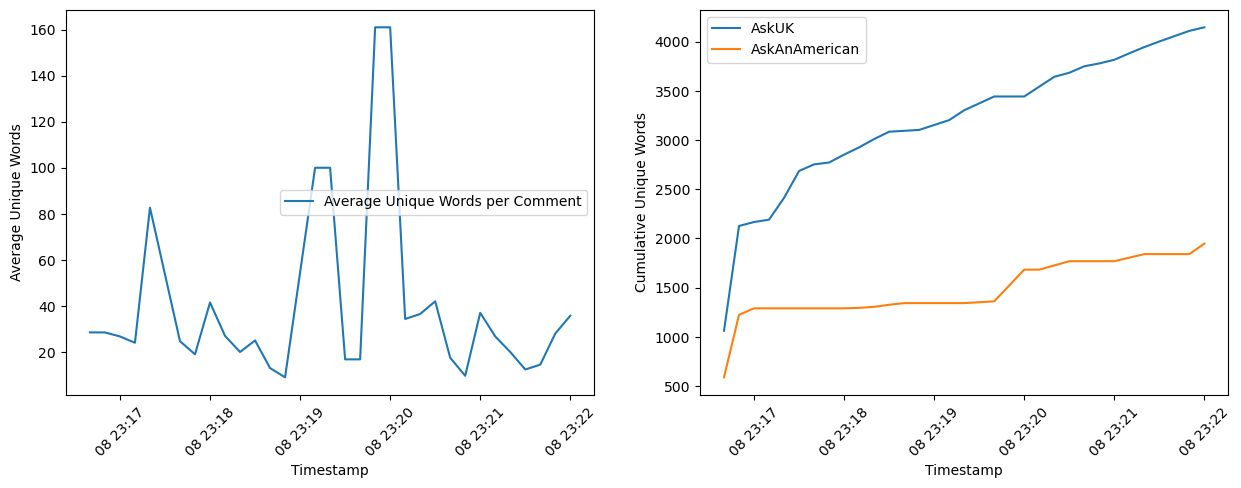

Current MAE: 33.02154179955846
----------- 2023-12-08 23:22:10 -----------
+---------------+-------+----------+--------------------+-------------+-------------+-------------+
|         author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+---------------+-------+----------+--------------------+-------------+-------------+-------------+
|     majorlicks|kckdut6|   18dj6n9|   Yes, a britvic 55|        AskUK|1.702077701E9|   1702077715|
|   TortoiseSlap|kckdv0q|   18dw6tg|         Poop knife.|        AskUK|1.702077704E9|   1702077715|
|          01WS6|kckdv7x|   18dtewi|>I am in my early...|AskAnAmerican|1.702077707E9|   1702077716|
|hoksworthwipple|kckdvk5|   18dvkc3|It's called malt ...|        AskUK|1.702077711E9|   1702077721|
|      AliAskari|kckdvs9|   18dyvah|              Anusol|        AskUK|1.702077713E9|   1702077725|
+---------------+-------+----------+--------------------+-------------+-------------+-------------+



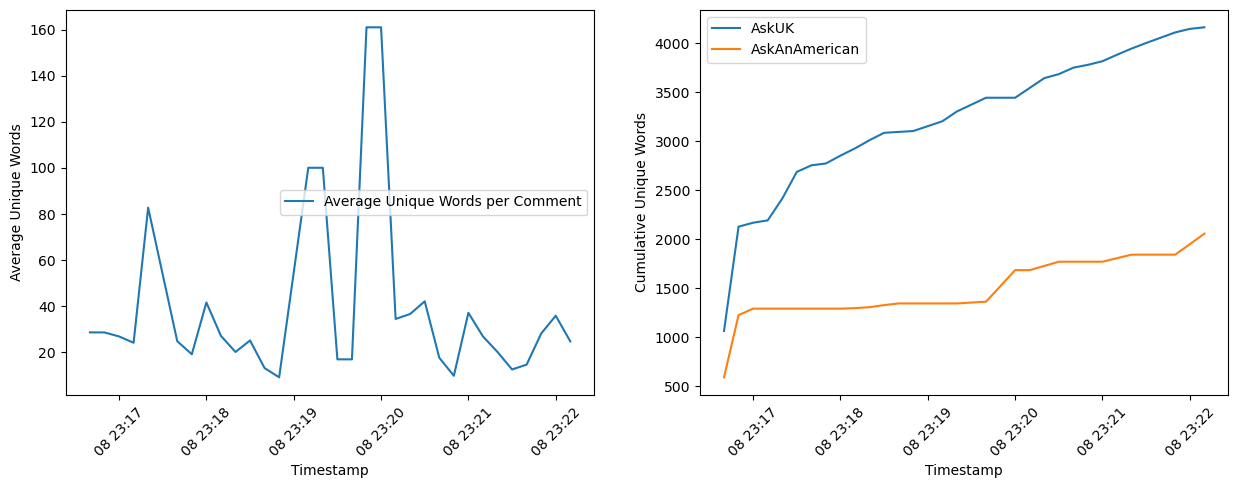

Current MAE: 22.896584880709668
----------- 2023-12-08 23:22:20 -----------
+---------------+-------+----------+--------------------+---------+-------------+-------------+
|         author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+---------------+-------+----------+--------------------+---------+-------------+-------------+
|hoksworthwipple|kckdvk5|   18dvkc3|It's called malt ...|    AskUK|1.702077711E9|   1702077721|
|      AliAskari|kckdvs9|   18dyvah|              Anusol|    AskUK|1.702077713E9|   1702077725|
+---------------+-------+----------+--------------------+---------+-------------+-------------+



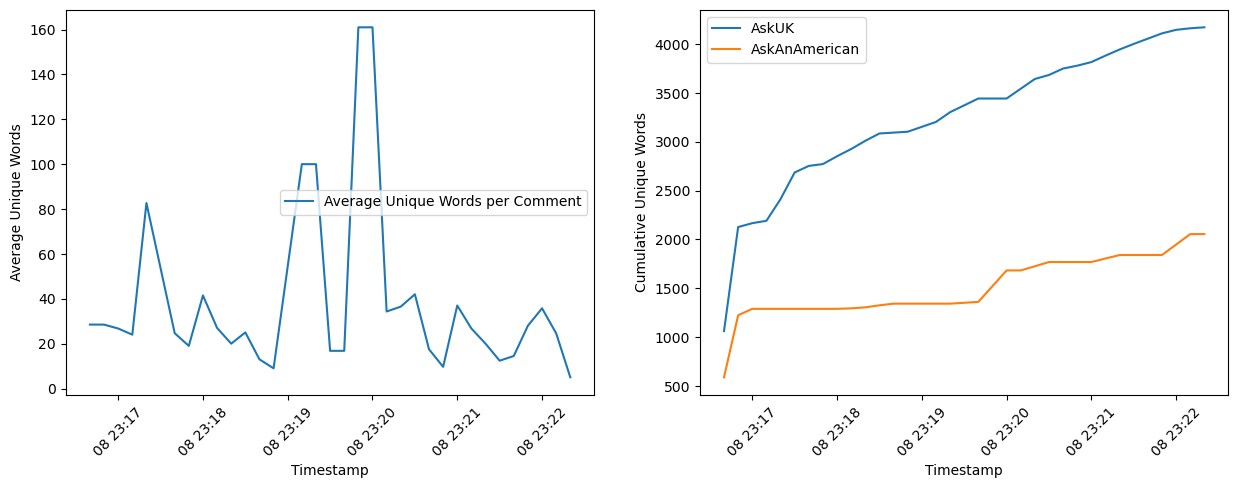

Current MAE: 4.8036
----------- 2023-12-08 23:22:30 -----------
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|        author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|Forteanforever|kckdx53|   18dl6a5|In the UK origina...|    AskUK| 1.70207773E9|   1702077743|
|      Darwen85|kckdxfi|   18dw6tg|I'm glad it's not...|    AskUK|1.702077734E9|   1702077744|
+--------------+-------+----------+--------------------+---------+-------------+-------------+



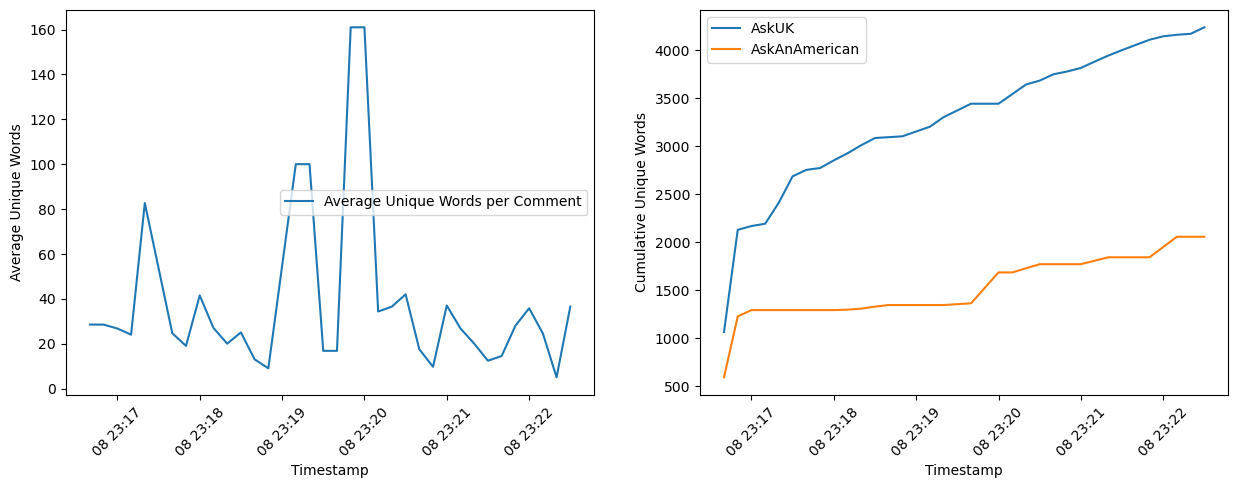

Current MAE: 35.056
----------- 2023-12-08 23:22:40 -----------
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|          author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|  Forteanforever|kckdx53|   18dl6a5|In the UK origina...|    AskUK| 1.70207773E9|   1702077743|
|        Darwen85|kckdxfi|   18dw6tg|I'm glad it's not...|    AskUK|1.702077734E9|   1702077744|
|Cyborg_Ninja_Cat|kckdy2w|   18dvkc3|I don't think I w...|    AskUK|1.702077742E9|   1702077753|
|        BaBaFiCo|kckdy7c|   18dxl6q|Ah okay. That mus...|    AskUK|1.702077743E9|   1702077754|
|          Hol_84|kckdydf|   18dsn9d|Move house consta...|    AskUK|1.702077746E9|   1702077756|
+----------------+-------+----------+--------------------+---------+-------------+-------------+



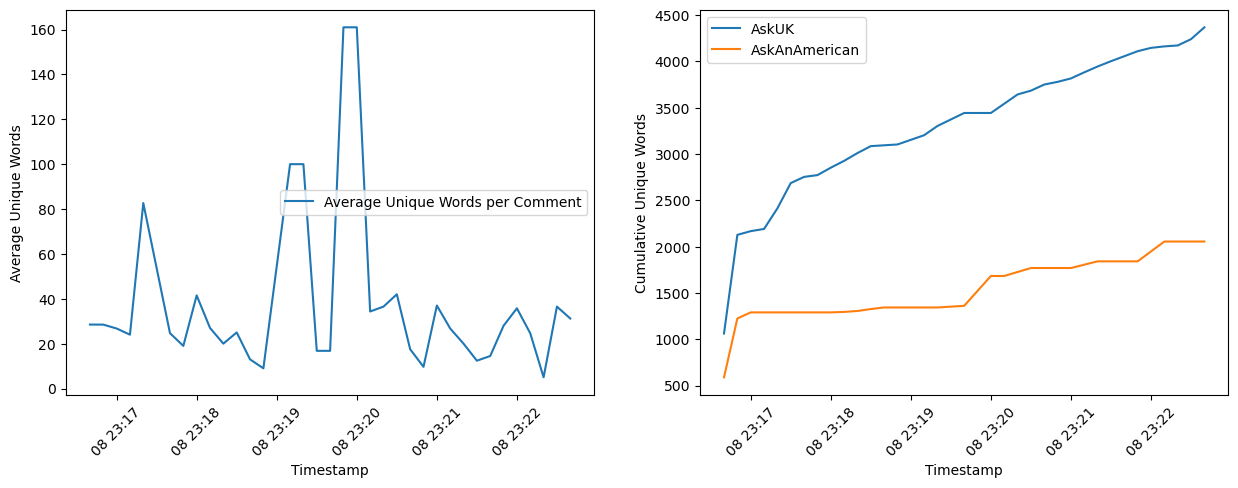

Current MAE: 28.71794325394943
----------- 2023-12-08 23:22:50 -----------
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|          author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|Cyborg_Ninja_Cat|kckdy2w|   18dvkc3|I don't think I w...|    AskUK|1.702077742E9|   1702077753|
|        BaBaFiCo|kckdy7c|   18dxl6q|Ah okay. That mus...|    AskUK|1.702077743E9|   1702077754|
|          Hol_84|kckdydf|   18dsn9d|Move house consta...|    AskUK|1.702077746E9|   1702077756|
+----------------+-------+----------+--------------------+---------+-------------+-------------+



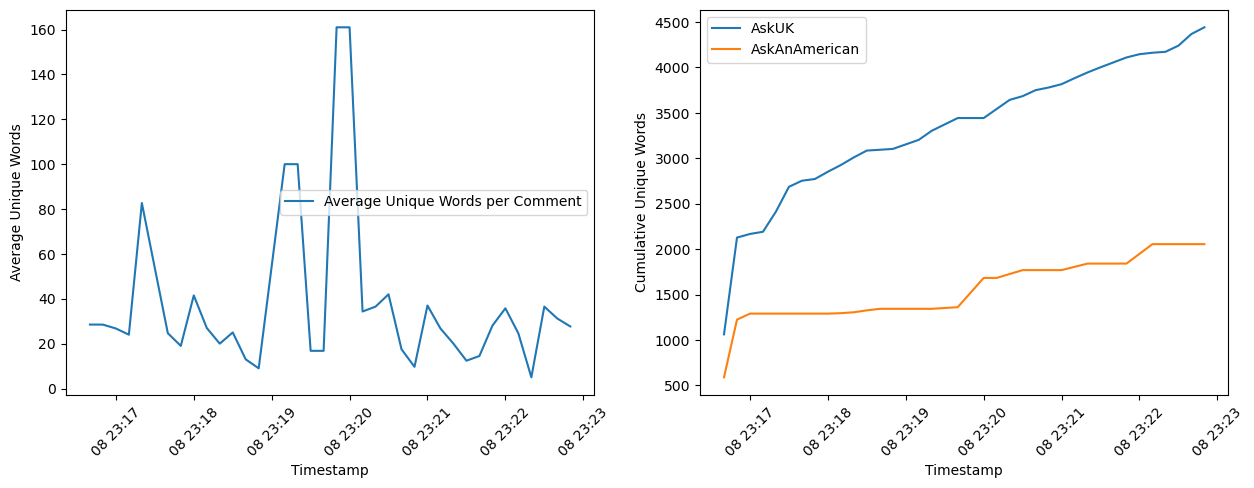

Current MAE: 26.323924799130374
----------- 2023-12-08 23:23:00 -----------
+----------------+-------+----------+--------------------+-------------+-------------+-------------+
|          author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+-------------+-------------+-------------+
|Elusive_Zergling|kckdzat|   18dn5o8|Nope, they used t...|        AskUK|1.702077757E9|   1702077775|
|    monkeycomet2|kckdzpn|   18dtewi|              Ok bud|AskAnAmerican|1.702077762E9|   1702077775|
|    wordbreather|kckdzyd|   18dl6a5|Back in the day m...|        AskUK|1.702077765E9|   1702077775|
+----------------+-------+----------+--------------------+-------------+-------------+-------------+



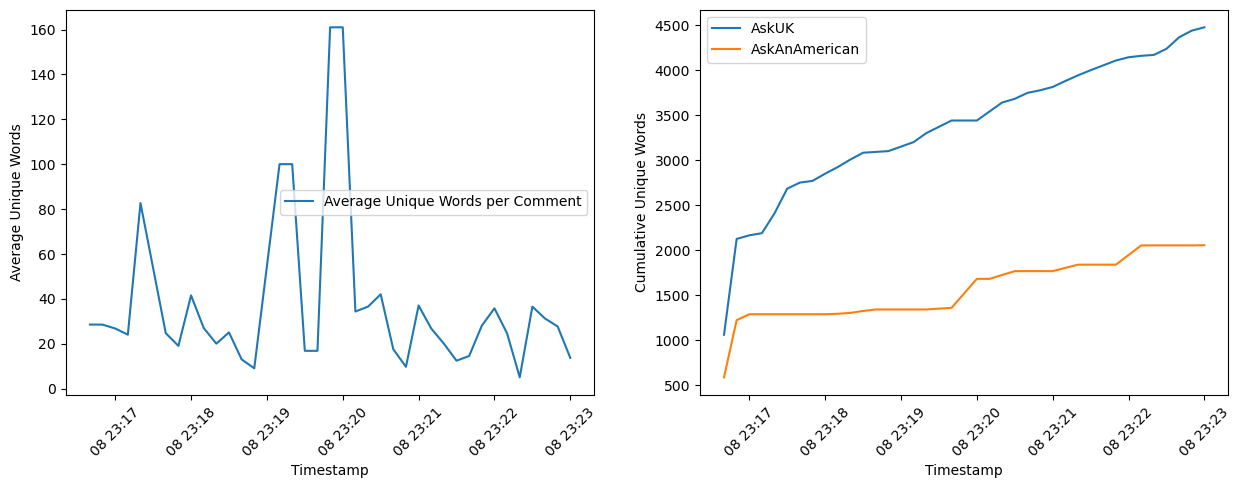

Current MAE: 13.053876920643617
----------- 2023-12-08 23:23:10 -----------
+----------------+-------+----------+--------------------+-------------+-------------+-------------+
|          author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+-------------+-------------+-------------+
|Elusive_Zergling|kckdzat|   18dn5o8|Nope, they used t...|        AskUK|1.702077757E9|   1702077775|
|    monkeycomet2|kckdzpn|   18dtewi|              Ok bud|AskAnAmerican|1.702077762E9|   1702077775|
|    wordbreather|kckdzyd|   18dl6a5|Back in the day m...|        AskUK|1.702077765E9|   1702077775|
|   Krikkit_Jelly|kcke0k2|   18dl6a5|Aussies tend to j...|        AskUK|1.702077772E9|   1702077784|
+----------------+-------+----------+--------------------+-------------+-------------+-------------+



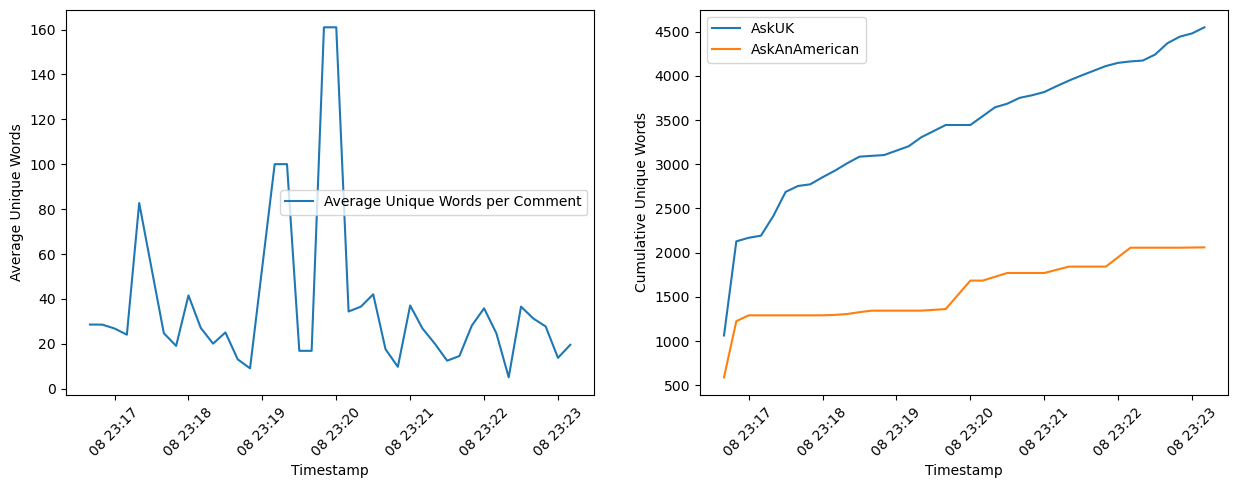

Current MAE: 18.1244836631383
----------- 2023-12-08 23:23:20 -----------
+-------------+-------+----------+--------------------+---------+-------------+-------------+
|       author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-------------+-------+----------+--------------------+---------+-------------+-------------+
|Krikkit_Jelly|kcke0k2|   18dl6a5|Aussies tend to j...|    AskUK|1.702077772E9|   1702077784|
+-------------+-------+----------+--------------------+---------+-------------+-------------+



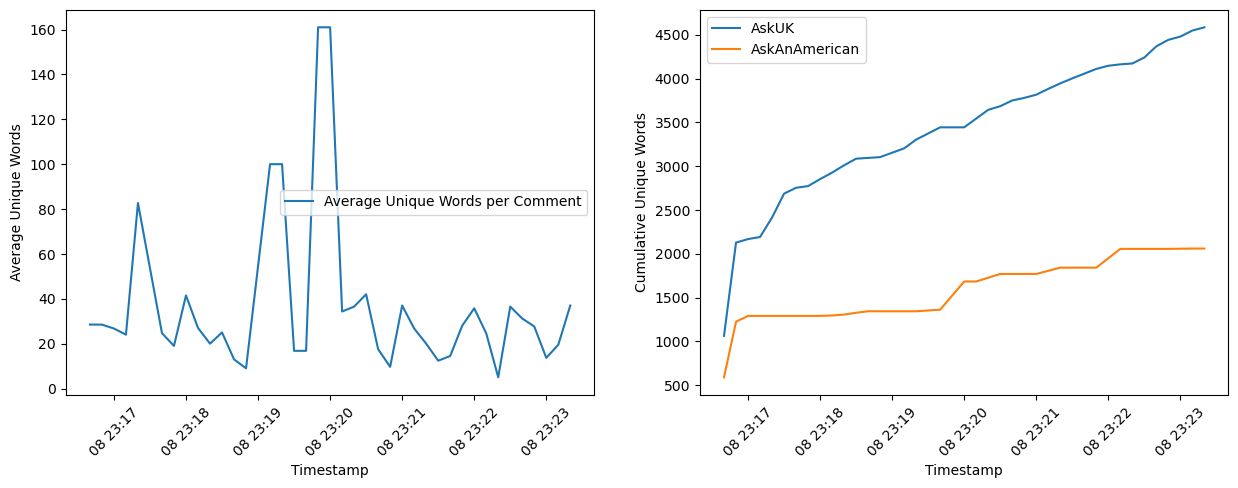

Current MAE: 36.26
----------- 2023-12-08 23:23:30 -----------
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|          author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|   Trilobite_Tom|kcke1gp|   18dyvah|           Anal lube|    AskUK|1.702077783E9|   1702077801|
|Complete_Fix2563|kcke1t1|   18dymwu|                3th?|    AskUK|1.702077788E9|   1702077801|
|         windol1|kcke2e6|   18djnqj|Signing for somet...|    AskUK|1.702077794E9|   1702077806|
+----------------+-------+----------+--------------------+---------+-------------+-------------+



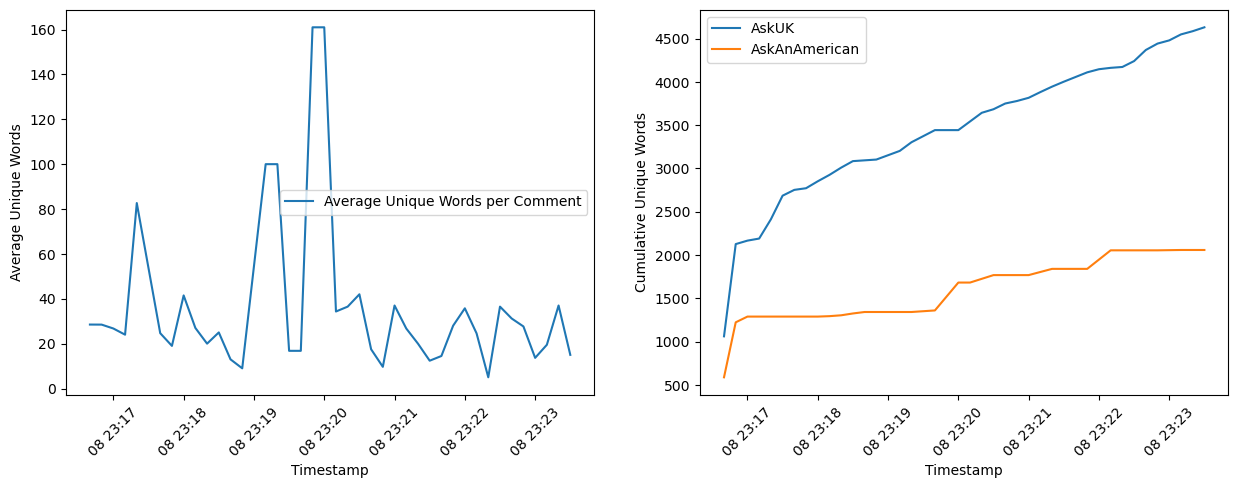

Current MAE: 14.110641830610643
----------- 2023-12-08 23:23:40 -----------
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|          author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|   Trilobite_Tom|kcke1gp|   18dyvah|           Anal lube|    AskUK|1.702077783E9|   1702077801|
|Complete_Fix2563|kcke1t1|   18dymwu|                3th?|    AskUK|1.702077788E9|   1702077801|
|         windol1|kcke2e6|   18djnqj|Signing for somet...|    AskUK|1.702077794E9|   1702077806|
+----------------+-------+----------+--------------------+---------+-------------+-------------+



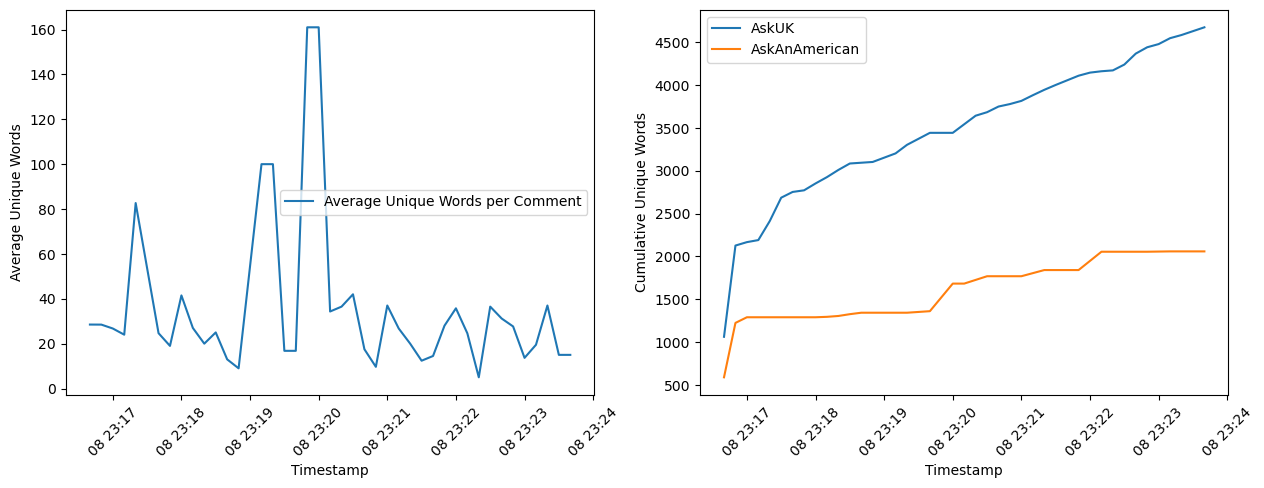

Current MAE: 14.110641830610643
----------- 2023-12-08 23:23:50 -----------
Error: RDD is empty
----------- 2023-12-08 23:24:00 -----------
Error: RDD is empty
----------- 2023-12-08 23:24:10 -----------
Error: RDD is empty
----------- 2023-12-08 23:24:20 -----------
Error: RDD is empty
----------- 2023-12-08 23:24:30 -----------
Error: RDD is empty
----------- 2023-12-08 23:24:40 -----------
+----------+-------+----------+--------------------+-------------+-------------+-------------+
|    author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+----------+-------+----------+--------------------+-------------+-------------+-------------+
|FivebyFive|kcke762|   18dwc8w|I started learnin...|AskAnAmerican|1.702077853E9|   1702077875|
|crangeacct|kcke829|   18dxlv3|Oh yeah I forgot ...|AskAnAmerican|1.702077864E9|   1702077875|
|el_trumpo1|kcke8hl|   18dtgek|You grow up.\n\nD...|        AskUK|1.702077869E9|   1702077879|
+----------+-------+----------+---

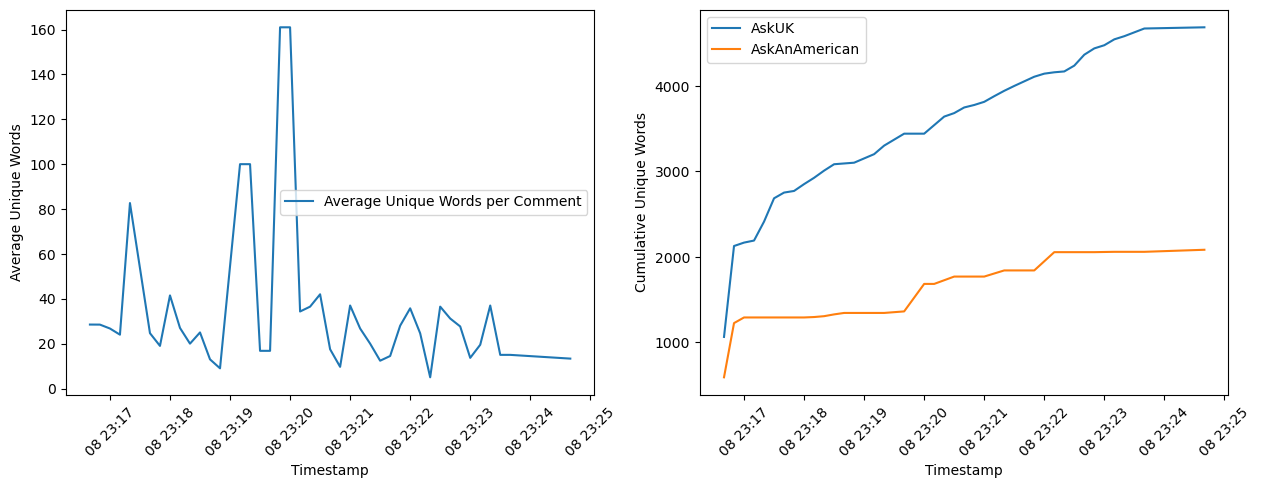

Current MAE: 12.737183926562524
----------- 2023-12-08 23:24:50 -----------
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|        author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|    FivebyFive|kcke762|   18dwc8w|I started learnin...|AskAnAmerican|1.702077853E9|   1702077875|
|    crangeacct|kcke829|   18dxlv3|Oh yeah I forgot ...|AskAnAmerican|1.702077864E9|   1702077875|
|    el_trumpo1|kcke8hl|   18dtgek|You grow up.\n\nD...|        AskUK|1.702077869E9|   1702077879|
|socio-pathetic|kcke8l9|   18dn5o8|Wore a watch ever...|        AskUK|1.702077871E9|   1702077881|
|  GodofWar1234|kcke8te|   18dqkjh|Thailand. Amazing...|AskAnAmerican|1.702077874E9|   1702077886|
|      Subvet98|kcke938|   18dvmk1|None. There thing...|AskAnAmerican|1.702077877E9|   1702077888|
+--------------+-------+---------

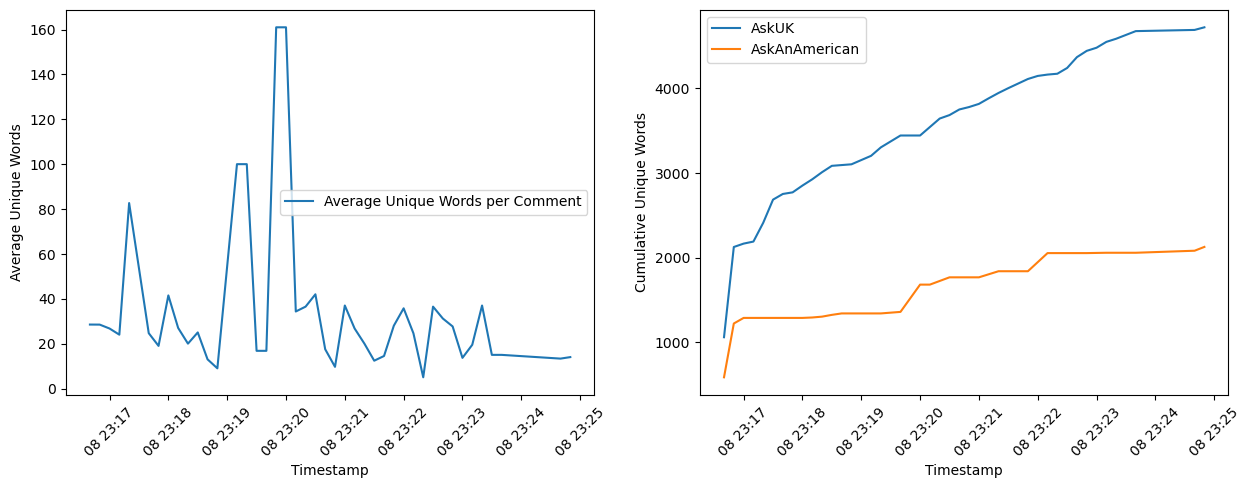

Current MAE: 12.915465889513984
----------- 2023-12-08 23:25:00 -----------
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|        author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|socio-pathetic|kcke8l9|   18dn5o8|Wore a watch ever...|        AskUK|1.702077871E9|   1702077881|
|  GodofWar1234|kcke8te|   18dqkjh|Thailand. Amazing...|AskAnAmerican|1.702077874E9|   1702077886|
|      Subvet98|kcke938|   18dvmk1|None. There thing...|AskAnAmerican|1.702077877E9|   1702077888|
|     D-1-S-C-0|kcke9pq|   18dl6a5|You're 99% right....|        AskUK|1.702077885E9|   1702077897|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+



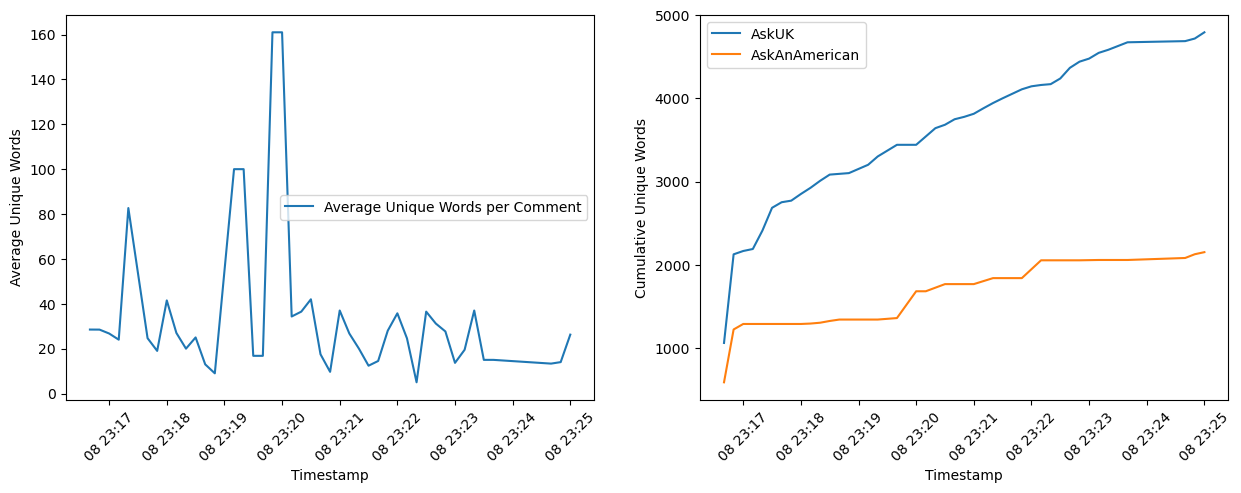

Current MAE: 24.301780799239566
----------- 2023-12-08 23:25:10 -----------
+------------------+-------+----------+--------------------+---------+-------------+-------------+
|            author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+------------------+-------+----------+--------------------+---------+-------------+-------------+
|         D-1-S-C-0|kcke9pq|   18dl6a5|You're 99% right....|    AskUK|1.702077885E9|   1702077897|
|    Forteanforever|kckeack|   18dl6a5|It identified him...|    AskUK|1.702077893E9|   1702077907|
|Status_Common_9583|kckeacn|   18dsn9d|Ooof same. I had ...|    AskUK|1.702077893E9|   1702077907|
+------------------+-------+----------+--------------------+---------+-------------+-------------+



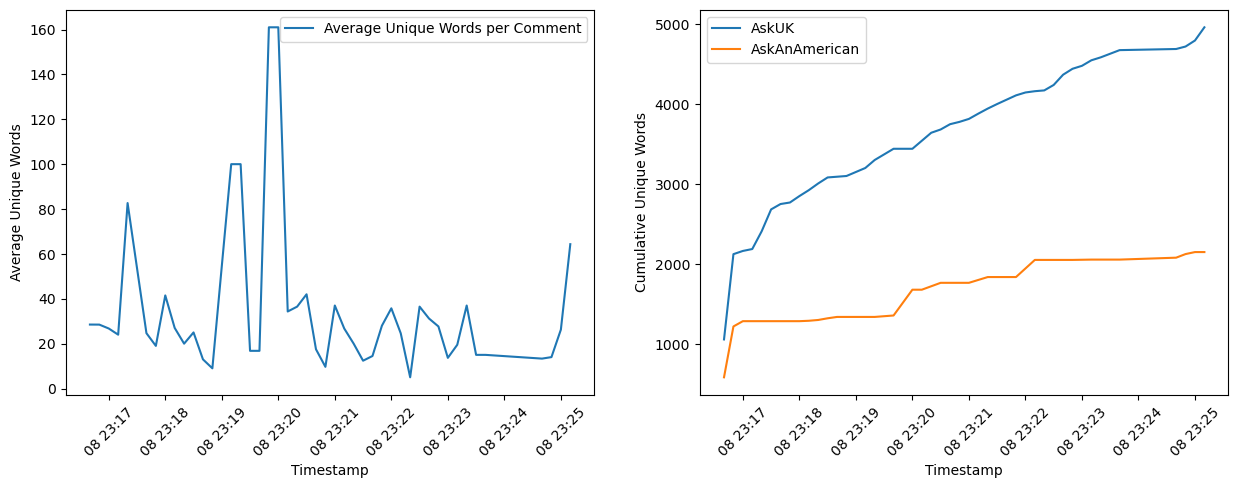

Current MAE: 60.98455622075668
----------- 2023-12-08 23:25:20 -----------
+------------------+-------+----------+--------------------+---------+-------------+-------------+
|            author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+------------------+-------+----------+--------------------+---------+-------------+-------------+
|    Forteanforever|kckeack|   18dl6a5|It identified him...|    AskUK|1.702077893E9|   1702077907|
|Status_Common_9583|kckeacn|   18dsn9d|Ooof same. I had ...|    AskUK|1.702077893E9|   1702077907|
|        BadBassist|kckeazz|   18dla4b|Small bottles 330...|    AskUK|1.702077901E9|   1702077912|
|  AverageCheap4990|kckebb7|   18dy8ea|Technically, it b...|    AskUK|1.702077905E9|   1702077916|
|         fire2burn|kckebff|   18dunok|I have chronic mi...|    AskUK|1.702077906E9|   1702077916|
+------------------+-------+----------+--------------------+---------+-------------+-------------+



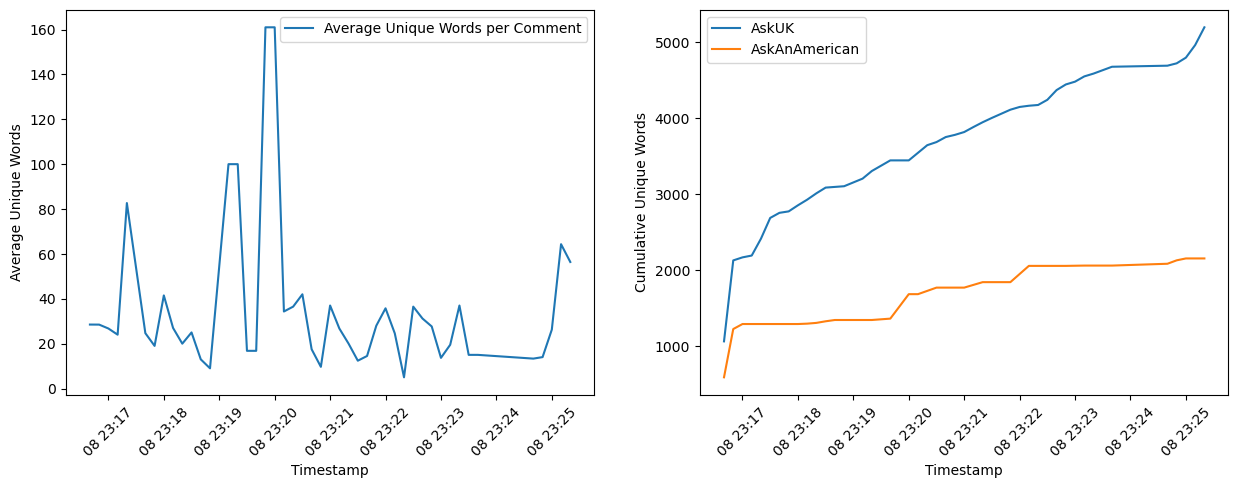

Current MAE: 52.402264733477416
----------- 2023-12-08 23:25:30 -----------
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|          author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+----------------+-------+----------+--------------------+---------+-------------+-------------+
|      BadBassist|kckeazz|   18dla4b|Small bottles 330...|    AskUK|1.702077901E9|   1702077912|
|AverageCheap4990|kckebb7|   18dy8ea|Technically, it b...|    AskUK|1.702077905E9|   1702077916|
|       fire2burn|kckebff|   18dunok|I have chronic mi...|    AskUK|1.702077906E9|   1702077916|
+----------------+-------+----------+--------------------+---------+-------------+-------------+



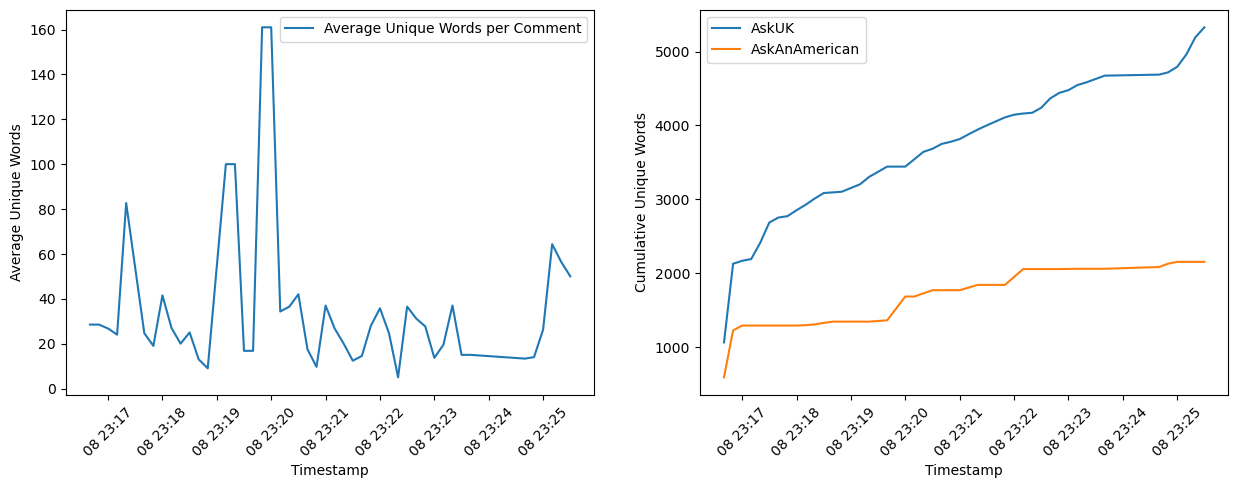

Current MAE: 46.82599226904025
----------- 2023-12-08 23:25:40 -----------
Error: RDD is empty
----------- 2023-12-08 23:25:50 -----------
Error: RDD is empty
----------- 2023-12-08 23:26:00 -----------
Error: RDD is empty
----------- 2023-12-08 23:26:10 -----------
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|        author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|LittleSadRufus|kckeej4|   18dw6tg|Ah, I'm the oppos...|    AskUK|1.702077944E9|   1702077968|
+--------------+-------+----------+--------------------+---------+-------------+-------------+



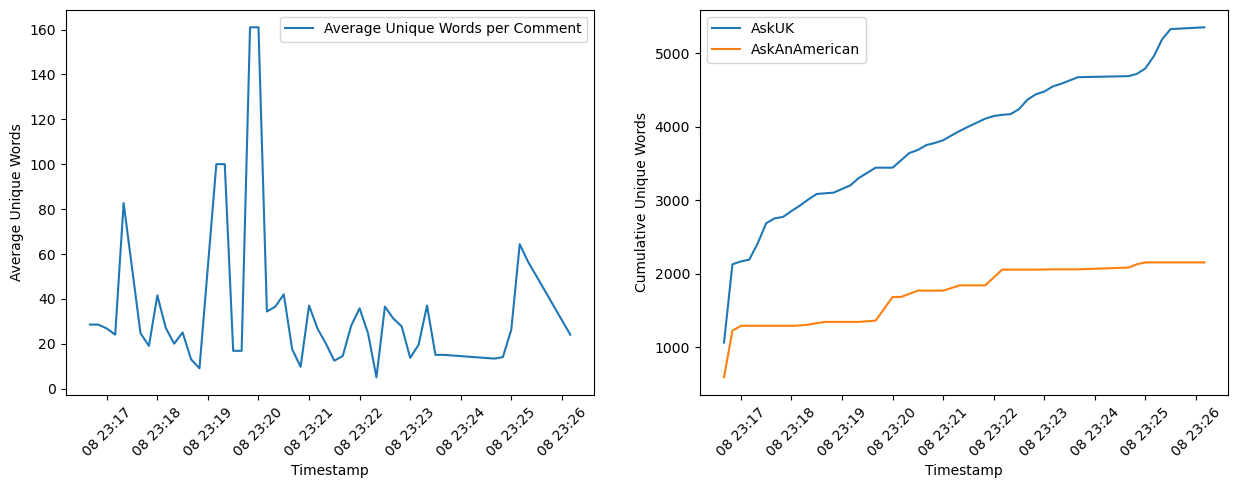

Current MAE: 23.52
----------- 2023-12-08 23:26:20 -----------
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|        author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|LittleSadRufus|kckeej4|   18dw6tg|Ah, I'm the oppos...|        AskUK|1.702077944E9|   1702077968|
|       Crayen5|kckefmu|   18dyvah|            Asbestos|        AskUK|1.702077959E9|   1702077970|
|  GodofWar1234|kckefri|   18dqkjh|Dawg what are you...|AskAnAmerican|1.702077961E9|   1702077971|
|     lampypete|kckefti|   18dy8ea|      Are you a dog?|        AskUK|1.702077961E9|   1702077971|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+



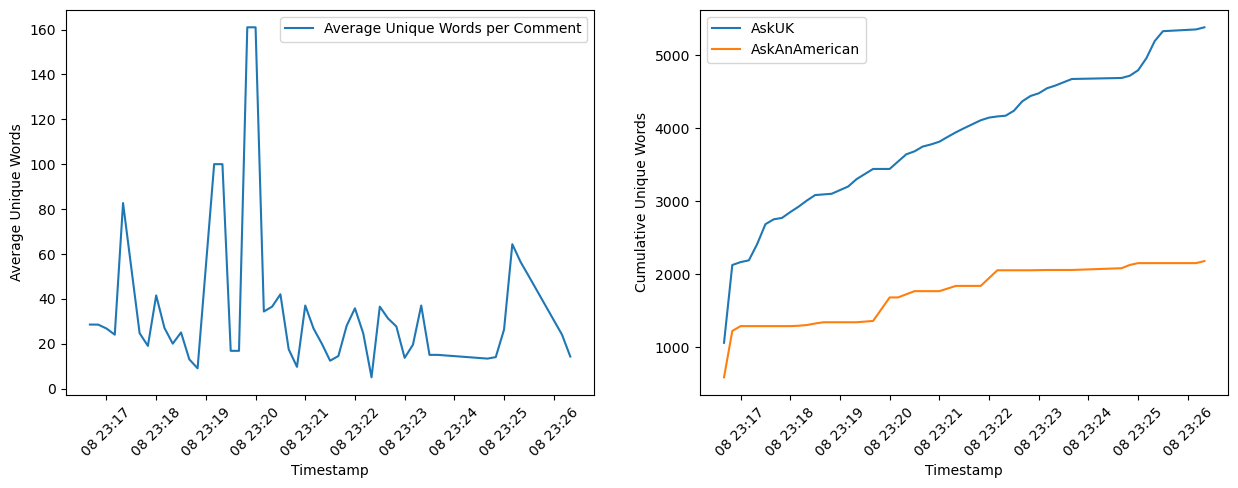

Current MAE: 13.474589472359488
----------- 2023-12-08 23:26:30 -----------
+------------+-------+----------+--------------------+-------------+-------------+-------------+
|      author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+------------+-------+----------+--------------------+-------------+-------------+-------------+
|     Crayen5|kckefmu|   18dyvah|            Asbestos|        AskUK|1.702077959E9|   1702077970|
|GodofWar1234|kckefri|   18dqkjh|Dawg what are you...|AskAnAmerican|1.702077961E9|   1702077971|
|   lampypete|kckefti|   18dy8ea|      Are you a dog?|        AskUK|1.702077961E9|   1702077971|
+------------+-------+----------+--------------------+-------------+-------------+-------------+



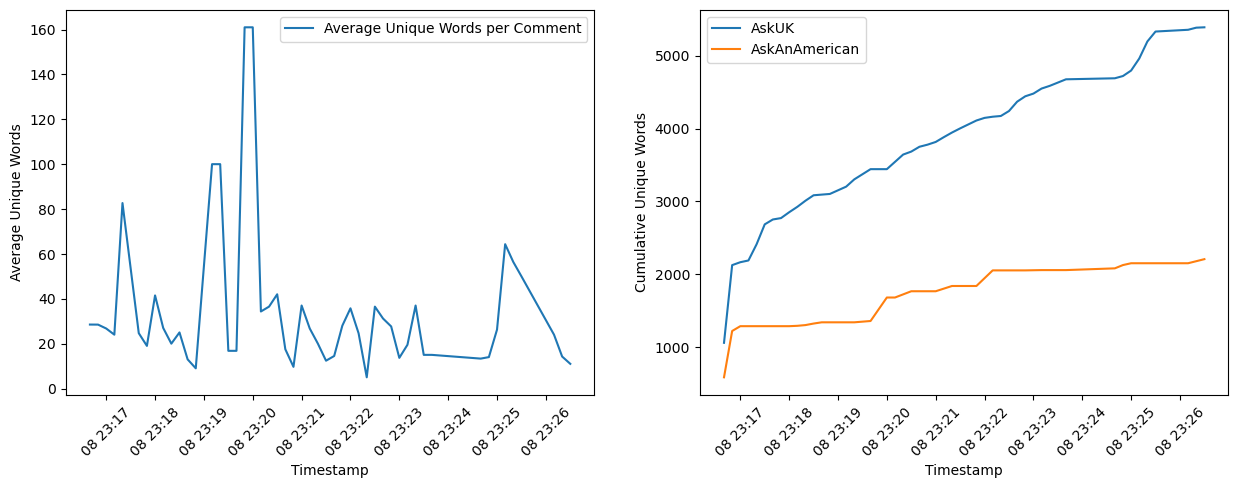

Current MAE: 10.507268283385109
----------- 2023-12-08 23:26:40 -----------
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|        author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|       POWBlok|kckegn6|   18dvkc3|i cut like a quar...|    AskUK|1.702077971E9|   1702077990|
| Silver-beard2|kckeh7x|   18ds9gj|The point is that...|    AskUK|1.702077978E9|   1702077990|
|Rainbowmagix83|kckehtj|   18dl6a5|Yes I remember wh...|    AskUK|1.702077986E9|   1702077999|
+--------------+-------+----------+--------------------+---------+-------------+-------------+



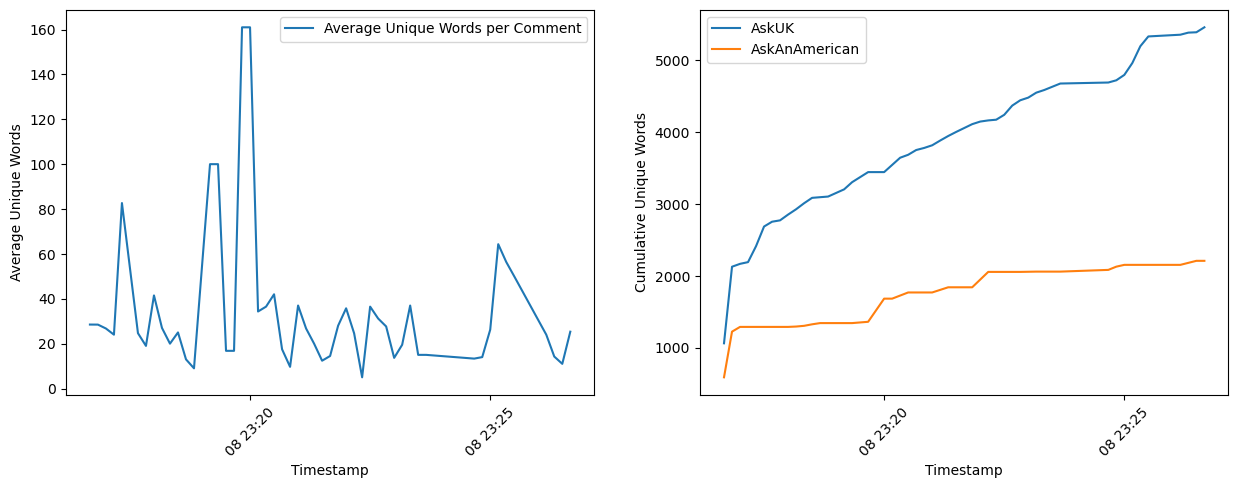

Current MAE: 24.17416108385932
----------- 2023-12-08 23:26:50 -----------
+---------------+-------+----------+--------------------+---------+-------------+-------------+
|         author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+---------------+-------+----------+--------------------+---------+-------------+-------------+
|        POWBlok|kckegn6|   18dvkc3|i cut like a quar...|    AskUK|1.702077971E9|   1702077990|
|  Silver-beard2|kckeh7x|   18ds9gj|The point is that...|    AskUK|1.702077978E9|   1702077990|
| Rainbowmagix83|kckehtj|   18dl6a5|Yes I remember wh...|    AskUK|1.702077986E9|   1702077999|
|caniuserealname|kckei5b|   18ds9gj|Someone who is of...|    AskUK| 1.70207799E9|   1702078001|
|   lifehacks-uk|kckeih2|    lr8mdy|https://uktrace.c...|    AskUK|1.702077994E9|   1702078005|
+---------------+-------+----------+--------------------+---------+-------------+-------------+



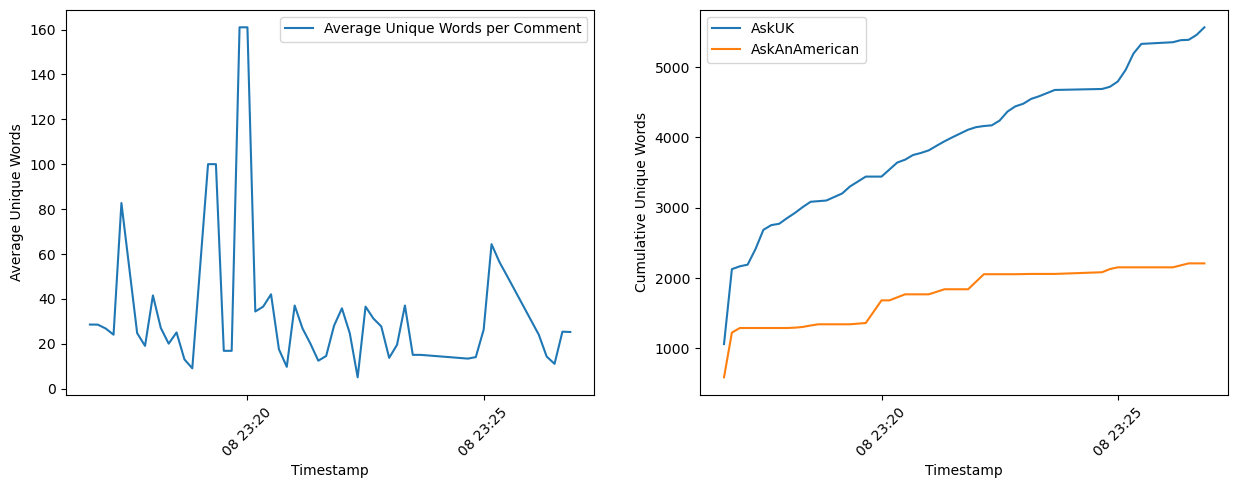

Current MAE: 23.428999666274564
----------- 2023-12-08 23:27:00 -----------
+---------------+-------+----------+--------------------+---------+-------------+-------------+
|         author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+---------------+-------+----------+--------------------+---------+-------------+-------------+
|caniuserealname|kckei5b|   18ds9gj|Someone who is of...|    AskUK| 1.70207799E9|   1702078001|
|   lifehacks-uk|kckeih2|    lr8mdy|https://uktrace.c...|    AskUK|1.702077994E9|   1702078005|
|      R2-Scotia|kckej8r|   18dj07m|I have EE 4G devi...|    AskUK|1.702078004E9|   1702078014|
+---------------+-------+----------+--------------------+---------+-------------+-------------+



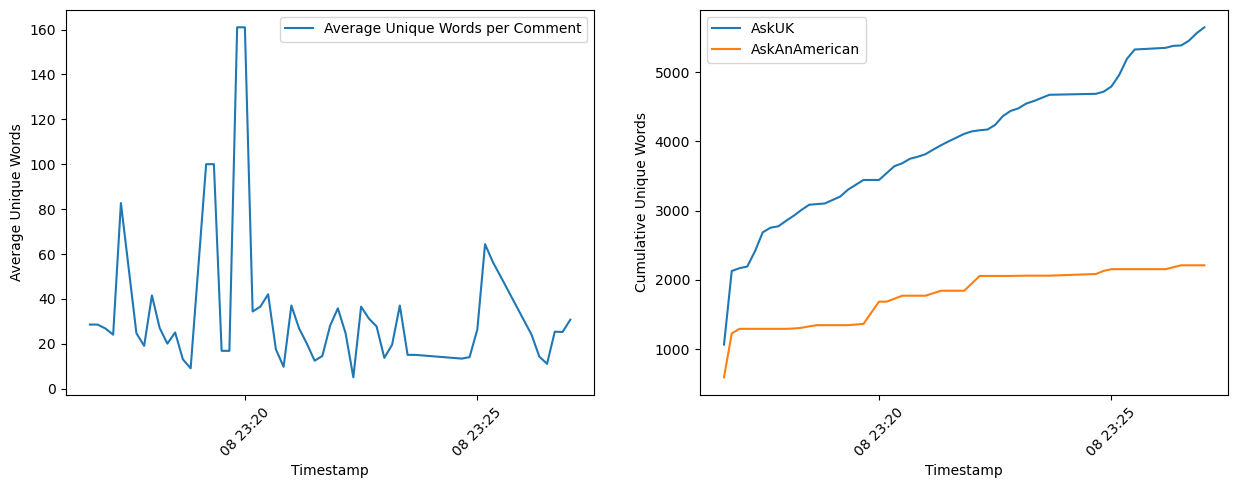

Current MAE: 29.412431101417507
----------- 2023-12-08 23:27:10 -----------
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|        author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|     R2-Scotia|kckej8r|   18dj07m|I have EE 4G devi...|    AskUK|1.702078004E9|   1702078014|
|      chkmbmgr|kckejx1|   18dl6a5|Are you also just...|    AskUK|1.702078012E9|   1702078023|
|Moosetache3000|kckejz7|   18dw6tg|‘Shim sham’ for a...|    AskUK|1.702078013E9|   1702078023|
|  lifehacks-uk|kckekcu|    zcp1jv|https://uktrace.c...|    AskUK|1.702078017E9|   1702078028|
+--------------+-------+----------+--------------------+---------+-------------+-------------+



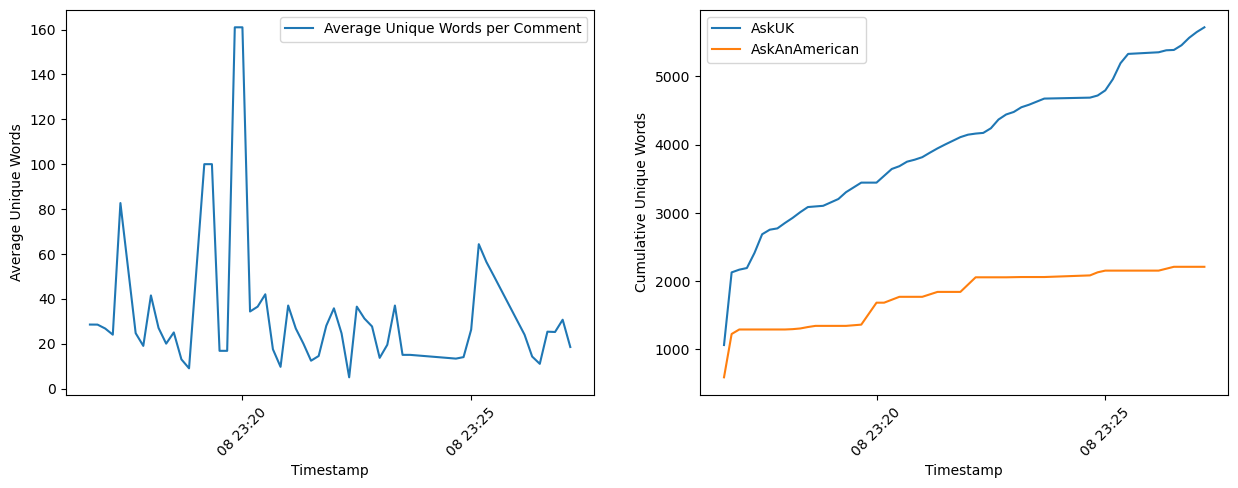

Current MAE: 17.416692671256794
----------- 2023-12-08 23:27:20 -----------
+--------------------+-------+----------+--------------------+---------+-------------+-------------+
|              author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------------+-------+----------+--------------------+---------+-------------+-------------+
|            chkmbmgr|kckejx1|   18dl6a5|Are you also just...|    AskUK|1.702078012E9|   1702078023|
|      Moosetache3000|kckejz7|   18dw6tg|‘Shim sham’ for a...|    AskUK|1.702078013E9|   1702078023|
|        lifehacks-uk|kckekcu|    zcp1jv|https://uktrace.c...|    AskUK|1.702078017E9|   1702078028|
|MonitorEfficient3358|kckeklg|   18dl6a5|Price of bread an...|    AskUK| 1.70207802E9|   1702078030|
+--------------------+-------+----------+--------------------+---------+-------------+-------------+



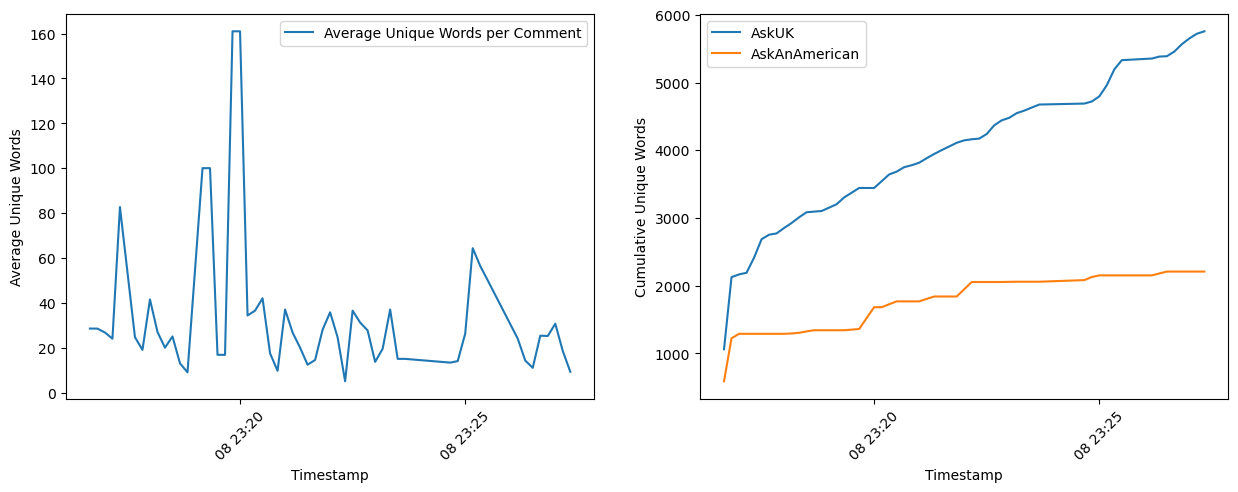

Current MAE: 8.391179413318854
----------- 2023-12-08 23:27:30 -----------
+--------------------+-------+----------+--------------------+---------+-------------+-------------+
|              author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------------+-------+----------+--------------------+---------+-------------+-------------+
|MonitorEfficient3358|kckeklg|   18dl6a5|Price of bread an...|    AskUK| 1.70207802E9|   1702078030|
|       Orange_Hedgie|kckelm1|   18dl6a5|We had mice until...|    AskUK|1.702078033E9|   1702078047|
|          Lunaspoona|kckelwj|   18dymwu|In Primary school...|    AskUK|1.702078036E9|   1702078047|
|      Forteanforever|kckem5j|   18dl6a5|That often ends u...|    AskUK|1.702078039E9|   1702078049|
+--------------------+-------+----------+--------------------+---------+-------------+-------------+



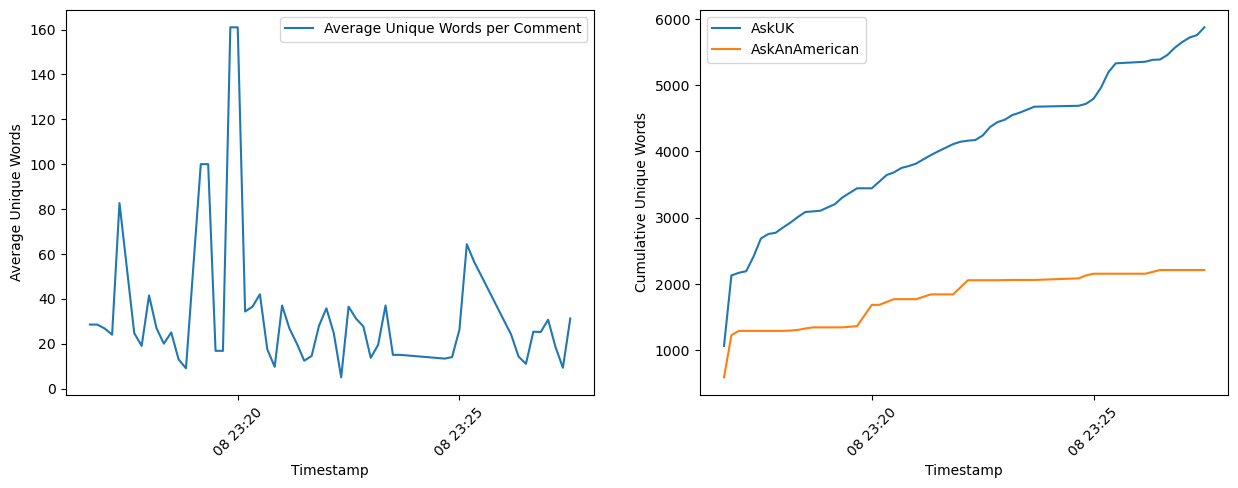

Current MAE: 29.232561783261275
----------- 2023-12-08 23:27:40 -----------
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|        author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+---------+-------------+-------------+
| Orange_Hedgie|kckelm1|   18dl6a5|We had mice until...|    AskUK|1.702078033E9|   1702078047|
|    Lunaspoona|kckelwj|   18dymwu|In Primary school...|    AskUK|1.702078036E9|   1702078047|
|Forteanforever|kckem5j|   18dl6a5|That often ends u...|    AskUK|1.702078039E9|   1702078049|
|      Amaranyx|kckeme8|   18dsn9d|Yep I got diagnos...|    AskUK|1.702078042E9|   1702078054|
+--------------+-------+----------+--------------------+---------+-------------+-------------+



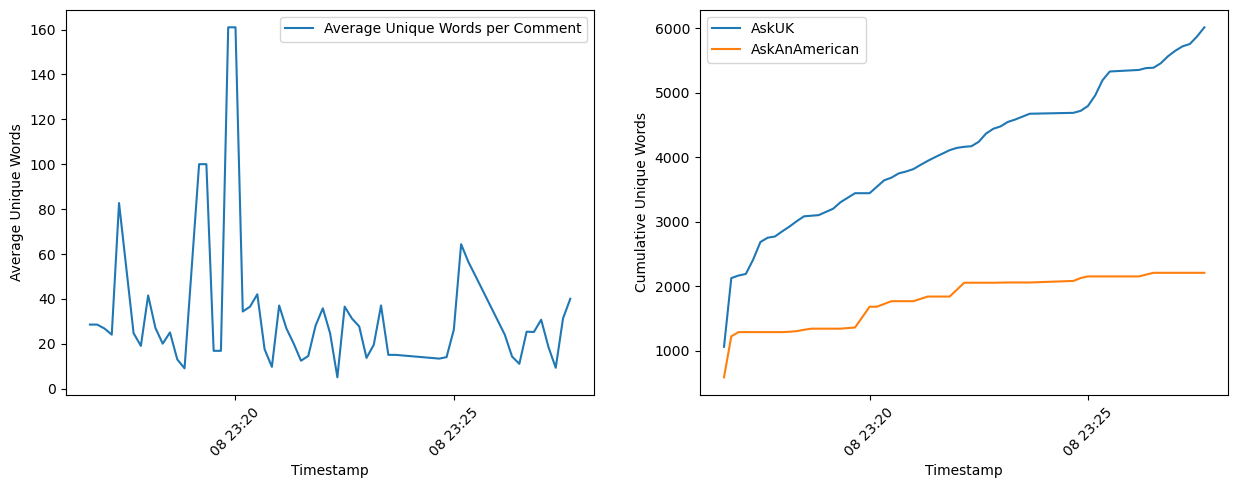

Current MAE: 37.91532803339917
----------- 2023-12-08 23:27:50 -----------
+--------+-------+----------+--------------------+---------+-------------+-------------+
|  author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------+-------+----------+--------------------+---------+-------------+-------------+
|Amaranyx|kckeme8|   18dsn9d|Yep I got diagnos...|    AskUK|1.702078042E9|   1702078054|
+--------+-------+----------+--------------------+---------+-------------+-------------+



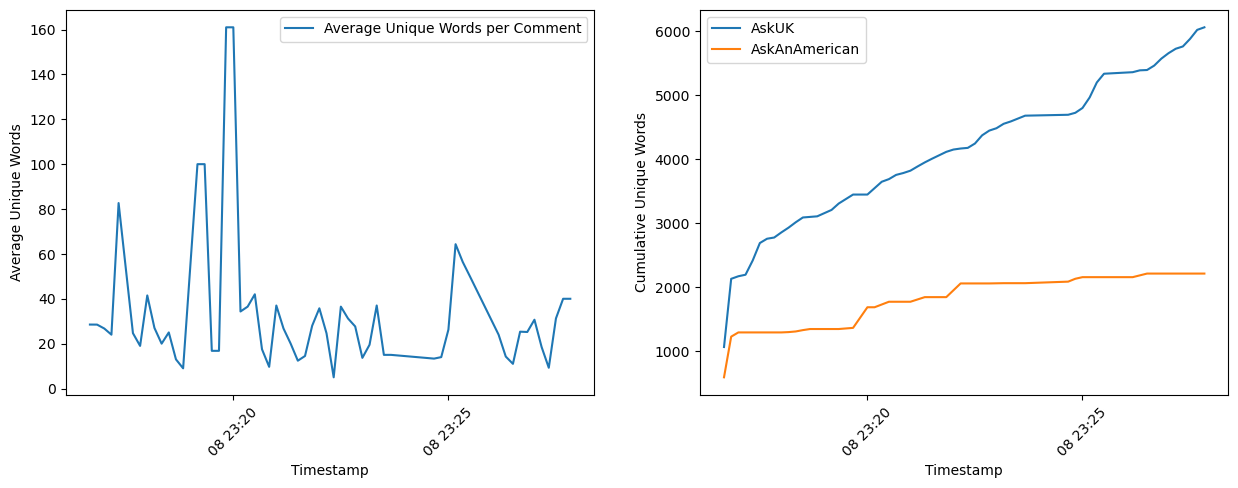

Current MAE: 39.2
----------- 2023-12-08 23:28:00 -----------
+---------------+-------+----------+--------------------+-------------+-------------+-------------+
|         author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+---------------+-------+----------+--------------------+-------------+-------------+-------------+
| Much_Prune3459|kckenb4|   18digfm|I don't think the...|AskAnAmerican|1.702078054E9|   1702078071|
|  ilovepuscifer|kckengo|   18dsn9d|The first one fuc...|        AskUK|1.702078056E9|   1702078071|
|FilmFanatic1066|kckeo5o|   18dsn9d|Smacking, extreme...|        AskUK|1.702078065E9|   1702078076|
|  Araucaria2024|kckeo94|   18dsn9d|Forcing the child...|        AskUK|1.702078066E9|   1702078076|
+---------------+-------+----------+--------------------+-------------+-------------+-------------+



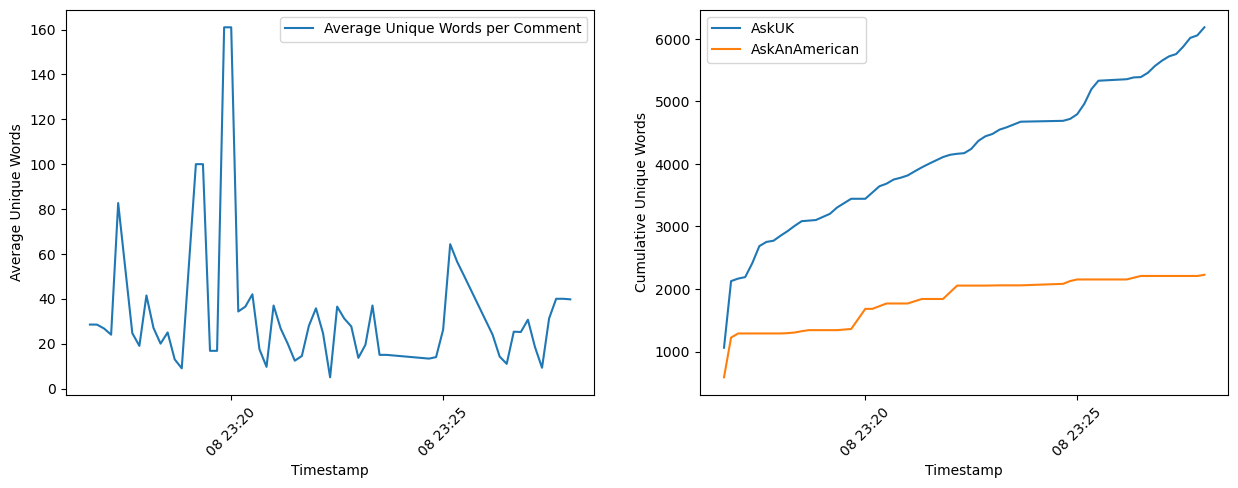

Current MAE: 37.64517479667752
----------- 2023-12-08 23:28:10 -----------
+---------------+-------+----------+--------------------+-------------+-------------+-------------+
|         author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+---------------+-------+----------+--------------------+-------------+-------------+-------------+
| Much_Prune3459|kckenb4|   18digfm|I don't think the...|AskAnAmerican|1.702078054E9|   1702078071|
|  ilovepuscifer|kckengo|   18dsn9d|The first one fuc...|        AskUK|1.702078056E9|   1702078071|
|FilmFanatic1066|kckeo5o|   18dsn9d|Smacking, extreme...|        AskUK|1.702078065E9|   1702078076|
|  Araucaria2024|kckeo94|   18dsn9d|Forcing the child...|        AskUK|1.702078066E9|   1702078076|
+---------------+-------+----------+--------------------+-------------+-------------+-------------+



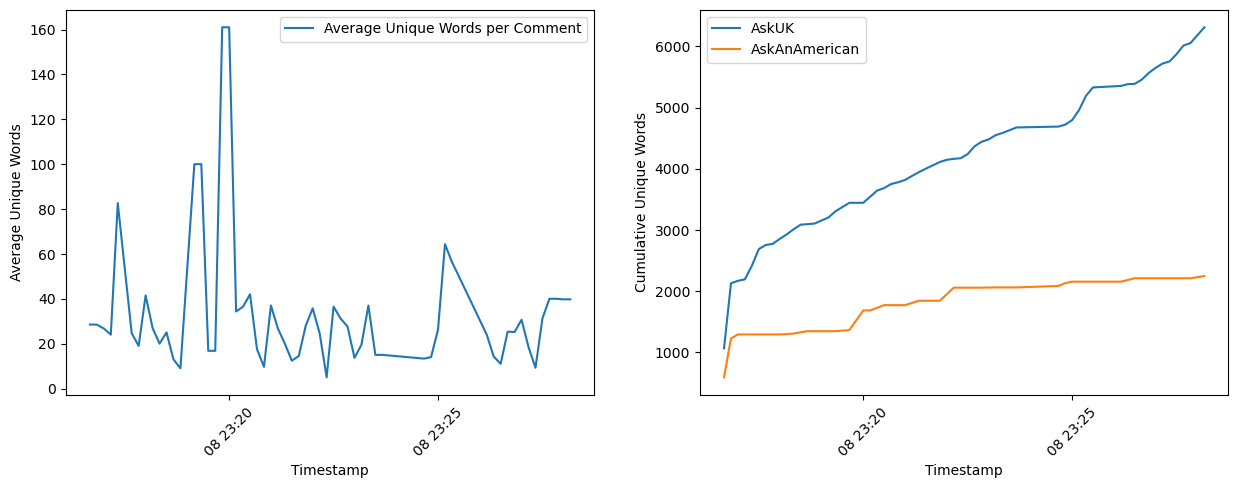

Current MAE: 37.64517479667752
----------- 2023-12-08 23:28:20 -----------
+-------------+-------+----------+------------------+---------+-------------+-------------+
|       author|     id|submission|              body|subreddit|  created_utc|collected_utc|
+-------------+-------+----------+------------------+---------+-------------+-------------+
|Joshthenosh77|kckepg8|   18dl6a5|Crumpet gremlin !!|    AskUK|1.702078082E9|   1702078093|
+-------------+-------+----------+------------------+---------+-------------+-------------+



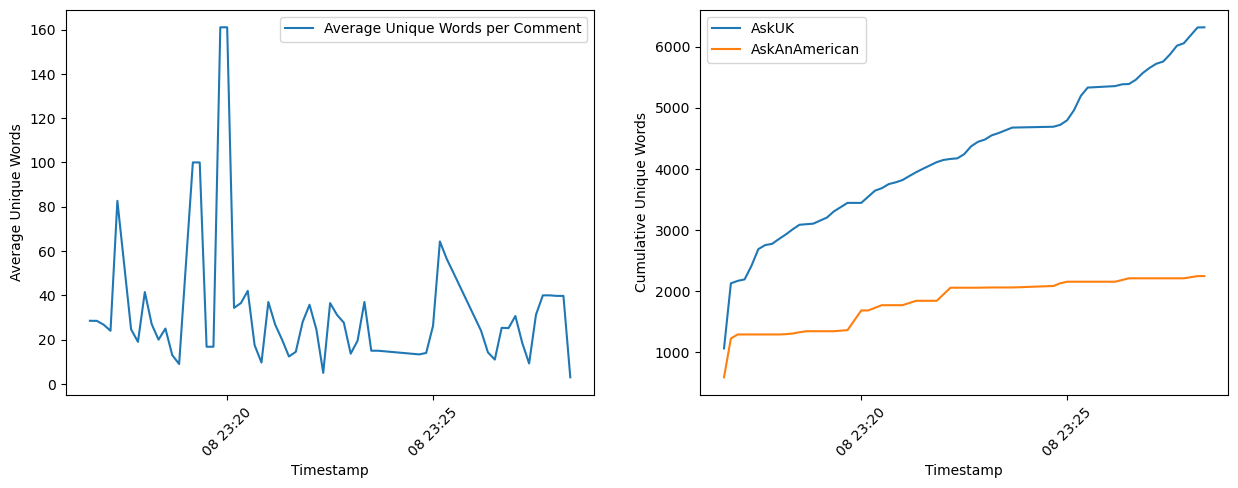

Current MAE: 2.94
----------- 2023-12-08 23:28:30 -----------
+-------------+-------+----------+--------------------+---------+-------------+-------------+
|       author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-------------+-------+----------+--------------------+---------+-------------+-------------+
|Joshthenosh77|kckepg8|   18dl6a5|  Crumpet gremlin !!|    AskUK|1.702078082E9|   1702078093|
|     Largejam|kckeq29|   18dyyid|Did they not chec...|    AskUK|1.702078089E9|   1702078103|
+-------------+-------+----------+--------------------+---------+-------------+-------------+



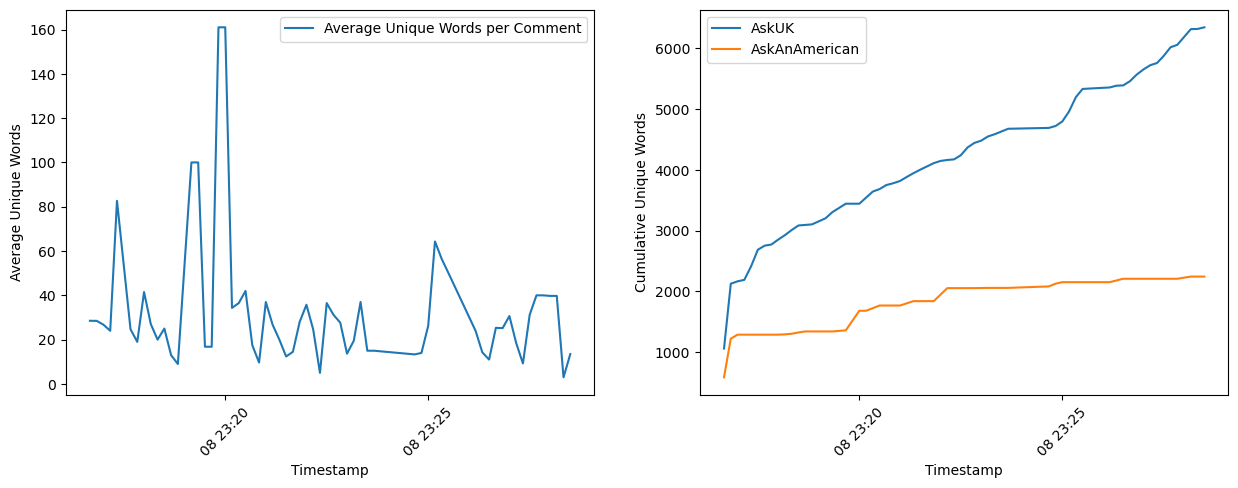

Current MAE: 12.961199999999998
----------- 2023-12-08 23:28:40 -----------
+-------------------+-------+----------+--------------------+---------+-------------+-------------+
|             author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-------------------+-------+----------+--------------------+---------+-------------+-------------+
|           Largejam|kckeq29|   18dyyid|Did they not chec...|    AskUK|1.702078089E9|   1702078103|
|Aromatic_Flight6968|kcker2e|   18dyyid|If it's just by o...|    AskUK|1.702078102E9|   1702078112|
+-------------------+-------+----------+--------------------+---------+-------------+-------------+



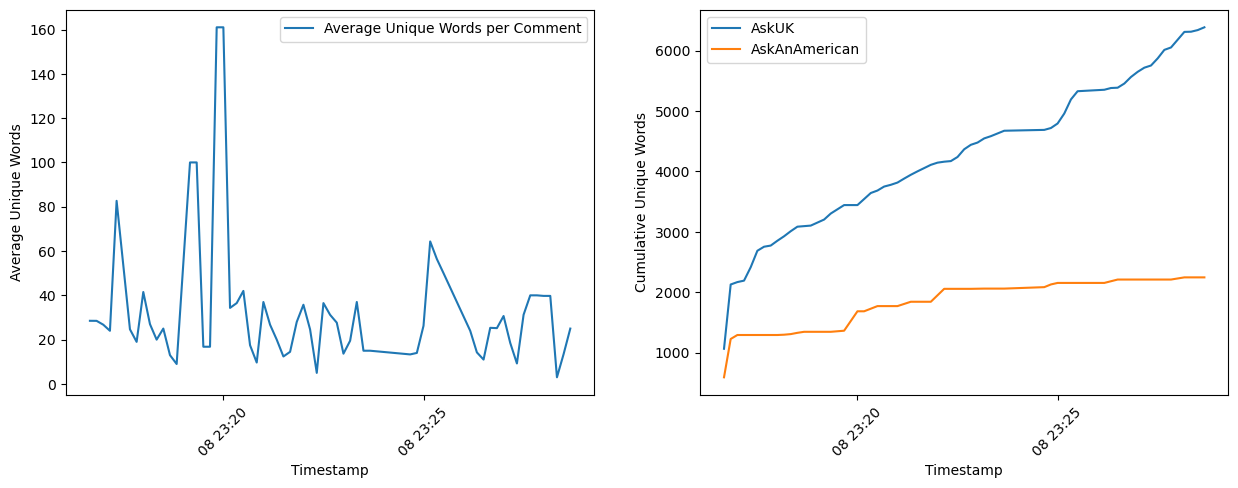

Current MAE: 24.0096
----------- 2023-12-08 23:28:50 -----------
+-------------------+-------+----------+--------------------+---------+-------------+-------------+
|             author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-------------------+-------+----------+--------------------+---------+-------------+-------------+
|Aromatic_Flight6968|kcker2e|   18dyyid|If it's just by o...|    AskUK|1.702078102E9|   1702078112|
|        adaminaudio|kckeris|   18dymwu|Not Ohio yanks. W...|    AskUK|1.702078107E9|   1702078121|
|       CatwellTarly|kckerlk|   18dsn9d|Sounds like my mu...|    AskUK|1.702078108E9|   1702078121|
|    Charming_Pirate|kckerwc|   18dyvah|            A tenner|    AskUK|1.702078112E9|   1702078123|
|        elplacerguy|kckerzw|   18dyvah|The biggest sheet...|    AskUK|1.702078113E9|   1702078123|
+-------------------+-------+----------+--------------------+---------+-------------+-------------+



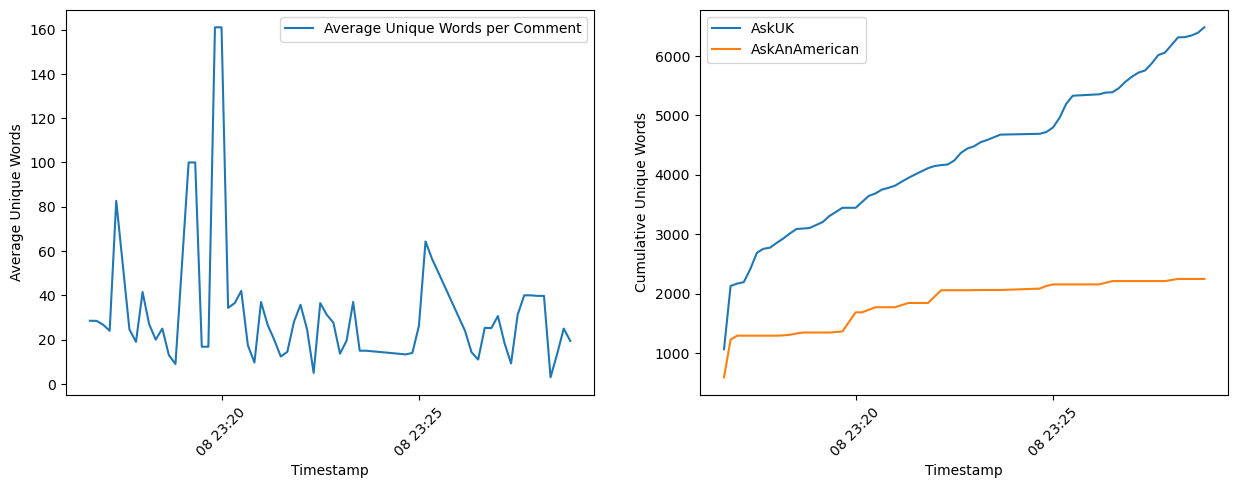

Current MAE: 18.114474318634088
----------- 2023-12-08 23:29:00 -----------
+---------------+-------+----------+--------------------+---------+-------------+-------------+
|         author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+---------------+-------+----------+--------------------+---------+-------------+-------------+
|    adaminaudio|kckeris|   18dymwu|Not Ohio yanks. W...|    AskUK|1.702078107E9|   1702078121|
|   CatwellTarly|kckerlk|   18dsn9d|Sounds like my mu...|    AskUK|1.702078108E9|   1702078121|
|Charming_Pirate|kckerwc|   18dyvah|            A tenner|    AskUK|1.702078112E9|   1702078123|
|    elplacerguy|kckerzw|   18dyvah|The biggest sheet...|    AskUK|1.702078113E9|   1702078123|
|Phoenix_Cluster|kckesky|   18dl6a5|How much of a des...|    AskUK| 1.70207812E9|   1702078132|
+---------------+-------+----------+--------------------+---------+-------------+-------------+



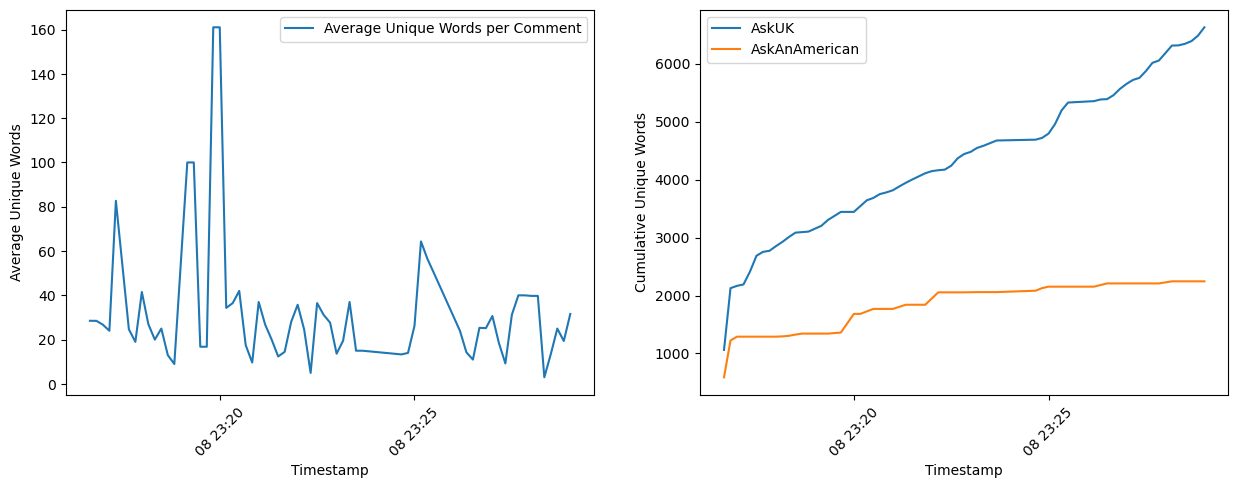

Current MAE: 28.777204254340568
----------- 2023-12-08 23:29:10 -----------
+---------------+-------+----------+--------------------+---------+------------+-------------+
|         author|     id|submission|                body|subreddit| created_utc|collected_utc|
+---------------+-------+----------+--------------------+---------+------------+-------------+
|Phoenix_Cluster|kckesky|   18dl6a5|How much of a des...|    AskUK|1.70207812E9|   1702078132|
+---------------+-------+----------+--------------------+---------+------------+-------------+



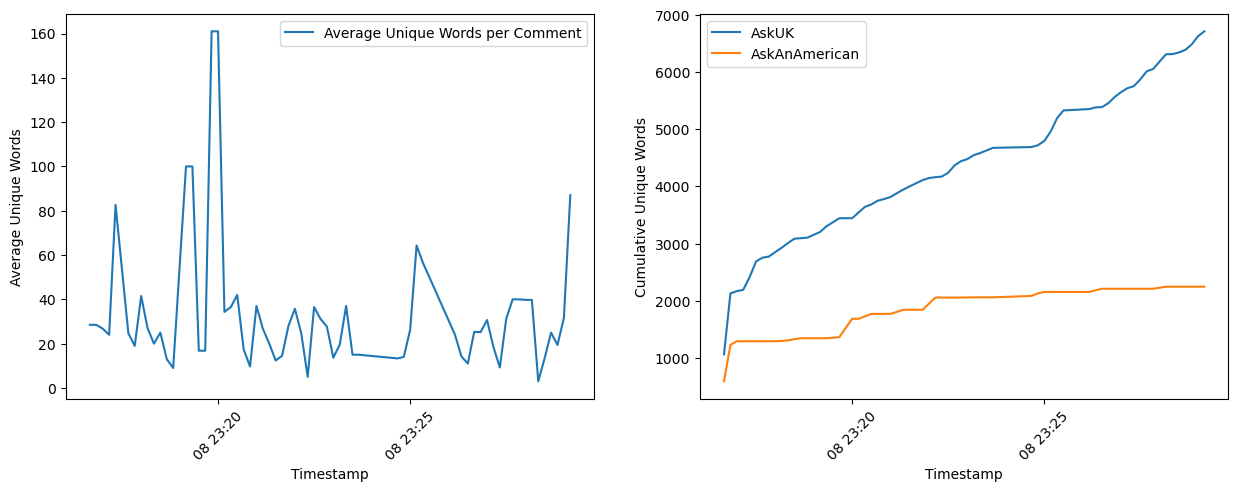

Current MAE: 85.26
----------- 2023-12-08 23:29:20 -----------
+--------------+-------+----------+--------------------+---------+------------+-------------+
|        author|     id|submission|                body|subreddit| created_utc|collected_utc|
+--------------+-------+----------+--------------------+---------+------------+-------------+
|coffeewalnut05|kckeu3l|   18dl6a5|I wouldn’t say it...|    AskUK|1.70207814E9|   1702078150|
|   olivercroke|kckeu58|   18dl6a5|Definitely more c...|    AskUK|1.70207814E9|   1702078152|
+--------------+-------+----------+--------------------+---------+------------+-------------+



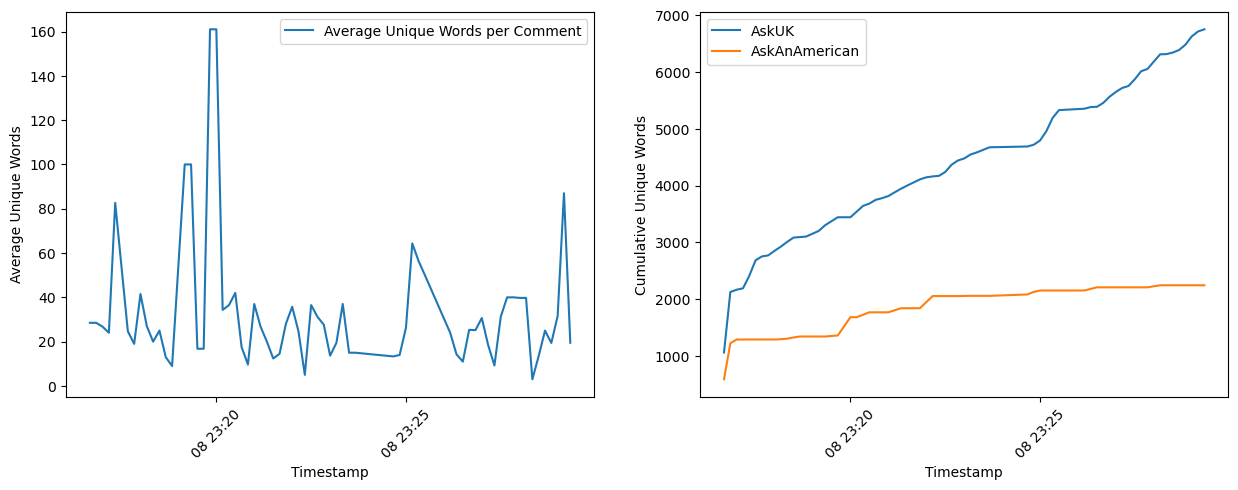

Current MAE: 18.7292
----------- 2023-12-08 23:29:30 -----------
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|        author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|coffeewalnut05|kckeu3l|   18dl6a5|I wouldn’t say it...|    AskUK| 1.70207814E9|   1702078150|
|   olivercroke|kckeu58|   18dl6a5|Definitely more c...|    AskUK| 1.70207814E9|   1702078152|
|      Teembeau|kckev0m|   18ds9gj|Why should it? Th...|    AskUK|1.702078151E9|   1702078162|
+--------------+-------+----------+--------------------+---------+-------------+-------------+



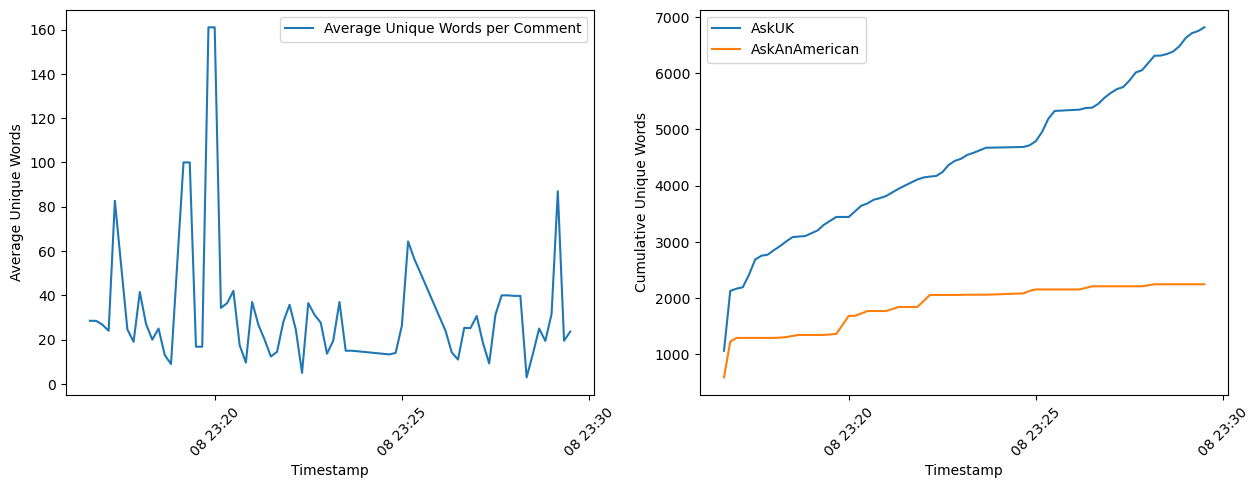

Current MAE: 22.615328026184834
----------- 2023-12-08 23:29:40 -----------
+-----------------+-------+----------+--------------------+---------+-------------+-------------+
|           author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-----------------+-------+----------+--------------------+---------+-------------+-------------+
|         Teembeau|kckev0m|   18ds9gj|Why should it? Th...|    AskUK|1.702078151E9|   1702078162|
|       defconluke|kckevi6|   18dyvah|Autobiography of ...|    AskUK|1.702078157E9|   1702078170|
|DarrenBridgescunt|kckevx0|   18dn5o8|Name 1 social set...|    AskUK|1.702078162E9|   1702078172|
+-----------------+-------+----------+--------------------+---------+-------------+-------------+



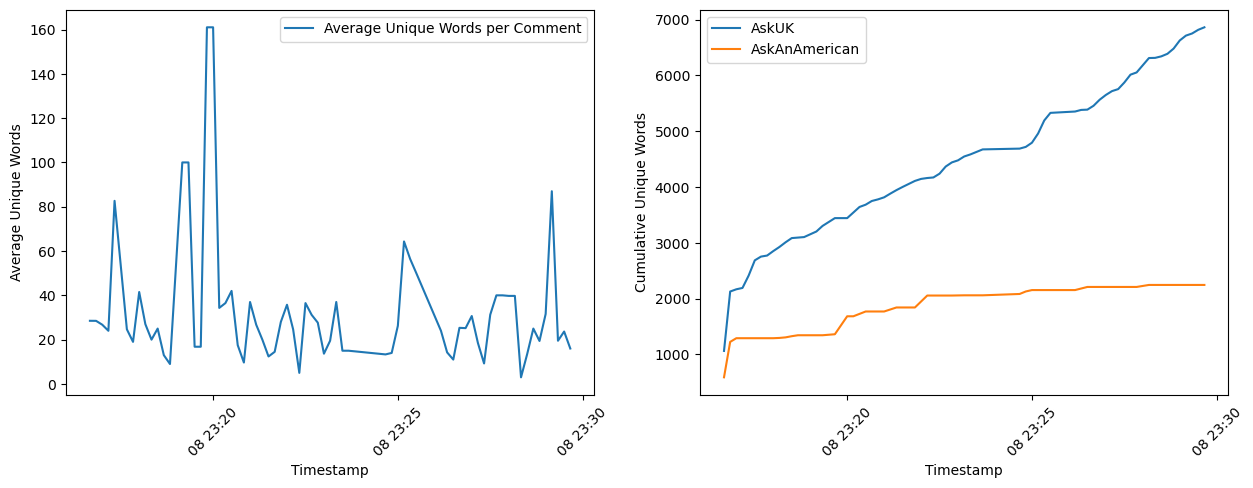

Current MAE: 15.139804719911005
----------- 2023-12-08 23:29:50 -----------
+------------------+-------+----------+--------------------+-------------+-------------+-------------+
|            author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+------------------+-------+----------+--------------------+-------------+-------------+-------------+
|        defconluke|kckevi6|   18dyvah|Autobiography of ...|        AskUK|1.702078157E9|   1702078170|
| DarrenBridgescunt|kckevx0|   18dn5o8|Name 1 social set...|        AskUK|1.702078162E9|   1702078172|
|Technical_Plum2239|kckewhk|   18dxlv3|Greeks own the pi...|AskAnAmerican|1.702078169E9|   1702078181|
+------------------+-------+----------+--------------------+-------------+-------------+-------------+



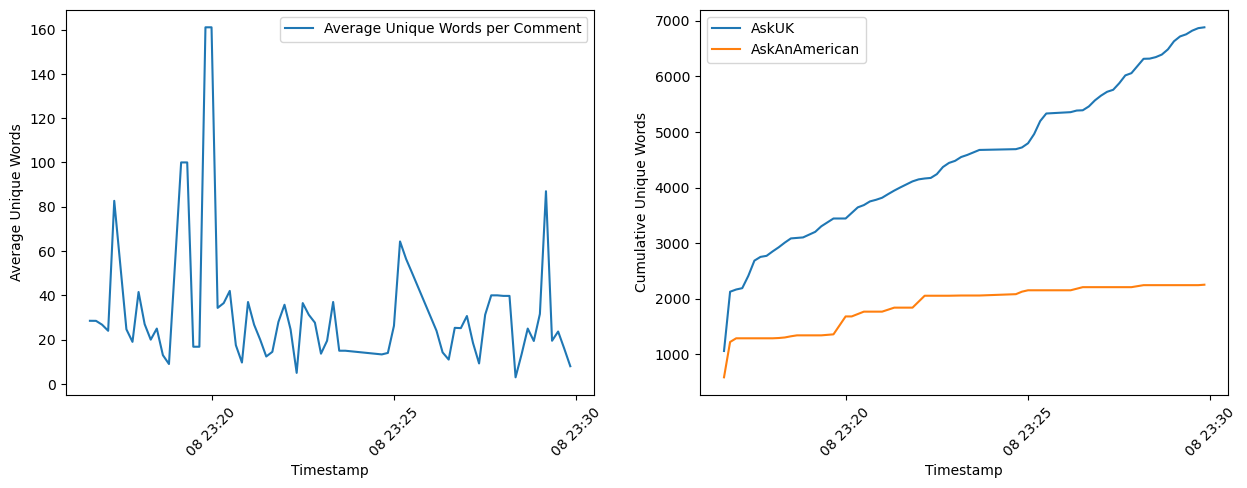

Current MAE: 7.6507535236545285
----------- 2023-12-08 23:30:00 -----------
+------------------+-------+----------+--------------------+-------------+-------------+-------------+
|            author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+------------------+-------+----------+--------------------+-------------+-------------+-------------+
|Technical_Plum2239|kckewhk|   18dxlv3|Greeks own the pi...|AskAnAmerican|1.702078169E9|   1702078181|
+------------------+-------+----------+--------------------+-------------+-------------+-------------+



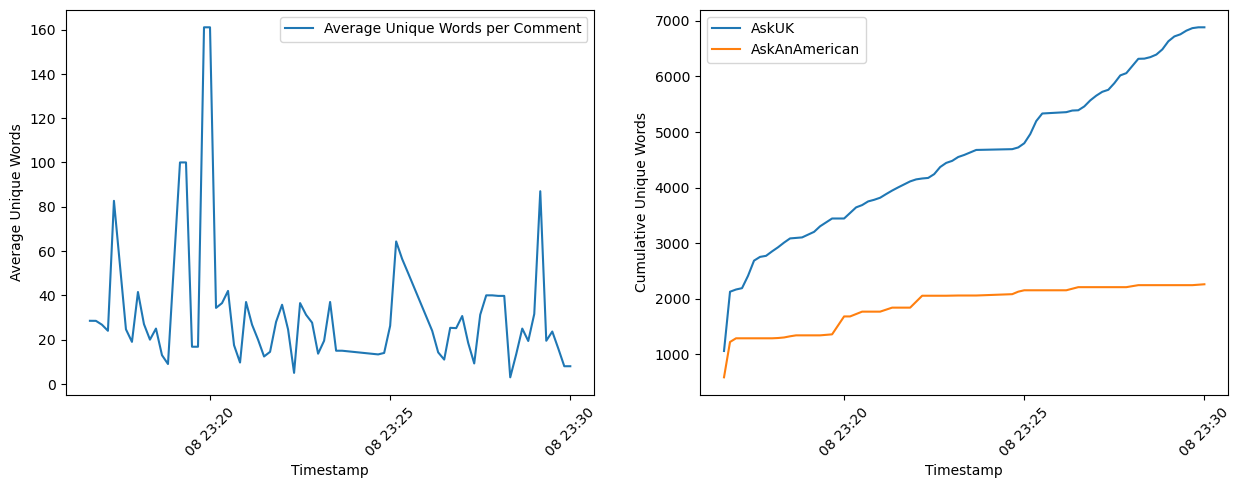

Current MAE: 7.84
----------- 2023-12-08 23:30:10 -----------
Error: RDD is empty
----------- 2023-12-08 23:30:20 -----------
+--------+-------+----------+--------------------+-------------+-------------+-------------+
|  author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------+-------+----------+--------------------+-------------+-------------+-------------+
|btmg1428|kckeyba|   18dqkjh|They're only here...|AskAnAmerican|1.702078192E9|   1702078215|
| llufnam|kckeyhr|   18dsclm|The older I get (...|        AskUK|1.702078194E9|   1702078215|
+--------+-------+----------+--------------------+-------------+-------------+-------------+



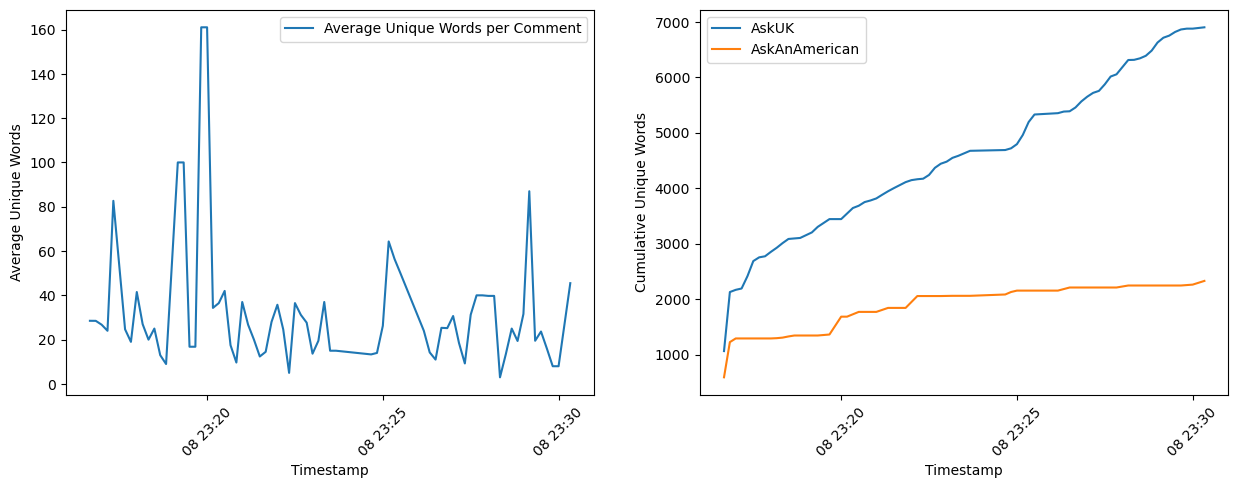

Current MAE: 43.7068
----------- 2023-12-08 23:30:30 -----------
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|        author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|      btmg1428|kckeyba|   18dqkjh|They're only here...|AskAnAmerican|1.702078192E9|   1702078215|
|       llufnam|kckeyhr|   18dsclm|The older I get (...|        AskUK|1.702078194E9|   1702078215|
|thegreatherper|kckf02h|   18dqkjh|And black men use...|AskAnAmerican|1.702078214E9|   1702078225|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+



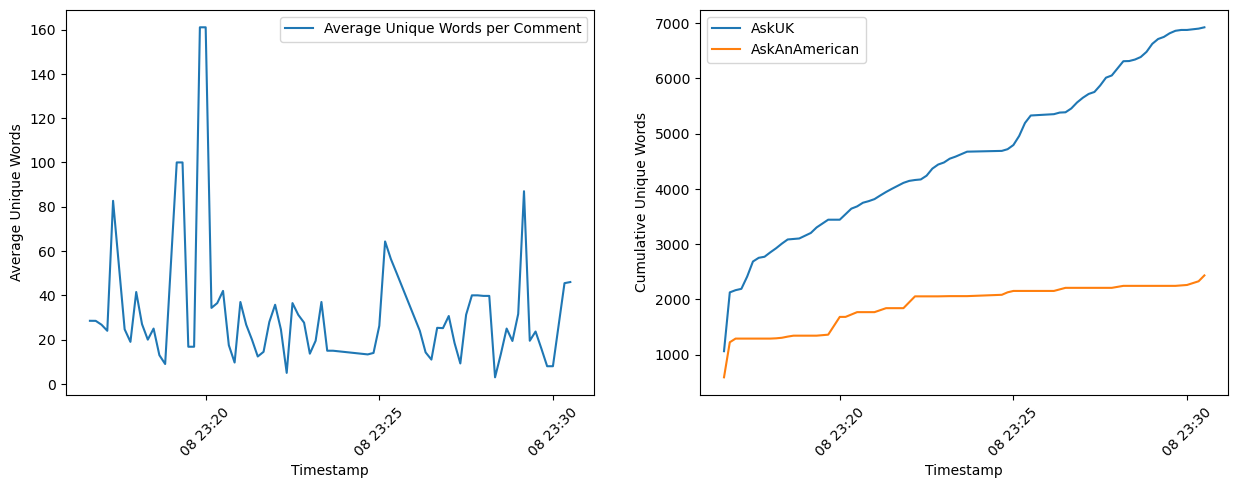

Current MAE: 43.836127349105546
----------- 2023-12-08 23:30:40 -----------
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|        author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+
|thegreatherper|kckf02h|   18dqkjh|And black men use...|AskAnAmerican|1.702078214E9|   1702078225|
+--------------+-------+----------+--------------------+-------------+-------------+-------------+



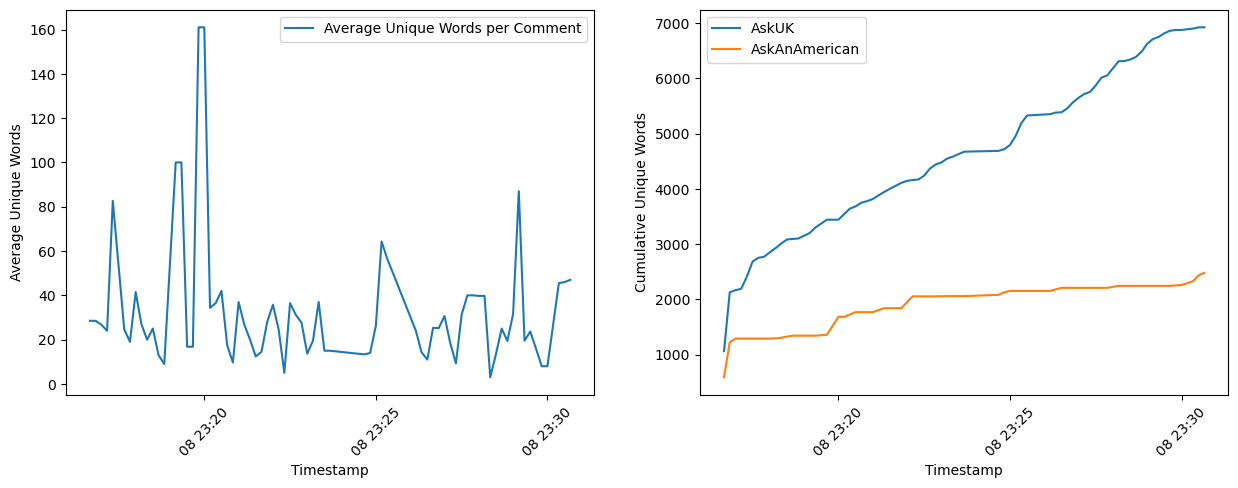

Current MAE: 46.06
----------- 2023-12-08 23:30:50 -----------
Error: RDD is empty
----------- 2023-12-08 23:31:00 -----------
Error: RDD is empty
----------- 2023-12-08 23:31:10 -----------
+--------------------+-------+----------+--------------------+-------------+-------------+-------------+
|              author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------------+-------+----------+--------------------+-------------+-------------+-------------+
|      Genericc0ntent|kckf1q8|   18b8hm7|Watch with mother...|        AskUK|1.702078235E9|   1702078261|
|     1968Bladerunner|kckf24k|   18dy8ea|Worked for me for...|        AskUK| 1.70207824E9|   1702078261|
|        Evil_Weevill|kckf2fd|   18dqkjh|Thank you, I appr...|AskAnAmerican|1.702078244E9|   1702078261|
|LittleRedRidingSmith|kckf2k2|   18dl6a5|It's not really s...|        AskUK|1.702078245E9|   1702078261|
| Clean-Direction6246|kckf2kd|   18dsn9d|Looking back my m...|        AskU

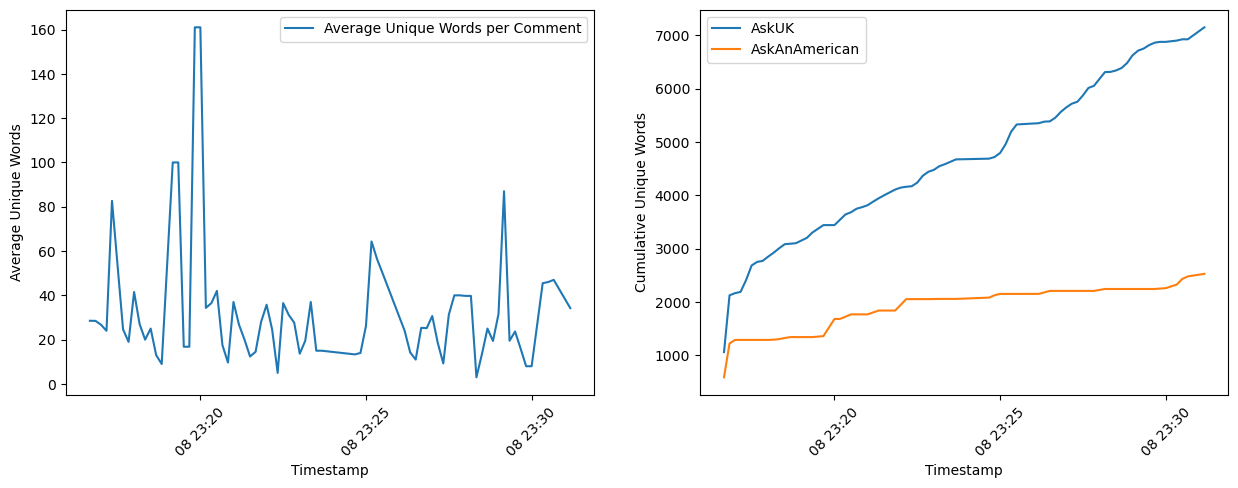

Current MAE: 30.3852099576764
----------- 2023-12-08 23:31:20 -----------
+--------------------+-------+----------+--------------------+-------------+-------------+-------------+
|              author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+--------------------+-------+----------+--------------------+-------------+-------------+-------------+
|      Genericc0ntent|kckf1q8|   18b8hm7|Watch with mother...|        AskUK|1.702078235E9|   1702078261|
|     1968Bladerunner|kckf24k|   18dy8ea|Worked for me for...|        AskUK| 1.70207824E9|   1702078261|
|        Evil_Weevill|kckf2fd|   18dqkjh|Thank you, I appr...|AskAnAmerican|1.702078244E9|   1702078261|
|LittleRedRidingSmith|kckf2k2|   18dl6a5|It's not really s...|        AskUK|1.702078245E9|   1702078261|
| Clean-Direction6246|kckf2kd|   18dsn9d|Looking back my m...|        AskUK|1.702078246E9|   1702078261|
|      Forteanforever|kckf2ku|   18dl6a5|History very much...|        AskUK|1.70207824

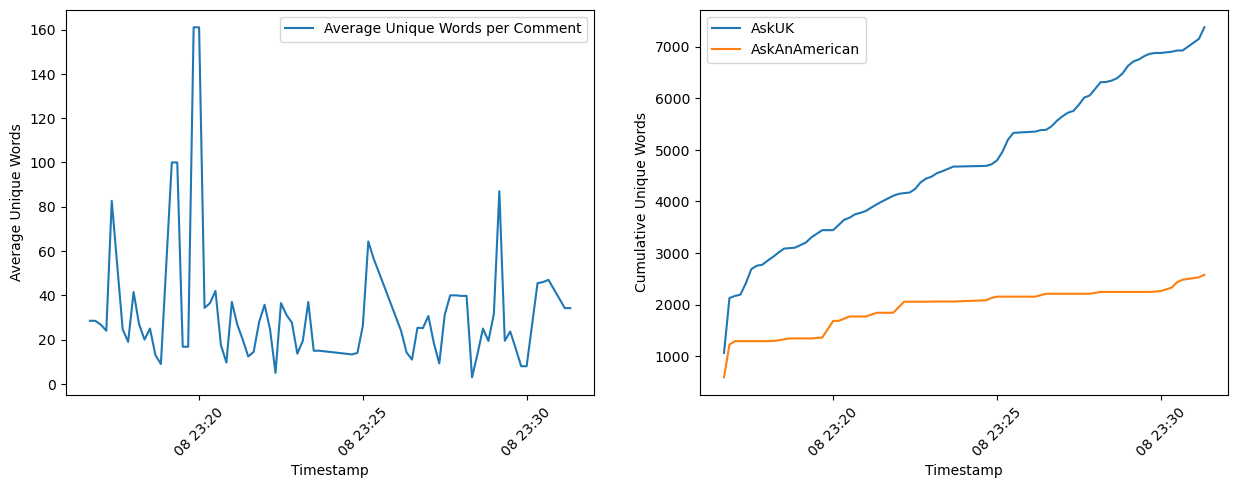

Current MAE: 30.3852099576764
----------- 2023-12-08 23:31:30 -----------
+-------------+-------+----------+--------------------+-------------+-------------+-------------+
|       author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-------------+-------+----------+--------------------+-------------+-------------+-------------+
|Krikkit_Jelly|kckf412|   18dl6a5|>no one ever says...|        AskUK|1.702078264E9|   1702078280|
| ClassieLadyk|kckf44s|   18dru1r|       34 and same!!|AskAnAmerican|1.702078265E9|   1702078280|
|    WoodyM654|kckf4x0|   18dxlv3|   “The Other Place”|AskAnAmerican|1.702078275E9|   1702078285|
+-------------+-------+----------+--------------------+-------------+-------------+-------------+



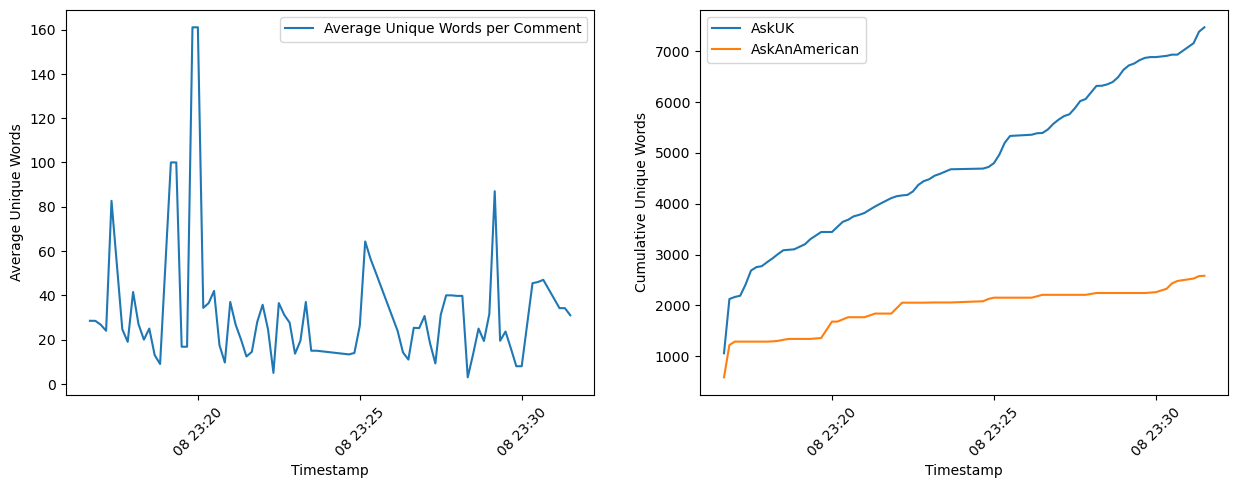

Current MAE: 29.216813693714037
----------- 2023-12-08 23:31:40 -----------
+-------------+-------+----------+--------------------+-------------+-------------+-------------+
|       author|     id|submission|                body|    subreddit|  created_utc|collected_utc|
+-------------+-------+----------+--------------------+-------------+-------------+-------------+
|Krikkit_Jelly|kckf412|   18dl6a5|>no one ever says...|        AskUK|1.702078264E9|   1702078280|
| ClassieLadyk|kckf44s|   18dru1r|       34 and same!!|AskAnAmerican|1.702078265E9|   1702078280|
|    WoodyM654|kckf4x0|   18dxlv3|   “The Other Place”|AskAnAmerican|1.702078275E9|   1702078285|
+-------------+-------+----------+--------------------+-------------+-------------+-------------+



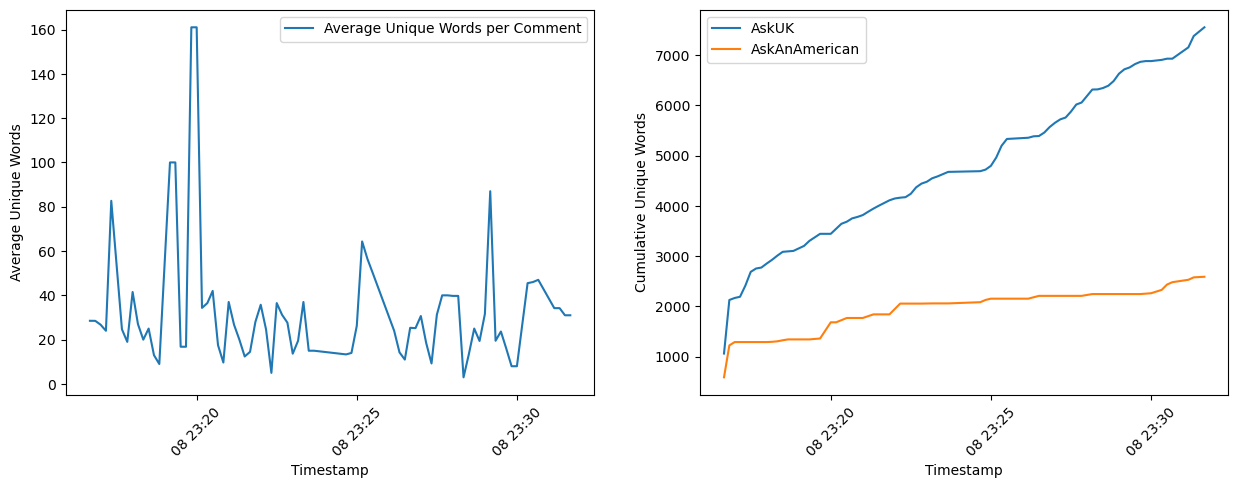

Current MAE: 29.216813693714037
----------- 2023-12-08 23:31:50 -----------
+-----------+-------+----------+--------------------+---------+-------------+-------------+
|     author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+-----------+-------+----------+--------------------+---------+-------------+-------------+
|MungoMayhem|kckf5s6|   18dla4b|I’m 5’10 and 76kg...|    AskUK|1.702078286E9|   1702078303|
+-----------+-------+----------+--------------------+---------+-------------+-------------+



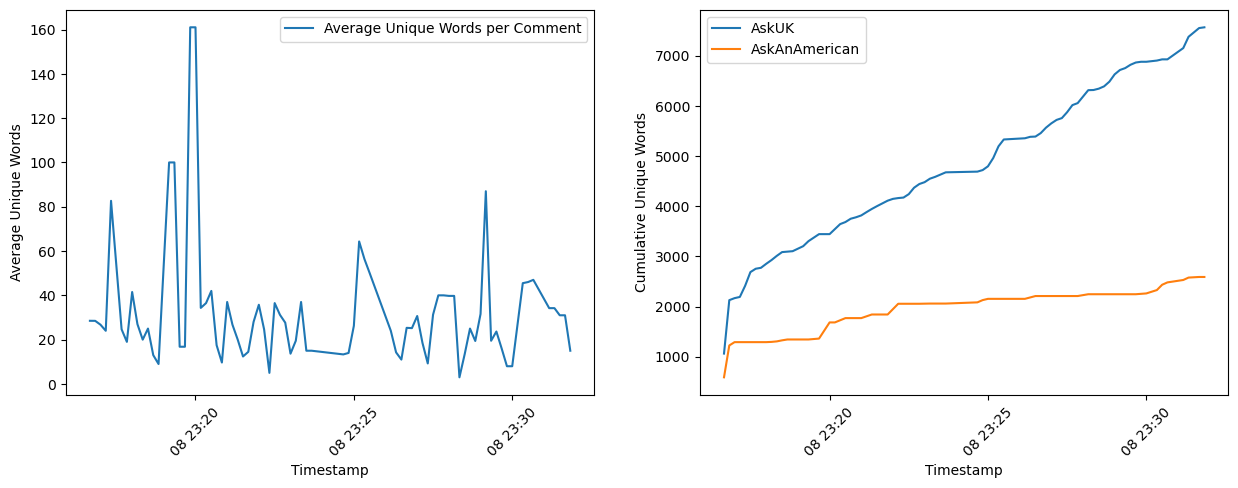

Current MAE: 14.7
----------- 2023-12-08 23:32:00 -----------
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|        author|     id|submission|                body|subreddit|  created_utc|collected_utc|
+--------------+-------+----------+--------------------+---------+-------------+-------------+
|   MungoMayhem|kckf5s6|   18dla4b|I’m 5’10 and 76kg...|    AskUK|1.702078286E9|   1702078303|
|Forteanforever|kckf6uj|   18dl6a5|He means in real ...|    AskUK|1.702078299E9|   1702078312|
+--------------+-------+----------+--------------------+---------+-------------+-------------+



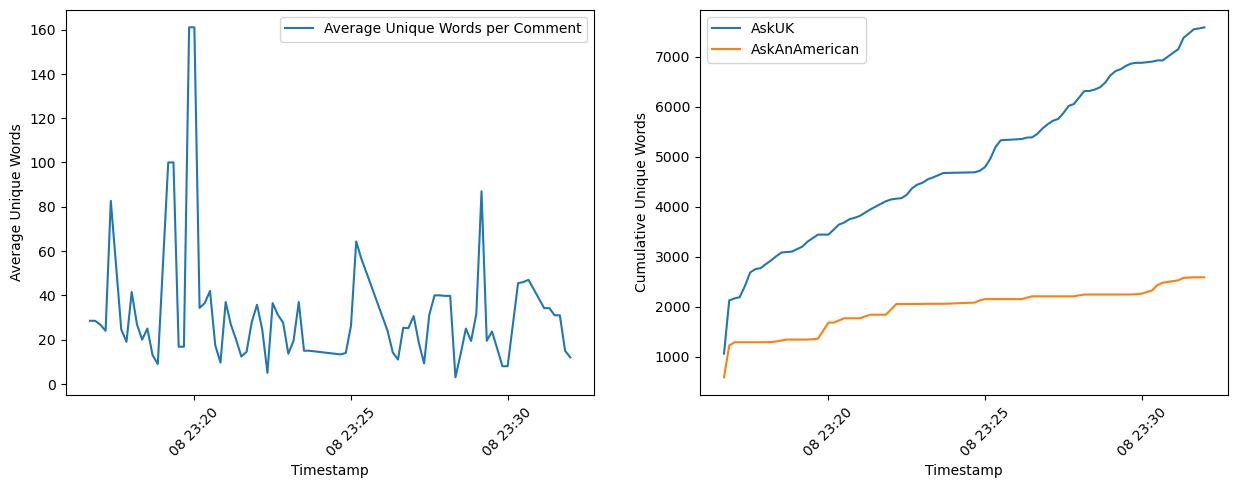

Current MAE: 11.526


In [6]:
ssc.start()
# ssc.awaitTermination()



In [7]:
ssc.stop()
sc.stop()

In [ ]:
"""Based on the cumulative unique words graph , it's clear that there is a difference in the number of unique words used in the two subreddits
over time. The subreddit AskUK shows a much steeper increase in unique words used, indicating a greater diversity of language or a larger number of topics
discussed. In contrast, AskAnAmerican has a more gradual increase.

A possible hypothesis for this observation could be that the AskUK subreddit has a higher level of engagement or a more diverse user base contributing
to a wider range of topics. Alternatively, it could mean that discussions in AskUK tend to cover a more vocabulary, which could be due to cultural
or contextual factors like a broader range of topics being relevant to UK users, or differences in how the communities interact.
On the other hand, the AskAnAmerican subreddit might have more focused discussions or a smaller active community,
leading to a slower growth in unique word count.

The fact that AskUK has 400,000 more users than AskAnAmerican could also significantly contribute
to the difference in the cumulative number of unique words observed. A subreddit with more users will generally have more posts and comments.
This increased volume of content can lead to a faster accumulation of unique words.""" 

